In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os
from get_model import getmodel
import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    #file_tot=file_end-file_start
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C1_20')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((n,n,121))
y=np.zeros((n,n,121))
vx=np.zeros((n,n,121))
vy=np.zeros((n,n,121))

#print(x[0,:,:])

In [4]:
#u is not pre adding, v add a median

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)

spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

u=np.zeros((n,n,121, 3))
u[:, :, :, 0] = vx
u[:, :, :, 1] = vy

t=np.linspace(0,60/800,121)

t_in=np.zeros((n,n,121))
for i in range (len(t)):
    t_in[:,:,i]=t[i]

u[:, :, :, 2] = t_in

dt=t[1]-t[0]

t_adding=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
print(t_adding.shape)
dt_adding=t_adding[1]-t_adding[0]

u_train=np.zeros((n,n,len(t_adding),3))

for i in range(len(t)-1):
    for j in range(addp):
        u_train[:,:,addp*i+j]=(u[:,:,i]*(addp-j)+u[:,:,i+1]*j)/addp
u_train[:,:,-1]=u[:,:,-1]


(601,)


In [5]:
# import test data
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,51,100,xstart,xend)
ut=np.zeros((n,n,121, 3))

ut[:, :, :, 0] = vx_test
ut[:, :, :, 1] = vy_test
ut[:, :, :, 2] = t_in

u_test=np.zeros((n,n,len(t_adding), 3))

for i in range(len(t)-1):
    for j in range(addp):
        u_test[:,:,addp*i+j]=(ut[:,:,i]*(addp-j)+ut[:,:,i+1]*j)/addp
u_test[:,:,-1]=ut[:,:,-1]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

round: 0
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -17.746 1 + 15.718 Vx + 34.587 Vy + -1193.324 t + -12.970 VxVx + 18.573 VyVy + 182674.137 tt + 10.640 VxVy + -6065.173 Vxt + 366.528 Vyt + 3.475 VxVxVy + 2654.876 VxVxt + -1001.892 VyVyt + -3121.795 VxVyt + -99.254 Vx_2 + -40.215 Vy_2 + 145.665 Vx_1 + 240.463 Vy_1 + 23.389 VxVx_2 + -223.929 VxVy_2 + 37577.022 Vxt_2 + -1.269 VyVx_2 + 2.440 VyVy_2 + -1332174.089 Vyt_2 + -31.188 tVx_2 + -3240.228 tVy_2 + 5387.856 tt_2 + 2.724 VxVxVx_2 + -1158.824 VxVxVy_2 + -2875.507 VxVxt_2 + -279.629 VyVyVx_2 + -144.367 VyVyVy_2 + 2.562 VyVyt_2 + 17481.644 ttVx_2 + -15.282 ttVy_2 + 25.693 ttt_2 + -1369705.107 VxVyVx_2 + 30.991 VxVyVy_2 + 20873.835 VxVyt_2 + -4618.901 VxtVx_2 + 3.549 VxtVy_2 + 4538.171 Vxtt_2 + -1998.567 VytVx_2 + 1737.226 VytVy_2 + -89.380 VxVx_1 + -9.692 VxVy_1 + -64125.084 Vxt_1 + -19.323 VyVx_1 + 12.107 VyVy_1 + 3446314.750 Vyt_1 + 73.164 tVx_1 + 12315.089 tVy_1 + 54.798 tt_1 + 12.148 VxVxVx_1 + 1960.456 VxVxVy_1 + -1988.348 VxVxt_1 + -5

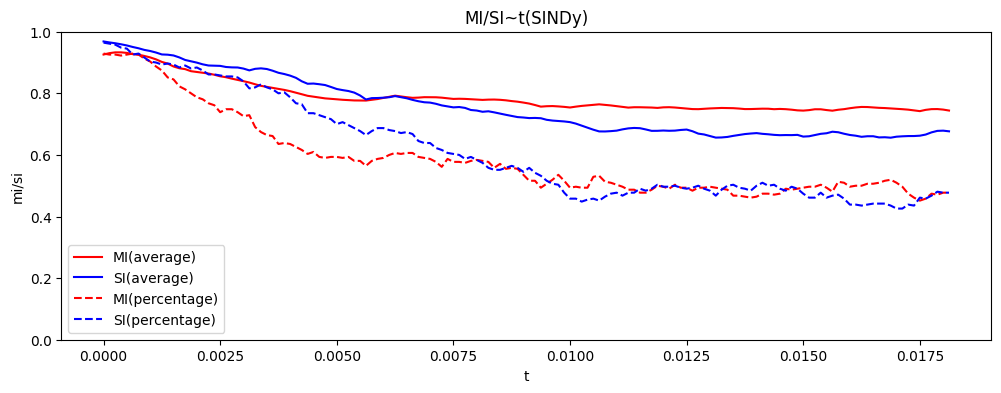

round: 1
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -23.570 1 + 1.263 Vx + 5.827 Vy + 1611.430 t + -11.830 VxVx + 16.598 VyVy + 15285.811 tt + 28.731 VxVy + -4426.554 Vxt + 2306.326 Vyt + 6.737 VxVxVy + 2426.197 VxVxt + -891.294 VyVyt + -4317.233 VxVyt + -35.613 Vx_2 + -42.525 Vy_2 + 156.742 Vx_1 + 270.803 Vy_1 + 27.018 VxVx_2 + -326.717 VxVy_2 + 27429.147 Vxt_2 + -2.820 VyVx_2 + -8.705 VyVy_2 + -1010408.280 Vyt_2 + -26.618 tVx_2 + -4848.075 tVy_2 + 17565.825 tt_2 + 7.173 VxVxVx_2 + -1480.008 VxVxVy_2 + -3022.865 VxVxt_2 + -403.411 VyVyVx_2 + -144.663 VyVyVy_2 + -117.206 VyVyt_2 + 9309.410 ttVx_2 + -7.736 ttVy_2 + 54.049 ttt_2 + -645266.339 VxVyVx_2 + 84.068 VxVyVy_2 + 18381.687 VxVyt_2 + 5058.655 VxtVx_2 + 10.113 VxtVy_2 + 4163.547 Vxtt_2 + -4580.083 VytVx_2 + -2304.023 VytVy_2 + -85.603 VxVx_1 + 22.086 VxVy_1 + -68774.904 Vxt_1 + -14.046 VyVx_1 + -8.585 VyVy_1 + 3727494.841 Vyt_1 + 102.026 tVx_1 + 11082.062 tVy_1 + -2674.486 tt_1 + 14.266 VxVxVx_1 + 1147.220 VxVxVy_1 + -292.211 VxVxt_1 + 

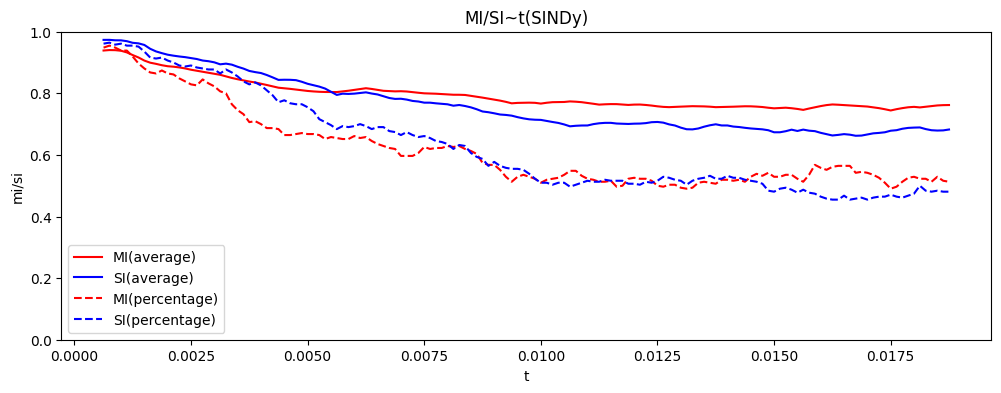

round: 2
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -45.907 1 + -21.045 Vx + 11.678 Vy + 8855.963 t + -7.106 VxVx + 12.996 VyVy + -380984.431 tt + 22.437 VxVy + -1535.557 Vxt + 1873.983 Vyt + 4.512 VxVxVy + 1422.789 VxVxt + -735.530 VyVyt + -3707.711 VxVyt + 49.758 Vx_2 + -76.368 Vy_2 + 59.734 Vx_1 + 223.770 Vy_1 + 27.848 VxVx_2 + -302.805 VxVy_2 + 13963.371 Vxt_2 + -13.661 VyVx_2 + -5.796 VyVy_2 + -720007.817 Vyt_2 + -13.552 tVx_2 + -3738.332 tVy_2 + 14890.220 tt_2 + 9.638 VxVxVx_2 + 592.086 VxVxVy_2 + -2950.313 VxVxt_2 + -1056.845 VyVyVx_2 + -137.343 VyVyVy_2 + -106.624 VyVyt_2 + 19276.484 ttVx_2 + 9.559 ttVy_2 + 48.601 ttt_2 + -1087789.296 VxVyVx_2 + 75.769 VxVyVy_2 + 17076.688 VxVyt_2 + 4795.991 VxtVx_2 + 6.004 VxtVy_2 + 1230.320 Vxtt_2 + -4487.007 VytVx_2 + -1109.273 VytVy_2 + -58.828 VxVx_1 + 105.659 VxVy_1 + -44979.964 Vxt_1 + -14.550 VyVx_1 + -12.014 VyVy_1 + 2616278.202 Vyt_1 + 97.446 tVx_1 + 6586.815 tVy_1 + -9131.709 tt_1 + 12.570 VxVxVx_1 + 890.513 VxVxVy_1 + -270.649 VxVxt_1 + 

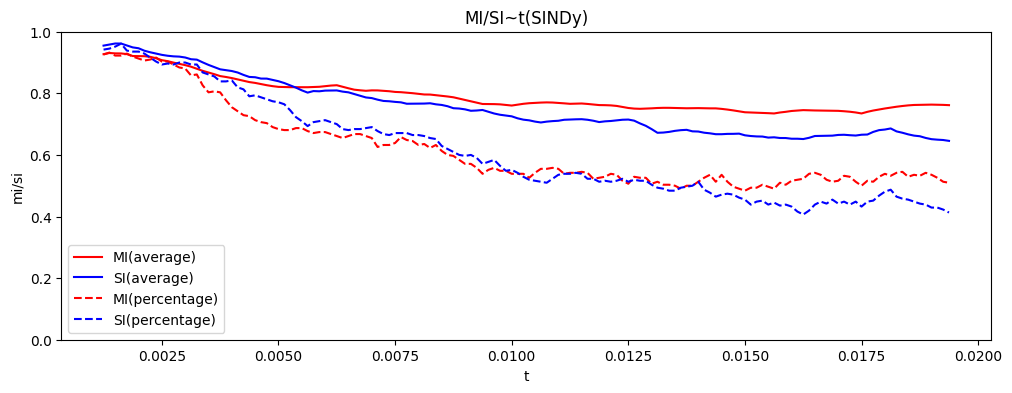

round: 3
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -94.845 1 + -22.606 Vx + 15.791 Vy + 19372.749 t + -14.015 VxVx + 10.103 VyVy + -836660.868 tt + -16.573 VxVy + -2145.411 Vxt + 1310.995 Vyt + 0.330 VxVxVy + 2239.412 VxVxt + -578.456 VyVyt + 13.028 VxVyt + 58.269 Vx_2 + -69.251 Vy_2 + -1.282 Vx_1 + 151.352 Vy_1 + 5.028 VxVx_2 + -415.334 VxVy_2 + 17062.243 Vxt_2 + -13.239 VyVx_2 + 52.678 VyVy_2 + -932996.246 Vyt_2 + -7.261 tVx_2 + 300.324 tVy_2 + 27362.517 tt_2 + 5.895 VxVxVx_2 + 647.906 VxVxVy_2 + -9553.593 VxVxt_2 + -2357.922 VyVyVx_2 + -96.113 VyVyVy_2 + -174.747 VyVyt_2 + 20601.044 ttVx_2 + 8.956 ttVy_2 + 28.666 ttt_2 + -1179428.325 VxVyVx_2 + 16.230 VxVyVy_2 + 11734.165 VxVyt_2 + 9065.683 VxtVx_2 + 5.110 VxtVy_2 + 852.405 Vxtt_2 + -2169.026 VytVx_2 + 3947.392 VytVy_2 + -51.907 VxVx_1 + 21.497 VxVy_1 + -31756.721 Vxt_1 + -16.182 VyVx_1 + -13.729 VyVy_1 + 1930515.544 Vyt_1 + 54.084 tVx_1 + 7049.990 tVy_1 + -1398.583 tt_1 + 9.095 VxVxVx_1 + 1360.254 VxVxVy_1 + -201.196 VxVxt_1 + -5174.76

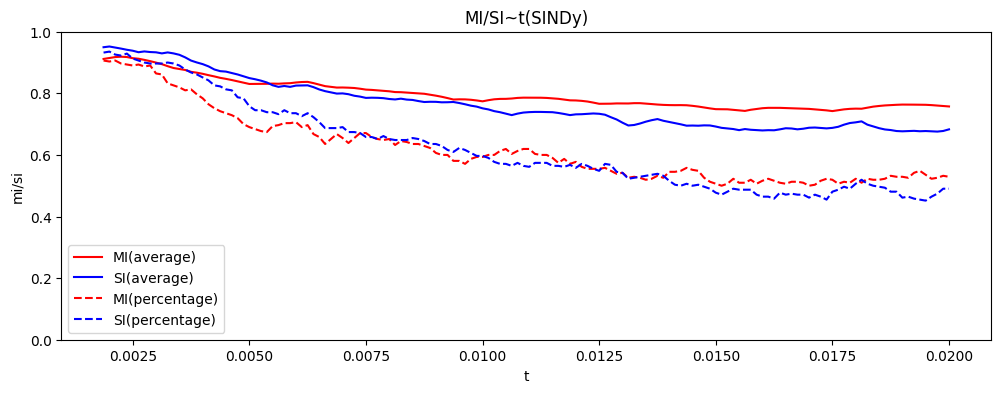

round: 4
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -84.799 1 + 1.659 Vx + 42.113 Vy + 15447.012 t + -16.261 VxVx + -19.568 VyVy + -602924.945 tt + -44.578 VxVy + -4387.000 Vxt + -1028.818 Vyt + 0.083 VxVxVy + 2498.925 VxVxt + 1760.848 VyVyt + 2231.598 VxVyt + 15.446 Vx_2 + 55.283 Vy_2 + -150.216 Vx_1 + -36.498 Vy_1 + -12.978 VxVx_2 + -370.290 VxVy_2 + 19386.064 Vxt_2 + -14.694 VyVx_2 + 108.324 VyVy_2 + -912675.956 Vyt_2 + 26.257 tVx_2 + 2260.092 tVy_2 + 24363.448 tt_2 + 2.370 VxVxVx_2 + 1193.149 VxVxVy_2 + -13617.740 VxVxt_2 + -3994.340 VyVyVx_2 + -50.529 VyVyVy_2 + -182.625 VyVyt_2 + -3501.220 ttVx_2 + -1.064 ttVy_2 + 11.401 ttt_2 + -81548.323 VxVyVx_2 + 6.347 VxVyVy_2 + 8075.490 VxVyt_2 + 9662.440 VxtVx_2 + 2.692 VxtVy_2 + 1434.208 Vxtt_2 + -652.903 VytVx_2 + 3491.717 VytVy_2 + -57.736 VxVx_1 + -26.817 VxVy_1 + 7485.555 Vxt_1 + -15.246 VyVx_1 + -68.306 VyVy_1 + -78414.157 Vyt_1 + 42.623 tVx_1 + 7094.015 tVy_1 + 2141.066 tt_1 + 7.810 VxVxVx_1 + 1420.223 VxVxVy_1 + 3882.627 VxVxt_1 + -3776

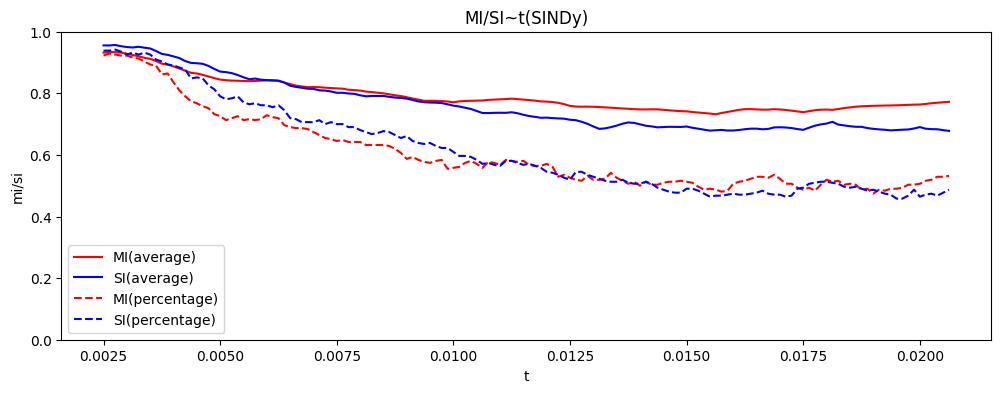

round: 5
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -82.665 1 + -27.432 Vx + 97.533 Vy + 15035.027 t + -28.741 VxVx + 1.166 VyVy + -585596.423 tt + -83.582 VxVy + -1320.009 Vxt + -4287.233 Vyt + -4.511 VxVxVy + 3255.572 VxVxt + -73.679 VyVyt + 5178.291 VxVyt + 201.753 Vx_2 + 212.638 Vy_2 + -122.314 Vx_1 + -67.034 Vy_1 + -34.973 VxVx_2 + -394.908 VxVy_2 + -15655.760 Vxt_2 + -8.842 VyVx_2 + 104.094 VyVy_2 + 569658.234 Vyt_2 + 28.291 tVx_2 + 4372.955 tVy_2 + 29640.638 tt_2 + -6.163 VxVxVx_2 + 864.130 VxVxVy_2 + -14074.294 VxVxt_2 + -4573.297 VyVyVx_2 + 59.375 VyVyVy_2 + -149.507 VyVyt_2 + -36536.428 ttVx_2 + -27.951 ttVy_2 + 14.627 ttt_2 + 1306397.849 VxVyVx_2 + -75.622 VxVyVy_2 + -3342.538 VxVyt_2 + 6178.145 VxtVx_2 + 6.677 VxtVy_2 + 3595.880 Vxtt_2 + 98.609 VytVx_2 + 8763.414 VytVy_2 + -32.820 VxVx_1 + -19.258 VxVy_1 + -4597.155 Vxt_1 + -10.085 VyVx_1 + 25.771 VyVy_1 + 690534.333 Vyt_1 + 64.760 tVx_1 + 5198.037 tVy_1 + 1006.028 tt_1 + 7.990 VxVxVx_1 + 1001.687 VxVxVy_1 + -2557.710 VxVxt_1 + 

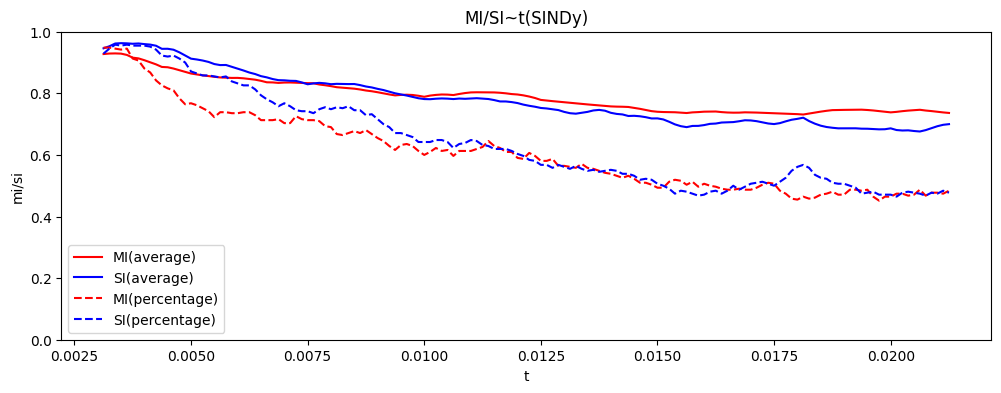

round: 6
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -110.977 1 + -40.815 Vx + 104.461 Vy + 18983.027 t + -28.100 VxVx + 1.436 VyVy + -712301.866 tt + -96.361 VxVy + -417.647 Vxt + -4939.542 Vyt + -4.737 VxVxVy + 3142.322 VxVxt + 104.624 VyVyt + 6237.218 VxVyt + -88.766 Vx_2 + -39.188 Vy_2 + -117.594 Vx_1 + -160.213 Vy_1 + -90.119 VxVx_2 + -318.646 VxVy_2 + 37784.871 Vxt_2 + -16.663 VyVx_2 + 75.514 VyVy_2 + -1551503.185 Vyt_2 + 28.549 tVx_2 + 7447.066 tVy_2 + 21150.847 tt_2 + -1.581 VxVxVx_2 + 1203.070 VxVxVy_2 + -11272.255 VxVxt_2 + -3808.372 VyVyVx_2 + 56.993 VyVyVy_2 + -230.523 VyVyt_2 + 7134.982 ttVx_2 + -18.708 ttVy_2 + 70.120 ttt_2 + -362452.882 VxVyVx_2 + -98.343 VxVyVy_2 + -1641.611 VxVyt_2 + 11983.898 VxtVx_2 + -1.640 VxtVy_2 + 2451.632 Vxtt_2 + -4256.800 VytVx_2 + 10443.703 VytVy_2 + -18.928 VxVx_1 + 26.100 VxVy_1 + -2631.198 Vxt_1 + -12.420 VyVx_1 + 22.591 VyVy_1 + 444403.590 Vyt_1 + 34.478 tVx_1 + 4160.222 tVy_1 + -2876.210 tt_1 + 5.585 VxVxVx_1 + 1362.092 VxVxVy_1 + -1611.805 Vx

round: 7
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -133.439 1 + -50.113 Vx + 103.328 Vy + 21752.319 t + -25.773 VxVx + 23.281 VyVy + -775855.703 tt + -100.929 VxVy + 412.010 Vxt + -4805.252 Vyt + -5.783 VxVxVy + 2639.035 VxVxt + -1480.970 VyVyt + 6166.641 VxVyt + -136.810 Vx_2 + 224.223 Vy_2 + -308.832 Vx_1 + -1.369 Vy_1 + -37.643 VxVx_2 + -227.999 VxVy_2 + 44947.974 Vxt_2 + -19.297 VyVx_2 + 6.880 VyVy_2 + -1775232.462 Vyt_2 + -20.258 tVx_2 + 3800.086 tVy_2 + 14022.583 tt_2 + -4.252 VxVxVx_2 + 2171.760 VxVxVy_2 + -5201.156 VxVxt_2 + 1192.670 VyVyVx_2 + 85.110 VyVyVy_2 + -264.957 VyVyt_2 + -35405.466 ttVx_2 + 2.530 ttVy_2 + 66.658 ttt_2 + 1171362.707 VxVyVx_2 + -48.472 VxVyVy_2 + -3651.030 VxVyt_2 + 13888.048 VxtVx_2 + -5.934 VxtVy_2 + 480.829 Vxtt_2 + -3575.105 VytVx_2 + 4678.994 VytVy_2 + -13.132 VxVx_1 + -28.006 VxVy_1 + 36001.096 Vxt_1 + -17.407 VyVx_1 + 39.194 VyVy_1 + -1148171.208 Vyt_1 + -19.877 tVx_1 + 3485.884 tVy_1 + 2974.358 tt_1 + -3.935 VxVxVx_1 + 1602.616 VxVxVy_1 + -3385.402 

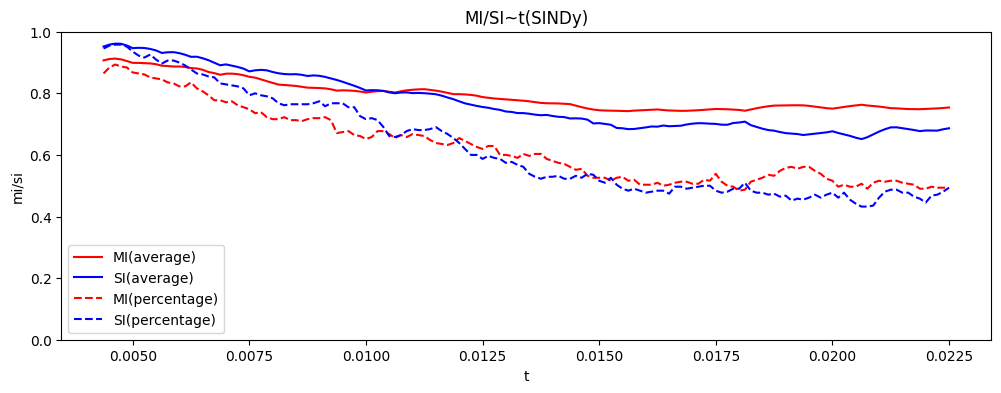

round: 8
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -156.444 1 + -24.862 Vx + 120.759 Vy + 24713.015 t + -29.655 VxVx + 8.706 VyVy + -860155.343 tt + -91.206 VxVy + -1554.787 Vxt + -5166.479 Vyt + -6.029 VxVxVy + 3117.269 VxVxt + -795.845 VyVyt + 5410.317 VxVyt + -50.719 Vx_2 + 109.390 Vy_2 + -311.255 Vx_1 + -33.659 Vy_1 + -88.106 VxVx_2 + -198.899 VxVy_2 + 25089.434 Vxt_2 + -5.898 VyVx_2 + 0.965 VyVy_2 + -905778.414 Vyt_2 + 28.046 tVx_2 + 6916.297 tVy_2 + 9617.322 tt_2 + 4.732 VxVxVx_2 + 701.672 VxVxVy_2 + -3945.632 VxVxt_2 + -1692.005 VyVyVx_2 + 67.552 VyVyVy_2 + -225.097 VyVyt_2 + -18597.191 ttVx_2 + 3.562 ttVy_2 + 62.363 ttt_2 + 611344.173 VxVyVx_2 + -24.204 VxVyVy_2 + -1218.084 VxVyt_2 + 11510.798 VxtVx_2 + -7.300 VxtVy_2 + -250.307 Vxtt_2 + -3451.182 VytVx_2 + 2647.819 VytVy_2 + 11.574 VxVx_1 + -90.582 VxVy_1 + 29113.565 Vxt_1 + -14.661 VyVx_1 + 65.439 VyVy_1 + -672276.913 Vyt_1 + 11.695 tVx_1 + 1190.224 tVy_1 + 5106.816 tt_1 + -0.883 VxVxVx_1 + 1225.345 VxVxVy_1 + -4421.404 VxVxt_1 +

round: 9
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -135.614 1 + -42.363 Vx + 105.934 Vy + 20160.038 t + -18.417 VxVx + 8.345 VyVy + -669350.315 tt + -86.216 VxVy + 136.755 Vxt + -4194.750 Vyt + -1.263 VxVxVy + 2133.722 VxVxt + -649.678 VyVyt + 4599.202 VxVyt + 87.147 Vx_2 + 64.430 Vy_2 + -125.780 Vx_1 + -136.332 Vy_1 + -129.146 VxVx_2 + -332.450 VxVy_2 + 4631.334 Vxt_2 + -17.712 VyVx_2 + 30.803 VyVy_2 + -223632.616 Vyt_2 + 24.792 tVx_2 + 9565.842 tVy_2 + 17188.501 tt_2 + 11.125 VxVxVx_2 + 1424.167 VxVxVy_2 + -5771.053 VxVxt_2 + -1258.116 VyVyVx_2 + 101.703 VyVyVy_2 + -170.784 VyVyt_2 + -12223.829 ttVx_2 + 58.602 ttVy_2 + 31.897 ttt_2 + 391713.921 VxVyVx_2 + -24.290 VxVyVy_2 + -3753.702 VxVyt_2 + 7721.502 VxtVx_2 + -5.114 VxtVy_2 + -4289.424 Vxtt_2 + -1144.341 VytVx_2 + 3126.953 VytVy_2 + 70.838 VxVx_1 + -106.681 VxVy_1 + 569.800 Vxt_1 + 4.920 VyVx_1 + 62.729 VyVy_1 + 305886.271 Vyt_1 + 15.069 tVx_1 + -2590.673 tVy_1 + 5099.614 tt_1 + 4.533 VxVxVx_1 + 68.461 VxVxVy_1 + -3640.500 VxVxt_1 + -

round: 10
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -83.707 1 + -51.719 Vx + 101.195 Vy + 13244.437 t + -3.579 VxVx + 11.371 VyVy + -453477.739 tt + -81.983 VxVy + 1288.980 Vxt + -4013.229 Vyt + 1.427 VxVxVy + 787.730 VxVxt + -892.915 VyVyt + 4167.813 VxVyt + -6.033 Vx_2 + 274.691 Vy_2 + -72.803 Vx_1 + -23.750 Vy_1 + -200.540 VxVx_2 + -433.853 VxVy_2 + 23841.508 Vxt_2 + -8.341 VyVx_2 + 49.342 VyVy_2 + -1023449.991 Vyt_2 + 81.941 tVx_2 + 14052.372 tVy_2 + 25010.538 tt_2 + 11.486 VxVxVx_2 + 136.472 VxVxVy_2 + -7063.400 VxVxt_2 + -6037.301 VyVyVx_2 + 193.416 VyVyVy_2 + -168.482 VyVyt_2 + -44828.783 ttVx_2 + 25.381 ttVy_2 + 37.228 ttt_2 + 1531965.157 VxVyVx_2 + -28.097 VxVyVy_2 + -10645.929 VxVyt_2 + 7264.917 VxtVx_2 + -0.978 VxtVy_2 + -1162.971 Vxtt_2 + -1500.176 VytVx_2 + 3592.940 VytVy_2 + 30.501 VxVx_1 + -161.879 VxVy_1 + -1714.129 Vxt_1 + 9.185 VyVx_1 + 68.706 VyVy_1 + 204441.506 Vyt_1 + 42.689 tVx_1 + -230.517 tVy_1 + 9054.270 tt_1 + 8.389 VxVxVx_1 + -622.158 VxVxVy_1 + -4007.153 VxVxt_1

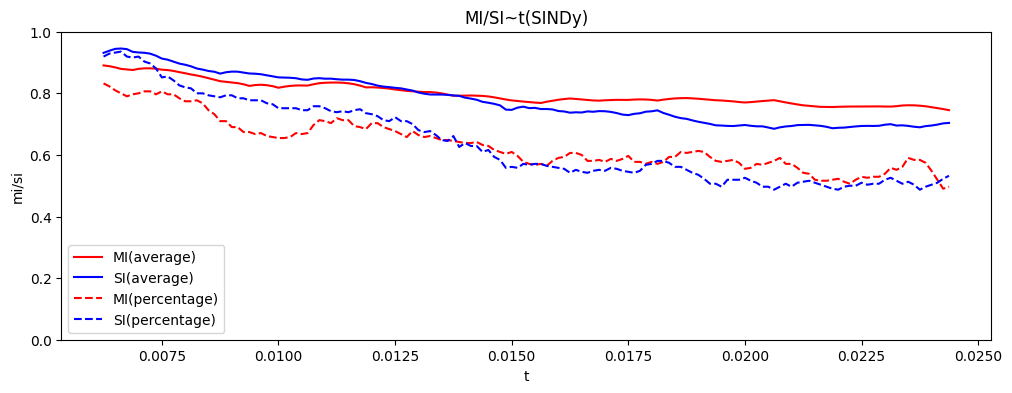

round: 11
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -115.656 1 + -37.971 Vx + 144.109 Vy + 16175.558 t + -3.254 VxVx + 5.090 VyVy + -512563.812 tt + -113.941 VxVy + 589.108 Vxt + -6659.807 Vyt + 3.578 VxVxVy + 685.005 VxVxt + -478.166 VyVyt + 6082.033 VxVyt + -288.029 Vx_2 + 223.100 Vy_2 + -391.805 Vx_1 + -135.292 Vy_1 + -173.235 VxVx_2 + -240.723 VxVy_2 + 60745.084 Vxt_2 + -24.993 VyVx_2 + -20.292 VyVy_2 + -2126080.497 Vyt_2 + 24.563 tVx_2 + 12025.246 tVy_2 + 13349.484 tt_2 + -0.806 VxVxVx_2 + 2238.110 VxVxVy_2 + -2836.377 VxVxt_2 + -2228.362 VyVyVx_2 + 201.272 VyVyVy_2 + -139.449 VyVyt_2 + -39883.052 ttVx_2 + 33.171 ttVy_2 + 30.741 ttt_2 + 1396805.540 VxVyVx_2 + 2.838 VxVyVy_2 + -9022.961 VxVyt_2 + 6313.728 VxtVx_2 + 4.345 VxtVy_2 + -2043.727 Vxtt_2 + -1047.260 VytVx_2 + 587.858 VytVy_2 + 87.651 VxVx_1 + -172.606 VxVy_1 + 45829.515 Vxt_1 + 18.146 VyVx_1 + 69.767 VyVy_1 + -1379637.211 Vyt_1 + 7.517 tVx_1 + -3810.339 tVy_1 + 9977.056 tt_1 + 2.290 VxVxVx_1 + -478.051 VxVxVy_1 + -4222.257 Vx

round: 12
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -188.927 1 + -25.494 Vx + 112.050 Vy + 25470.624 t + 6.009 VxVx + 9.583 VyVy + -790300.178 tt + -95.494 VxVy + 50.864 Vxt + -4363.092 Vyt + 3.804 VxVxVy + 100.214 VxVxt + -902.044 VyVyt + 4811.154 VxVyt + 507.098 Vx_2 + 17.303 Vy_2 + -105.020 Vx_1 + -195.004 Vy_1 + -115.068 VxVx_2 + -284.930 VxVy_2 + -40963.199 Vxt_2 + -0.979 VyVx_2 + 0.722 VyVy_2 + 914336.827 Vyt_2 + 25.070 tVx_2 + 7931.748 tVy_2 + 15634.254 tt_2 + 1.032 VxVxVx_2 + 475.753 VxVxVy_2 + -3991.726 VxVxt_2 + -1875.973 VyVyVx_2 + 142.153 VyVyVy_2 + -140.780 VyVyt_2 + -10414.976 ttVx_2 + 44.494 ttVy_2 + 471796.502 VxVyVx_2 + -9.386 VxVyVy_2 + -5604.933 VxVyt_2 + 5674.797 VxtVx_2 + 6.457 VxtVy_2 + -3564.287 Vxtt_2 + 1008.148 VytVx_2 + 1874.353 VytVy_2 + 83.004 VxVx_1 + -198.904 VxVy_1 + -2607.725 Vxt_1 + 29.950 VyVx_1 + 87.336 VyVy_1 + 425421.150 Vyt_1 + 26.674 tVx_1 + -3727.996 tVy_1 + 10612.919 tt_1 + 6.940 VxVxVx_1 + -1489.295 VxVxVy_1 + -5223.701 VxVxt_1 + -1602.007 VyVyVx_1

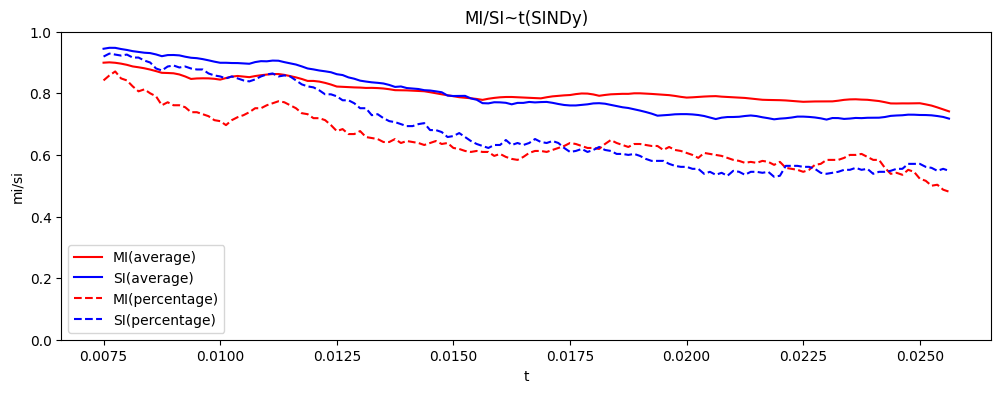

round: 13
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -16.434 1 + -63.891 Vx + 130.975 Vy + 2663.064 t + 22.599 VxVx + 11.559 VyVy + -96418.397 tt + -85.490 VxVy + 1212.338 Vxt + -5113.320 Vyt + -4.818 VxVxVy + -174.537 VxVxt + -1025.389 VyVyt + 4590.026 VxVyt + -4.591 Vx_2 + -174.510 Vy_2 + -446.091 Vx_1 + -425.115 Vy_1 + -53.660 VxVx_2 + -232.484 VxVy_2 + 10886.395 Vxt_2 + 2.450 VyVx_2 + 20.023 VyVy_2 + -320240.969 Vyt_2 + -86.287 tVx_2 + 4313.518 tVy_2 + 13900.613 tt_2 + 3.316 VxVxVx_2 + -10.856 VxVxVy_2 + -5819.677 VxVxt_2 + 3690.268 VyVyVx_2 + 164.527 VyVyVy_2 + -179.523 VyVyt_2 + 12769.899 ttVx_2 + 51.041 ttVy_2 + 63.419 ttt_2 + -158217.001 VxVyVx_2 + -2.130 VxVyVy_2 + -5765.005 VxVyt_2 + 7562.752 VxtVx_2 + 20.022 VxtVy_2 + -4468.864 Vxtt_2 + -3069.072 VytVx_2 + 1466.720 VytVy_2 + 136.301 VxVx_1 + -185.999 VxVy_1 + 46735.421 Vxt_1 + 40.036 VyVx_1 + 69.923 VyVy_1 + -1136296.368 Vyt_1 + 9.658 tVx_1 + -6437.549 tVy_1 + 9634.491 tt_1 + 9.654 VxVxVx_1 + -2078.708 VxVxVy_1 + -4655.131 VxVxt_

round: 14
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -37.521 1 + -49.497 Vx + 114.386 Vy + 5855.352 t + 35.227 VxVx + 4.996 VyVy + -201441.384 tt + -85.851 VxVy + 644.904 Vxt + -4652.269 Vyt + -1.641 VxVxVy + -1244.121 VxVxt + -461.207 VyVyt + 4518.964 VxVyt + 251.223 Vx_2 + -61.451 Vy_2 + -201.430 Vx_1 + -747.246 Vy_1 + -85.642 VxVx_2 + -242.928 VxVy_2 + -14585.158 Vxt_2 + 8.990 VyVx_2 + 33.805 VyVy_2 + 298999.309 Vyt_2 + -10.701 tVx_2 + 6636.366 tVy_2 + 13092.457 tt_2 + 10.371 VxVxVx_2 + -555.084 VxVxVy_2 + -6457.230 VxVxt_2 + -69.454 VyVyVx_2 + 185.568 VyVyVy_2 + -195.475 VyVyt_2 + 2218.728 ttVx_2 + 26.457 ttVy_2 + 48.416 ttt_2 + 76286.526 VxVyVx_2 + -56.809 VxVyVy_2 + -7900.081 VxVyt_2 + 9099.381 VxtVx_2 + 9.065 VxtVy_2 + -2844.336 Vxtt_2 + -2394.996 VytVx_2 + 4854.418 VytVy_2 + 100.815 VxVx_1 + -163.914 VxVy_1 + 13450.377 Vxt_1 + 38.039 VyVx_1 + 69.780 VyVy_1 + -126520.404 Vyt_1 + 14.824 tVx_1 + -3934.874 tVy_1 + 8344.021 tt_1 + 10.921 VxVxVx_1 + -1930.524 VxVxVy_1 + -4540.716 VxVxt_1 

round: 15
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 11.972 1 + -72.046 Vx + 118.944 Vy + 56.909 t + 30.414 VxVx + 7.863 VyVy + -43690.112 tt + -80.360 VxVy + 2219.484 Vxt + -4561.190 Vyt + -0.282 VxVxVy + -924.799 VxVxt + -726.947 VyVyt + 3959.916 VxVyt + 561.857 Vx_2 + 52.672 Vy_2 + -478.399 Vx_1 + -723.074 Vy_1 + 69.376 VxVx_2 + -184.952 VxVy_2 + -47105.279 Vxt_2 + -0.454 VyVx_2 + 2.932 VyVy_2 + 1088431.515 Vyt_2 + -136.858 tVx_2 + -1830.335 tVy_2 + 10565.544 tt_2 + 8.886 VxVxVx_2 + -207.507 VxVxVy_2 + -4631.786 VxVxt_2 + 6153.700 VyVyVx_2 + 203.664 VyVyVy_2 + -167.973 VyVyt_2 + -10551.581 ttVx_2 + 49.636 ttVy_2 + 29.451 ttt_2 + 400284.342 VxVyVx_2 + -2.321 VxVyVy_2 + -8468.620 VxVyt_2 + 7410.555 VxtVx_2 + 9.603 VxtVy_2 + -3564.717 Vxtt_2 + -1411.570 VytVx_2 + 2180.486 VytVy_2 + 116.878 VxVx_1 + -139.261 VxVy_1 + 45165.059 Vxt_1 + 35.548 VyVx_1 + 40.402 VyVy_1 + -985526.450 Vyt_1 + -21.192 tVx_1 + -5383.630 tVy_1 + 6003.740 tt_1 + 16.158 VxVxVx_1 + -2117.632 VxVxVy_1 + -2552.192 VxVxt_1 

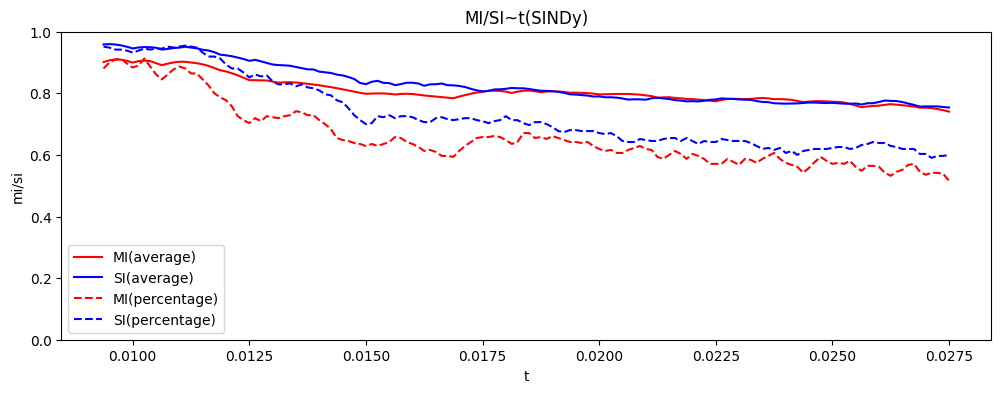

round: 16
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 147.898 1 + -31.534 Vx + 107.414 Vy + -15261.982 t + 43.347 VxVx + 4.486 VyVy + 362576.644 tt + -56.220 VxVy + 21.434 Vxt + -3651.887 Vyt + -3.831 VxVxVy + -1351.990 VxVxt + -650.983 VyVyt + 2916.072 VxVyt + 321.100 Vx_2 + 144.940 Vy_2 + -426.514 Vx_1 + -352.467 Vy_1 + 23.935 VxVx_2 + -167.505 VxVy_2 + -24720.056 Vxt_2 + 6.265 VyVx_2 + -27.087 VyVy_2 + 586211.240 Vyt_2 + -48.683 tVx_2 + 1036.708 tVy_2 + 8622.163 tt_2 + 2.651 VxVxVx_2 + 206.776 VxVxVy_2 + -2743.254 VxVxt_2 + 2851.567 VyVyVx_2 + 192.764 VyVyVy_2 + -73.321 VyVyt_2 + -17526.329 ttVx_2 + 66.238 ttVy_2 + -16.169 ttt_2 + 488567.081 VxVyVx_2 + 67.627 VxVyVy_2 + -8248.646 VxVyt_2 + 3656.492 VxtVx_2 + -23.632 VxtVy_2 + -3521.796 Vxtt_2 + 748.931 VytVx_2 + -653.045 VytVy_2 + 137.348 VxVx_1 + -203.533 VxVy_1 + 42417.354 Vxt_1 + 23.156 VyVx_1 + 38.314 VyVy_1 + -998432.642 Vyt_1 + 6.469 tVx_1 + -6173.857 tVy_1 + 9449.864 tt_1 + 14.985 VxVxVx_1 + -1583.814 VxVxVy_1 + -2480.137 VxVxt_1 +

round: 17
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 112.099 1 + -44.339 Vx + 141.005 Vy + -11303.721 t + 23.746 VxVx + -1.053 VyVy + 256743.587 tt + -91.625 VxVy + 600.435 Vxt + -5459.156 Vyt + -3.973 VxVxVy + -310.993 VxVxt + -330.744 VyVyt + 4641.786 VxVyt + 806.201 Vx_2 + -202.110 Vy_2 + -97.088 Vx_1 + -251.163 Vy_1 + -37.592 VxVx_2 + -146.563 VxVy_2 + -78818.818 Vxt_2 + -29.726 VyVx_2 + -15.839 VyVy_2 + 1996357.540 Vyt_2 + -92.703 tVx_2 + 3575.493 tVy_2 + 8601.040 tt_2 + -3.018 VxVxVx_2 + 1845.760 VxVxVy_2 + -3023.059 VxVxt_2 + 4678.198 VyVyVx_2 + 290.223 VyVyVy_2 + -147.010 VyVyt_2 + 21023.686 ttVx_2 + 99.086 ttVy_2 + -17.637 ttt_2 + -499065.128 VxVyVx_2 + 50.822 VxVyVy_2 + -12705.978 VxVyt_2 + 6357.495 VxtVx_2 + -0.390 VxtVy_2 + -6185.821 Vxtt_2 + 890.102 VytVx_2 + -18.969 VytVy_2 + 57.823 VxVx_1 + -227.461 VxVy_1 + 6343.808 Vxt_1 + 4.805 VyVx_1 + 54.822 VyVy_1 + -48148.933 Vyt_1 + -20.365 tVx_1 + -2170.571 tVy_1 + 11264.068 tt_1 + 7.490 VxVxVx_1 + -464.799 VxVxVy_1 + -3383.219 VxVxt

round: 18
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 72.879 1 + -6.421 Vx + 136.765 Vy + -6769.005 t + 49.321 VxVx + -7.428 VyVy + 136559.951 tt + -90.223 VxVy + -1013.026 Vxt + -5451.531 Vyt + 5.054 VxVxVy + -1779.044 VxVxt + -11.123 VyVyt + 4081.149 VxVyt + 780.140 Vx_2 + -139.474 Vy_2 + -548.535 Vx_1 + 135.294 Vy_1 + 138.187 VxVx_2 + -7.163 VxVy_2 + -69188.796 Vxt_2 + -5.034 VyVx_2 + -115.589 VyVy_2 + 1620051.273 Vyt_2 + -246.933 tVx_2 + -5216.777 tVy_2 + 1010.273 tt_2 + 14.515 VxVxVx_2 + 225.699 VxVxVy_2 + 2082.729 VxVxt_2 + 11724.454 VyVyVx_2 + 188.081 VyVyVy_2 + -222.084 VyVyt_2 + 13365.861 ttVx_2 + 110.318 ttVy_2 + 4.762 ttt_2 + -292801.139 VxVyVx_2 + 142.114 VxVyVy_2 + -8112.186 VxVyt_2 + 10327.637 VxtVx_2 + -16.583 VxtVy_2 + -5737.389 Vxtt_2 + -204.622 VytVx_2 + -4106.355 VytVy_2 + -18.704 VxVx_1 + -83.348 VxVy_1 + 52327.585 Vxt_1 + 46.669 VyVx_1 + 7.858 VyVy_1 + -1159986.000 Vyt_1 + 0.203 tVx_1 + -92.198 tVy_1 + 3682.450 tt_1 + 7.648 VxVxVx_1 + -1816.469 VxVxVy_1 + -992.890 VxVxt_

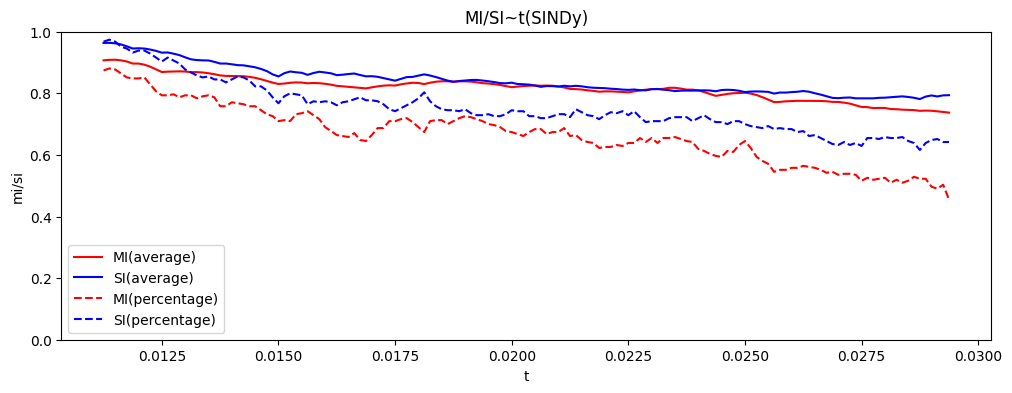

round: 19
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 143.084 1 + 32.987 Vx + 68.172 Vy + -12732.557 t + -15.666 VxVx + 17.737 VyVy + 256783.504 tt + -91.497 VxVy + -2680.269 Vxt + -2426.388 Vyt + 2.691 VxVxVy + 931.515 VxVxt + -1038.847 VyVyt + 4487.451 VxVyt + 437.091 Vx_2 + -118.009 Vy_2 + -932.245 Vx_1 + 153.477 Vy_1 + 6.116 VxVx_2 + -191.262 VxVy_2 + -34083.145 Vxt_2 + 40.885 VyVx_2 + -64.931 VyVy_2 + 802444.168 Vyt_2 + -18.286 tVx_2 + 1144.760 tVy_2 + 9203.304 tt_2 + 8.880 VxVxVx_2 + -1901.647 VxVxVy_2 + -1056.500 VxVxt_2 + 754.379 VyVyVx_2 + 255.383 VyVyVy_2 + -99.918 VyVyt_2 + 11790.986 ttVx_2 + -44.717 ttVy_2 + -5.696 ttt_2 + -267807.060 VxVyVx_2 + 45.474 VxVyVy_2 + -10365.712 VxVyt_2 + 4809.352 VxtVx_2 + -15.687 VxtVy_2 + 1873.388 Vxtt_2 + 224.645 VytVx_2 + 567.923 VytVy_2 + 95.634 VxVx_1 + -89.668 VxVy_1 + 84053.555 Vxt_1 + 41.971 VyVx_1 + 37.024 VyVy_1 + -1764986.509 Vyt_1 + -9.136 tVx_1 + -4226.502 tVy_1 + 4170.478 tt_1 + 11.720 VxVxVx_1 + -2103.665 VxVxVy_1 + -2703.167 VxVxt_1 

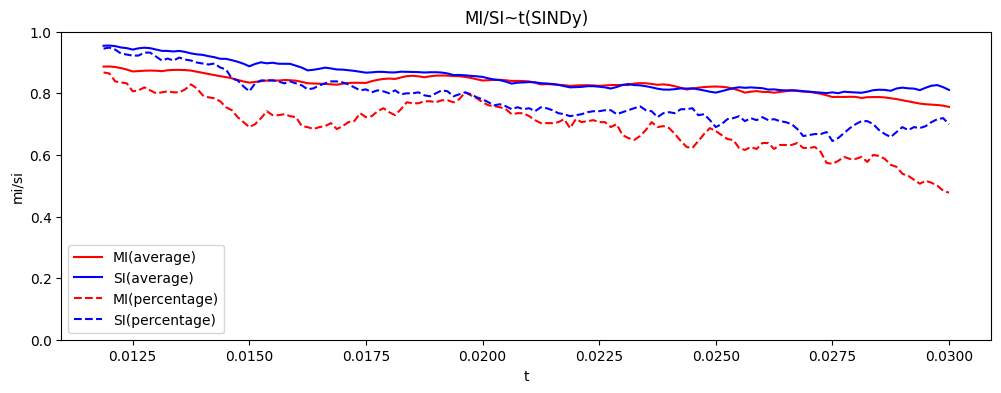

round: 20
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -39.559 1 + 13.582 Vx + 70.743 Vy + 4992.756 t + 21.980 VxVx + 4.045 VyVy + -153449.713 tt + -42.558 VxVy + -1340.569 Vxt + -2434.190 Vyt + 0.253 VxVxVy + -915.000 VxVxt + -573.226 VyVyt + 2153.593 VxVyt + 747.322 Vx_2 + -269.748 Vy_2 + -572.171 Vx_1 + 134.372 Vy_1 + -1.329 VxVx_2 + 122.577 VxVy_2 + -67198.962 Vxt_2 + 29.206 VyVx_2 + -132.281 VyVy_2 + 1580498.695 Vyt_2 + -67.225 tVx_2 + 2075.899 tVy_2 + -4248.821 tt_2 + -3.932 VxVxVx_2 + -812.010 VxVxVy_2 + 3060.150 VxVxt_2 + 2284.654 VyVyVx_2 + 120.433 VyVyVy_2 + -236.591 VyVyt_2 + 22138.229 ttVx_2 + 28.438 ttVy_2 + 0.133 ttt_2 + -433289.313 VxVyVx_2 + 94.946 VxVyVy_2 + -4233.043 VxVyt_2 + 11141.201 VxtVx_2 + -1.896 VxtVy_2 + -1436.141 Vxtt_2 + 41.447 VytVx_2 + -3086.485 VytVy_2 + 140.926 VxVx_1 + -41.042 VxVy_1 + 54605.339 Vxt_1 + 49.953 VyVx_1 + -27.532 VyVy_1 + -1239534.455 Vyt_1 + -97.563 tVx_1 + -6265.817 tVy_1 + 2281.213 tt_1 + 9.510 VxVxVx_1 + -2561.053 VxVxVy_1 + 759.846 VxVxt_1 

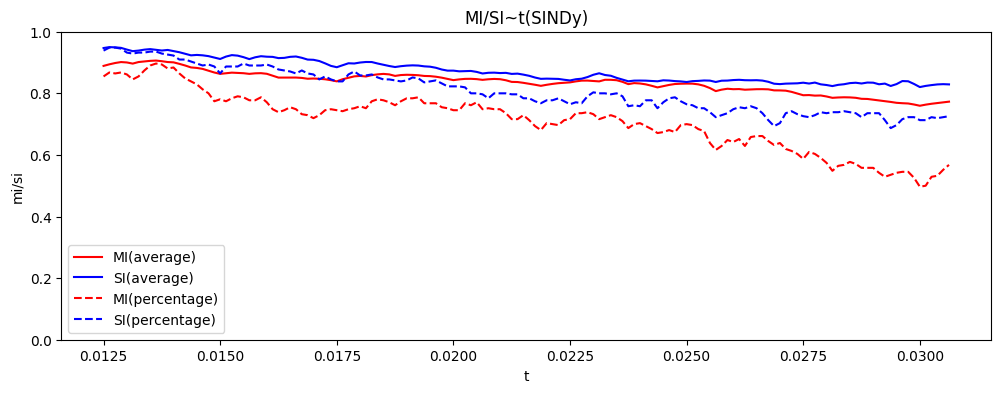

round: 21
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -70.981 1 + 40.301 Vx + 41.968 Vy + 7641.939 t + -0.895 VxVx + 16.926 VyVy + -205011.351 tt + -51.259 VxVy + -2723.681 Vxt + -1166.966 Vyt + 0.155 VxVxVy + 86.105 VxVxt + -1157.233 VyVyt + 2778.665 VxVyt + 491.814 Vx_2 + -267.874 Vy_2 + -217.487 Vx_1 + 99.071 Vy_1 + 104.660 VxVx_2 + 67.018 VxVy_2 + -41701.693 Vxt_2 + 79.096 VyVx_2 + -210.117 VyVy_2 + 954275.318 Vyt_2 + -83.348 tVx_2 + -2598.074 tVy_2 + -2096.353 tt_2 + -4.178 VxVxVx_2 + -2785.768 VxVxVy_2 + 6515.582 VxVxt_2 + 3376.940 VyVyVx_2 + 175.335 VyVyVy_2 + -183.357 VyVyt_2 + 25318.446 ttVx_2 + 42.647 ttVy_2 + 34.308 ttt_2 + -579240.294 VxVyVx_2 + 35.630 VxVyVy_2 + -7505.721 VxVyt_2 + 8310.465 VxtVx_2 + -7.184 VxtVy_2 + -2102.087 Vxtt_2 + -1208.002 VytVx_2 + -64.981 VytVy_2 + 101.802 VxVx_1 + -61.223 VxVy_1 + 20672.678 Vxt_1 + 46.544 VyVx_1 + -76.936 VyVy_1 + -475482.825 Vyt_1 + -58.509 tVx_1 + -4110.447 tVy_1 + 3155.085 tt_1 + 8.676 VxVxVx_1 + -2163.346 VxVxVy_1 + 2895.492 VxVxt_1

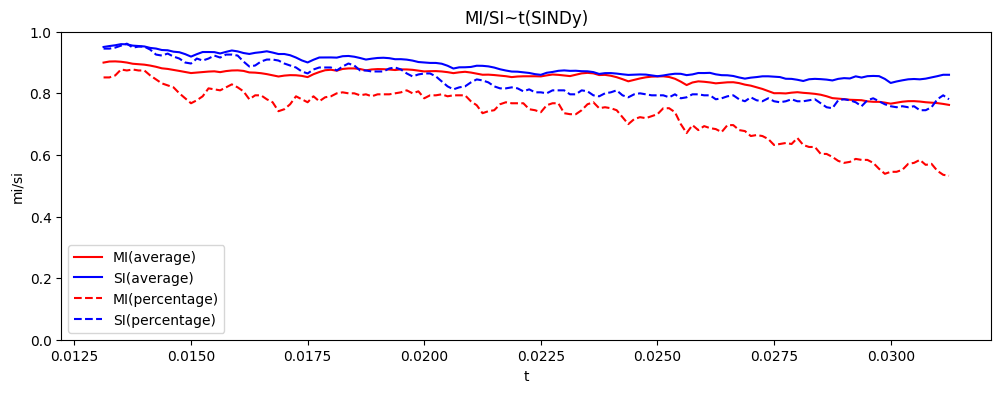

round: 22
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 140.730 1 + 38.018 Vx + -5.407 Vy + -11456.488 t + -20.280 VxVx + 22.465 VyVy + 208069.913 tt + -0.241 VxVy + -2390.168 Vxt + 899.255 Vyt + -1.890 VxVxVy + 895.284 VxVxt + -1325.530 VyVyt + 455.126 VxVyt + 157.482 Vx_2 + -428.582 Vy_2 + -540.670 Vx_1 + 90.842 Vy_1 + 10.124 VxVx_2 + -52.106 VxVy_2 + -5673.217 Vxt_2 + 57.147 VyVx_2 + -140.036 VyVy_2 + 51339.261 Vyt_2 + 28.916 tVx_2 + 1069.507 tVy_2 + 2389.444 tt_2 + -8.980 VxVxVx_2 + -1846.570 VxVxVy_2 + 3923.341 VxVxt_2 + -1391.653 VyVyVx_2 + 255.626 VyVyVy_2 + -52.106 VyVyt_2 + 40904.663 ttVx_2 + -6.715 ttVy_2 + -9.469 ttt_2 + -952349.979 VxVyVx_2 + -31.105 VxVyVy_2 + -10412.827 VxVyt_2 + 3069.034 VxtVx_2 + -7.629 VxtVy_2 + 625.693 Vxtt_2 + 539.394 VytVx_2 + 2337.038 VytVy_2 + 88.666 VxVx_1 + -135.573 VxVy_1 + 44449.004 Vxt_1 + 22.170 VyVx_1 + 20.354 VyVy_1 + -882219.026 Vyt_1 + 25.035 tVx_1 + -3304.930 tVy_1 + 6220.243 tt_1 + 6.419 VxVxVx_1 + -1359.644 VxVxVy_1 + -1145.800 VxVxt_1 + -129

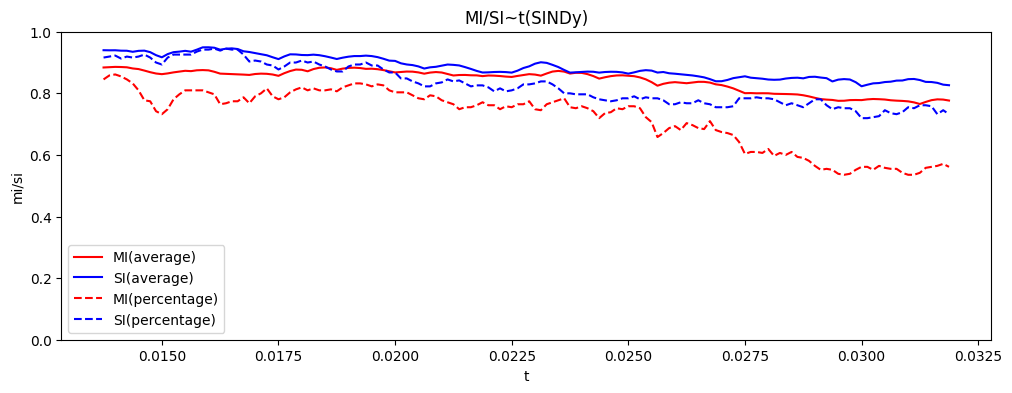

round: 23
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 257.261 1 + 71.226 Vx + -13.462 Vy + -21981.232 t + -11.995 VxVx + 27.150 VyVy + 434456.754 tt + 11.644 VxVy + -3704.104 Vxt + 992.222 Vyt + -1.274 VxVxVy + 408.471 VxVxt + -1397.435 VyVyt + 18.260 VxVyt + -89.262 Vx_2 + -290.703 Vy_2 + -306.391 Vx_1 + -313.960 Vy_1 + -4.815 VxVx_2 + -28.542 VxVy_2 + 14851.879 Vxt_2 + 35.719 VyVx_2 + -170.898 VyVy_2 + -343968.602 Vyt_2 + -1.342 tVx_2 + 1363.555 tVy_2 + 2774.059 tt_2 + -3.533 VxVxVx_2 + -1257.226 VxVxVy_2 + 4146.531 VxVxt_2 + 108.674 VyVyVx_2 + 72.801 VyVyVy_2 + 20.239 VyVyt_2 + 27273.630 ttVx_2 + 39.686 ttVy_2 + -50.431 ttt_2 + -621103.817 VxVyVx_2 + -14.644 VxVyVy_2 + -2862.637 VxVyt_2 + -226.930 VxtVx_2 + 5.669 VxtVy_2 + -1715.453 Vxtt_2 + 2260.065 VytVx_2 + 1802.269 VytVy_2 + 127.128 VxVx_1 + 27.645 VxVy_1 + 29850.577 Vxt_1 + 18.447 VyVx_1 + -84.132 VyVy_1 + -673623.563 Vyt_1 + -12.161 tVx_1 + -4647.185 tVy_1 + -862.527 tt_1 + 6.868 VxVxVx_1 + -1192.187 VxVxVy_1 + 3057.987 VxVxt_1 + 20

round: 24
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 169.575 1 + 42.747 Vx + -39.940 Vy + -13729.070 t + 1.831 VxVx + 20.275 VyVy + 252358.316 tt + 18.265 VxVy + -2162.240 Vxt + 2338.541 Vyt + -0.214 VxVxVy + -221.059 VxVxt + -1268.685 VyVyt + -335.581 VxVyt + 362.298 Vx_2 + -339.967 Vy_2 + -39.272 Vx_1 + 528.488 Vy_1 + 26.667 VxVx_2 + 98.204 VxVy_2 + -21466.789 Vxt_2 + 32.563 VyVx_2 + -224.486 VyVy_2 + 353360.521 Vyt_2 + -3.683 tVx_2 + -407.609 tVy_2 + -3592.828 tt_2 + -0.843 VxVxVx_2 + -1135.853 VxVxVy_2 + 6917.153 VxVxt_2 + 439.878 VyVyVx_2 + -34.076 VyVyVy_2 + -40.081 VyVyt_2 + 29718.358 ttVx_2 + 51.336 ttVy_2 + -21.195 ttt_2 + -639491.366 VxVyVx_2 + 40.360 VxVyVy_2 + 1886.179 VxVyt_2 + 1703.260 VxtVx_2 + 3.722 VxtVy_2 + -2183.407 Vxtt_2 + 1221.398 VytVx_2 + -564.079 VytVy_2 + 176.655 VxVx_1 + -29.553 VxVy_1 + -404.816 Vxt_1 + 3.640 VyVx_1 + -49.440 VyVy_1 + 102579.251 Vyt_1 + -109.287 tVx_1 + -6815.888 tVy_1 + 985.238 tt_1 + 12.579 VxVxVx_1 + -779.056 VxVxVy_1 + 1788.115 VxVxt_1 + 4488

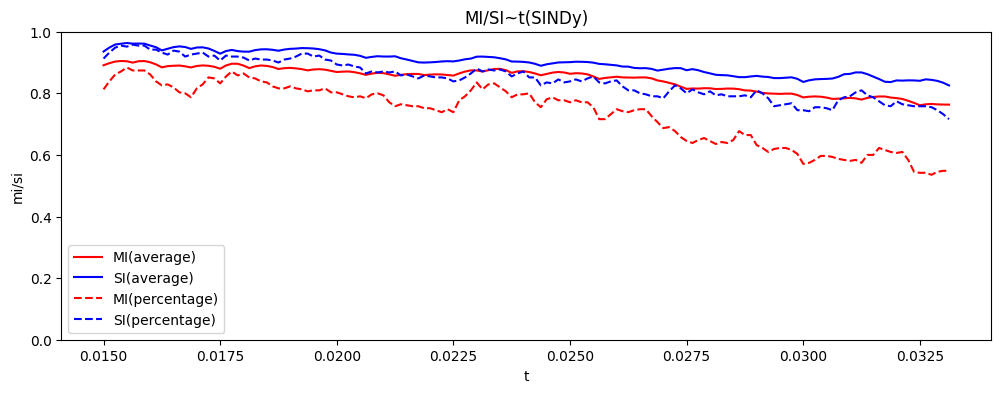

round: 25
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 315.029 1 + -19.480 Vx + -34.448 Vy + -25717.364 t + 26.193 VxVx + 38.702 VyVy + 491166.142 tt + 34.993 VxVy + 439.482 Vxt + 1837.989 Vyt + 1.620 VxVxVy + -1320.201 VxVxt + -1886.078 VyVyt + -1047.858 VxVyt + 664.852 Vx_2 + -249.425 Vy_2 + 272.835 Vx_1 + 35.415 Vy_1 + 80.353 VxVx_2 + 103.899 VxVy_2 + -49062.319 Vxt_2 + 23.367 VyVx_2 + -261.949 VyVy_2 + 958471.291 Vyt_2 + -80.818 tVx_2 + -2476.968 tVy_2 + -3503.106 tt_2 + 1.447 VxVxVx_2 + -735.368 VxVxVy_2 + 8150.021 VxVxt_2 + 3751.976 VyVyVx_2 + -55.515 VyVyVy_2 + 85.808 VyVyt_2 + 21538.947 ttVx_2 + 38.635 ttVy_2 + -33.796 ttt_2 + -463793.347 VxVyVx_2 + 48.012 VxVyVy_2 + 1567.883 VxVyt_2 + -2986.235 VxtVx_2 + -1.445 VxtVy_2 + -1236.363 Vxtt_2 + 1666.892 VytVx_2 + -421.534 VytVy_2 + 197.761 VxVx_1 + 73.969 VxVy_1 + -15839.036 Vxt_1 + 23.659 VyVx_1 + -170.128 VyVy_1 + 199761.567 Vyt_1 + -90.163 tVx_1 + -8107.684 tVy_1 + -3656.891 tt_1 + 12.933 VxVxVx_1 + -1579.812 VxVxVy_1 + 7064.211 VxVxt_

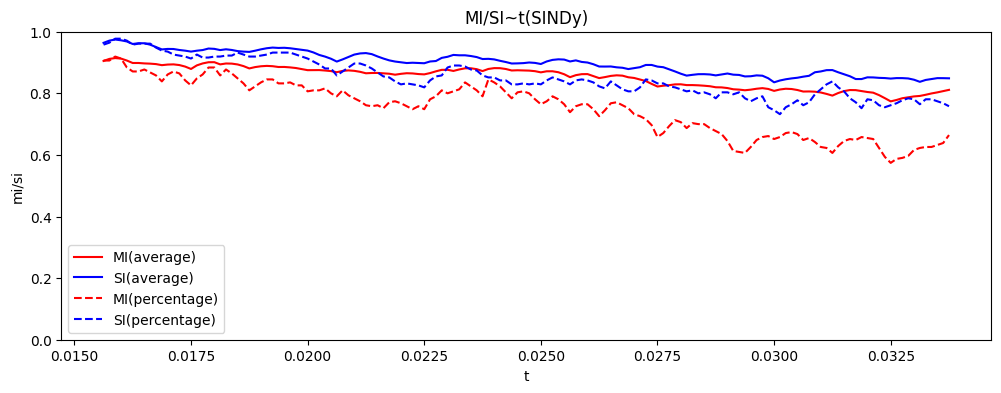

round: 26
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 332.493 1 + -88.198 Vx + -41.088 Vy + -26324.151 t + 10.649 VxVx + 16.169 VyVy + 488161.633 tt + 78.451 VxVy + 2836.800 Vxt + 2075.413 Vyt + -3.627 VxVxVy + -443.293 VxVxt + -1021.349 VyVyt + -2696.995 VxVyt + 54.731 Vx_2 + -769.504 Vy_2 + -483.097 Vx_1 + -302.029 Vy_1 + 112.925 VxVx_2 + 76.197 VxVy_2 + 5754.812 Vxt_2 + -14.368 VyVx_2 + -238.871 VyVy_2 + -202309.521 Vyt_2 + -70.381 tVx_2 + -4043.542 tVy_2 + -2092.278 tt_2 + 7.620 VxVxVx_2 + 418.044 VxVxVy_2 + 6911.207 VxVxt_2 + 4007.041 VyVyVx_2 + 43.630 VyVyVy_2 + 116.253 VyVyt_2 + 62939.244 ttVx_2 + 74.978 ttVy_2 + -112.051 ttt_2 + -1252757.832 VxVyVx_2 + -13.576 VxVyVy_2 + -1987.776 VxVyt_2 + -3911.092 VxtVx_2 + -6.629 VxtVy_2 + -3061.089 Vxtt_2 + 4478.104 VytVx_2 + 1749.925 VytVy_2 + 332.129 VxVx_1 + 187.168 VxVy_1 + 49541.550 Vxt_1 + -6.347 VyVx_1 + -173.147 VyVy_1 + -1130618.169 Vyt_1 + -93.225 tVx_1 + -12609.985 tVy_1 + -7416.458 tt_1 + 10.166 VxVxVx_1 + -363.521 VxVxVy_1 + 6212.06

round: 27
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 314.689 1 + -108.288 Vx + -31.070 Vy + -25286.128 t + 51.644 VxVx + -6.061 VyVy + 474156.131 tt + 70.660 VxVy + 3271.925 Vxt + 1527.459 Vyt + -4.662 VxVxVy + -1713.746 VxVxt + -134.807 VyVyt + -2233.805 VxVyt + -416.944 Vx_2 + -438.408 Vy_2 + 214.931 Vx_1 + -1244.030 Vy_1 + 317.066 VxVx_2 + 213.289 VxVy_2 + 40509.881 Vxt_2 + -31.443 VyVx_2 + -266.085 VyVy_2 + -808484.153 Vyt_2 + -191.515 tVx_2 + -10917.087 tVy_2 + -8635.984 tt_2 + 7.396 VxVxVx_2 + 954.620 VxVxVy_2 + 8571.230 VxVxt_2 + 8183.358 VyVyVx_2 + 124.537 VyVyVy_2 + 60.560 VyVyt_2 + 31341.392 ttVx_2 + 49.741 ttVy_2 + -22.401 ttt_2 + -550699.775 VxVyVx_2 + 18.069 VxVyVy_2 + -4390.824 VxVyt_2 + -2040.191 VxtVx_2 + -1.629 VxtVy_2 + -2419.176 Vxtt_2 + 1244.418 VytVx_2 + -66.219 VytVy_2 + 231.148 VxVx_1 + 20.021 VxVy_1 + -11298.507 Vxt_1 + -35.255 VyVx_1 + -80.929 VyVy_1 + 122748.527 Vyt_1 + -138.232 tVx_1 + -8785.274 tVy_1 + -1401.645 tt_1 + 17.335 VxVxVx_1 + 400.490 VxVxVy_1 + 3179.17

round: 28
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 21.612 1 + -31.917 Vx + -31.643 Vy + -1630.151 t + 24.787 VxVx + -17.943 VyVy + 15018.696 tt + 508.353 Vxt + 1353.969 Vyt + 8.027 VxVxVy + -1085.784 VxVxt + 268.121 VyVyt + 468.773 VxVyt + -375.176 Vx_2 + -854.341 Vy_2 + -273.304 Vx_1 + 218.164 Vy_1 + 291.482 VxVx_2 + 189.514 VxVy_2 + 34907.589 Vxt_2 + 3.909 VyVx_2 + -213.847 VyVy_2 + -679200.788 Vyt_2 + -98.646 tVx_2 + -8933.487 tVy_2 + -6320.384 tt_2 + 9.582 VxVxVx_2 + -276.292 VxVxVy_2 + 6342.679 VxVxt_2 + 3887.939 VyVyVx_2 + -152.129 VyVyVy_2 + 101.554 VyVyt_2 + 67866.038 ttVx_2 + -24.601 ttVy_2 + -17.683 ttt_2 + -1315814.514 VxVyVx_2 + 41.533 VxVyVy_2 + 5820.133 VxVyt_2 + -3897.825 VxtVx_2 + -9.745 VxtVy_2 + 1193.030 Vxtt_2 + 1106.666 VytVx_2 + -1504.061 VytVy_2 + 186.813 VxVx_1 + 102.346 VxVy_1 + 17499.241 Vxt_1 + -13.834 VyVx_1 + -48.344 VyVy_1 + -257906.518 Vyt_1 + -116.463 tVx_1 + -6865.108 tVy_1 + -3704.954 tt_1 + 15.533 VxVxVx_1 + -198.012 VxVxVy_1 + 1628.743 VxVxt_1 + 4354.104

round: 29
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 142.503 1 + -94.018 Vx + 6.500 Vy + -10560.721 t + 41.720 VxVx + -28.209 VyVy + 174824.312 tt + 62.645 VxVy + 2811.723 Vxt + 88.760 Vyt + 0.662 VxVxVy + -1609.205 VxVxt + 670.148 VyVyt + -2052.522 VxVyt + -353.546 Vx_2 + 619.702 Vy_2 + -310.613 Vx_1 + -334.795 Vy_1 + 142.402 VxVx_2 + 261.722 VxVy_2 + 36187.877 Vxt_2 + -63.839 VyVx_2 + -223.178 VyVy_2 + -745743.447 Vyt_2 + -114.843 tVx_2 + -3983.479 tVy_2 + -9326.133 tt_2 + 6.737 VxVxVx_2 + 1974.994 VxVxVy_2 + 6720.090 VxVxt_2 + 4247.932 VyVyVx_2 + -281.591 VyVyVy_2 + 0.722 VyVyt_2 + -47960.565 ttVx_2 + 144.026 ttVy_2 + 15.595 ttt_2 + 882833.028 VxVyVx_2 + 145.700 VxVyVy_2 + 10253.960 VxVyt_2 + 184.742 VxtVx_2 + -10.914 VxtVy_2 + -4414.515 Vxtt_2 + -41.133 VytVx_2 + -4789.099 VytVy_2 + 223.766 VxVx_1 + 165.521 VxVy_1 + 25220.615 Vxt_1 + -39.117 VyVx_1 + -96.445 VyVy_1 + -474293.071 Vyt_1 + -182.288 tVx_1 + -8124.371 tVy_1 + -6127.230 tt_1 + 15.248 VxVxVx_1 + 580.419 VxVxVy_1 + 3469.466 VxV

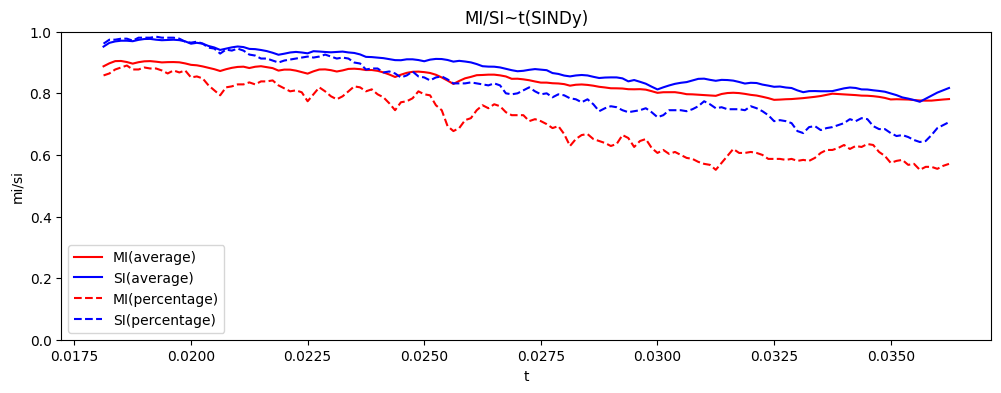

round: 30
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -3.749 1 + -52.050 Vx + 15.650 Vy + 458.080 t + 20.940 VxVx + -20.136 VyVy + -25519.287 tt + 50.939 VxVy + 1441.232 Vxt + -296.661 Vyt + 5.636 VxVxVy + -1082.858 VxVxt + 355.433 VyVyt + -1752.186 VxVyt + -34.882 Vx_2 + -733.469 Vy_2 + 71.217 Vx_1 + 346.576 Vy_1 + 252.715 VxVx_2 + 177.206 VxVy_2 + 4915.638 Vxt_2 + 9.801 VyVx_2 + -216.668 VyVy_2 + -55633.954 Vyt_2 + -138.179 tVx_2 + -7310.722 tVy_2 + -6412.237 tt_2 + 0.271 VxVxVx_2 + -245.901 VxVxVy_2 + 6555.697 VxVxt_2 + 4268.218 VyVyVx_2 + -175.085 VyVyVy_2 + 108.660 VyVyt_2 + 56455.518 ttVx_2 + 14.813 ttVy_2 + -23.675 ttt_2 + -1057106.267 VxVyVx_2 + 175.750 VxVyVy_2 + 6644.994 VxVyt_2 + -4057.735 VxtVx_2 + 5.868 VxtVy_2 + -795.769 Vxtt_2 + 1315.649 VytVx_2 + -6063.050 VytVy_2 + 169.615 VxVx_1 + 141.763 VxVy_1 + -8214.690 Vxt_1 + -11.216 VyVx_1 + -90.413 VyVy_1 + 211896.435 Vyt_1 + -120.460 tVx_1 + -6944.050 tVy_1 + -4675.711 tt_1 + 11.738 VxVxVx_1 + -219.876 VxVxVy_1 + 3219.320 VxVxt_1 +

round: 31
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 180.613 1 + -182.928 Vx + -14.198 Vy + -12545.661 t + 68.448 VxVx + -14.027 VyVy + 198450.685 tt + 96.403 VxVy + 5673.371 Vxt + 908.736 Vyt + 2.303 VxVxVy + -2508.942 VxVxt + 155.121 VyVyt + -3149.085 VxVyt + -23.249 Vx_2 + -173.485 Vy_2 + -731.286 Vx_1 + -679.061 Vy_1 + 258.166 VxVx_2 + 235.211 VxVy_2 + 10670.475 Vxt_2 + -64.310 VyVx_2 + -259.897 VyVy_2 + -263937.566 Vyt_2 + -230.582 tVx_2 + -7564.725 tVy_2 + -7788.712 tt_2 + 4.754 VxVxVx_2 + 2020.202 VxVxVy_2 + 8046.828 VxVxt_2 + 7949.941 VyVyVx_2 + -262.843 VyVyVy_2 + 21.207 VyVyt_2 + 16922.773 ttVx_2 + 84.509 ttVy_2 + 15.741 ttt_2 + -390199.749 VxVyVx_2 + 207.326 VxVyVy_2 + 9181.116 VxVyt_2 + -861.766 VxtVx_2 + -0.894 VxtVy_2 + -2675.882 Vxtt_2 + -7.110 VytVx_2 + -7394.429 VytVy_2 + 257.013 VxVx_1 + 276.716 VxVy_1 + 50565.939 Vxt_1 + 4.670 VyVx_1 + -80.406 VyVy_1 + -846461.644 Vyt_1 + -114.838 tVx_1 + -9431.527 tVy_1 + -9681.896 tt_1 + 13.604 VxVxVx_1 + -842.902 VxVxVy_1 + 3016.891 Vx

round: 32
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 369.382 1 + -114.462 Vx + -41.847 Vy + -26103.578 t + 66.168 VxVx + 8.279 VyVy + 434785.439 tt + 100.608 VxVy + 3456.908 Vxt + 1998.144 Vyt + -0.214 VxVxVy + -2307.112 VxVxt + -699.466 VyVyt + -3440.827 VxVyt + -106.103 Vx_2 + 648.939 Vy_2 + -1118.658 Vx_1 + -383.037 Vy_1 + 181.849 VxVx_2 + 78.284 VxVy_2 + 15217.255 Vxt_2 + -49.814 VyVx_2 + -60.742 VyVy_2 + -327005.857 Vyt_2 + -34.183 tVx_2 + -5739.148 tVy_2 + -2714.082 tt_2 + 6.680 VxVxVx_2 + 1401.370 VxVxVy_2 + 1092.753 VxVxt_2 + 1400.262 VyVyVx_2 + -166.737 VyVyVy_2 + 12.520 VyVyt_2 + -42539.410 ttVx_2 + -11.396 ttVy_2 + 30.624 ttt_2 + 662532.780 VxVyVx_2 + -72.519 VxVyVy_2 + 5110.708 VxVyt_2 + -676.940 VxtVx_2 + -4.344 VxtVy_2 + 810.590 Vxtt_2 + -413.698 VytVx_2 + 3288.391 VytVy_2 + 134.163 VxVx_1 + 100.563 VxVy_1 + 74593.959 Vxt_1 + -16.001 VyVx_1 + 16.136 VyVy_1 + -1202678.912 Vyt_1 + -39.979 tVx_1 + -5823.583 tVy_1 + -4196.839 tt_1 + 14.814 VxVxVx_1 + -204.118 VxVxVy_1 + -67.808 Vx

round: 33
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 103.049 1 + -8.883 Vx + 10.466 Vy + -7965.979 t + -13.628 VxVx + -10.779 VyVy + 133127.987 tt + 15.759 VxVy + 173.917 Vxt + 70.896 Vyt + 8.448 VxVxVy + 99.642 VxVxt + -30.200 VyVyt + -405.938 VxVyt + 649.725 Vx_2 + -67.777 Vy_2 + 274.816 Vx_1 + -131.256 Vy_1 + 108.663 VxVx_2 + 137.342 VxVy_2 + -35128.691 Vxt_2 + -4.274 VyVx_2 + -177.654 VyVy_2 + 499297.044 Vyt_2 + -17.594 tVx_2 + -2895.504 tVy_2 + -4528.012 tt_2 + 1.101 VxVxVx_2 + 243.287 VxVxVy_2 + 5016.592 VxVxt_2 + 668.070 VyVyVx_2 + -189.747 VyVyVy_2 + 108.889 VyVyt_2 + 4526.842 ttVx_2 + -60.316 ttVy_2 + 18.587 ttt_2 + -92194.896 VxVyVx_2 + 139.090 VxVyVy_2 + 6342.511 VxVyt_2 + -4010.937 VxtVx_2 + -10.642 VxtVy_2 + 2390.446 Vxtt_2 + -63.255 VytVx_2 + -4592.500 VytVy_2 + 50.348 VxVx_1 + 47.477 VxVy_1 + -16591.344 Vxt_1 + -1.226 VyVx_1 + -44.061 VyVy_1 + 260470.178 Vyt_1 + -29.840 tVx_1 + -2583.258 tVy_1 + -2546.606 tt_1 + 14.443 VxVxVx_1 + -497.585 VxVxVy_1 + 1993.340 VxVxt_1 + 1740.50

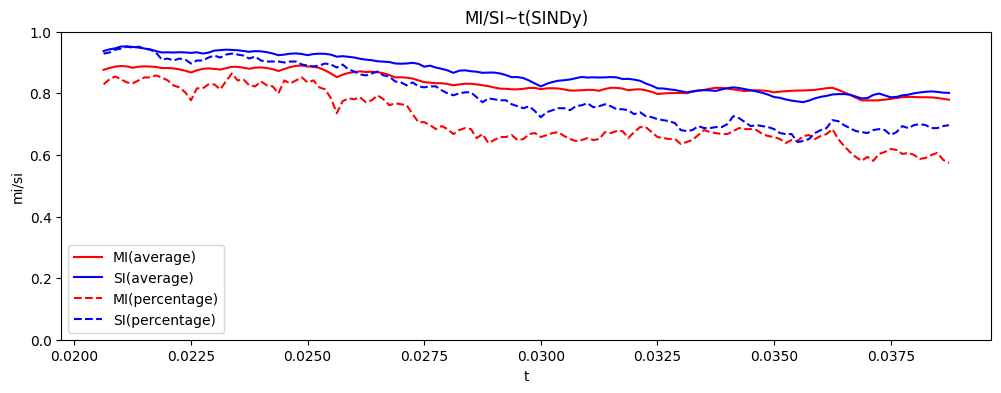

round: 34
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 292.844 1 + -103.467 Vx + -46.407 Vy + -21487.093 t + -3.036 VxVx + 0.868 VyVy + 366377.026 tt + 52.918 VxVy + 3173.554 Vxt + 2118.158 Vyt + 2.997 VxVxVy + -54.680 VxVxt + -317.173 VyVyt + -1432.268 VxVyt + -980.618 Vx_2 + -287.646 Vy_2 + -993.133 Vx_1 + -603.453 Vy_1 + 2.253 VxVx_2 + -64.571 VxVy_2 + 72202.910 Vxt_2 + 7.637 VyVx_2 + -132.175 VyVy_2 + -1236942.859 Vyt_2 + 64.031 tVx_2 + -34.739 tVy_2 + 1171.319 tt_2 + 5.005 VxVxVx_2 + -143.297 VxVxVy_2 + 4104.648 VxVxt_2 + -804.258 VyVyVx_2 + 1.027 VyVyVy_2 + 29.138 VyVyt_2 + 18598.677 ttVx_2 + -92.398 ttVy_2 + 6.879 ttt_2 + -310832.315 VxVyVx_2 + 132.663 VxVyVy_2 + 770.240 VxVyt_2 + -1049.644 VxtVx_2 + -13.424 VxtVy_2 + 3103.927 Vxtt_2 + 237.666 VytVx_2 + -4509.541 VytVy_2 + -31.424 VxVx_1 + 95.406 VxVy_1 + 66570.811 Vxt_1 + -14.123 VyVx_1 + -66.997 VyVy_1 + -1081156.935 Vyt_1 + -30.872 tVx_1 + 476.242 tVy_1 + -4218.856 tt_1 + 14.106 VxVxVx_1 + -11.501 VxVxVy_1 + 2874.394 VxVxt_1 + 1923.

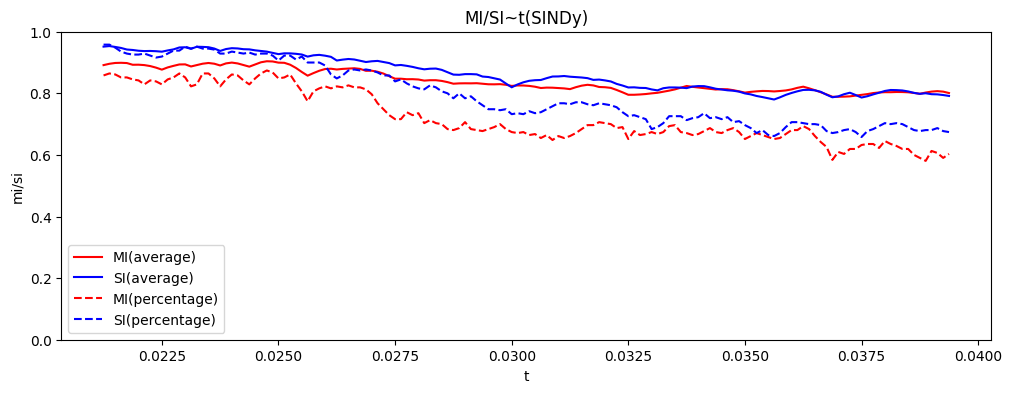

round: 35
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 89.182 1 + -95.930 Vx + 51.031 Vy + -6859.028 t + -6.147 VxVx + -40.729 VyVy + 113940.896 tt + 2.159 VxVy + 2949.820 Vxt + -1239.260 Vyt + 6.676 VxVxVy + -106.905 VxVxt + 961.176 VyVyt + -35.330 VxVyt + 768.014 Vx_2 + 652.290 Vy_2 + 514.696 Vx_1 + -18.139 Vy_1 + 139.955 VxVx_2 + 226.495 VxVy_2 + -47431.061 Vxt_2 + -12.772 VyVx_2 + -111.665 VyVy_2 + 760988.208 Vyt_2 + 15.800 tVx_2 + -4161.969 tVy_2 + -7515.433 tt_2 + 4.471 VxVxVx_2 + 383.497 VxVxVy_2 + 3041.464 VxVxt_2 + -186.811 VyVyVx_2 + -56.412 VyVyVy_2 + 146.532 VyVyt_2 + -43440.209 ttVx_2 + 44.341 ttVy_2 + -1.606 ttt_2 + 689207.723 VxVyVx_2 + -26.923 VxVyVy_2 + 2026.941 VxVyt_2 + -5042.124 VxtVx_2 + -13.045 VxtVy_2 + -966.812 Vxtt_2 + 606.271 VytVx_2 + 706.713 VytVy_2 + -110.375 VxVx_1 + 211.506 VxVy_1 + -35771.318 Vxt_1 + -55.208 VyVx_1 + -101.813 VyVy_1 + 613763.146 Vyt_1 + -26.409 tVx_1 + 2383.836 tVy_1 + -6905.804 tt_1 + 11.219 VxVxVx_1 + 1315.912 VxVxVy_1 + 3764.207 VxVxt_1 + 17

round: 36
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 114.489 1 + -96.098 Vx + 56.959 Vy + -8684.990 t + 15.740 VxVx + -24.367 VyVy + 143557.508 tt + 80.136 VxVy + 2803.479 Vxt + -1467.405 Vyt + 5.875 VxVxVy + -810.421 VxVxt + 494.953 VyVyt + -2513.202 VxVyt + -529.188 Vx_2 + -56.070 Vy_2 + -0.700 Vx_1 + -877.209 Vy_1 + 177.563 VxVx_2 + -219.436 VxVy_2 + 42137.783 Vxt_2 + 16.714 VyVx_2 + 34.644 VyVy_2 + -744341.017 Vyt_2 + 54.244 tVx_2 + -5586.551 tVy_2 + 6536.784 tt_2 + 4.381 VxVxVx_2 + -547.191 VxVxVy_2 + -1618.868 VxVxt_2 + -1229.032 VyVyVx_2 + 66.971 VyVyVy_2 + 167.152 VyVyt_2 + 4000.517 ttVx_2 + -39.567 ttVy_2 + -11.577 ttt_2 + -82004.909 VxVyVx_2 + -109.259 VxVyVy_2 + -1461.262 VxVyt_2 + -5424.390 VxtVx_2 + -10.027 VxtVy_2 + 1275.941 Vxtt_2 + 766.025 VytVx_2 + 3351.548 VytVy_2 + 29.830 VxVx_1 + -33.970 VxVy_1 + 1057.260 Vxt_1 + -9.755 VyVx_1 + 41.846 VyVy_1 + -19218.350 Vyt_1 + 8.094 tVx_1 + -1548.095 tVy_1 + -62.767 tt_1 + 6.870 VxVxVx_1 + 85.242 VxVxVy_1 + -729.354 VxVxt_1 + 117.538 

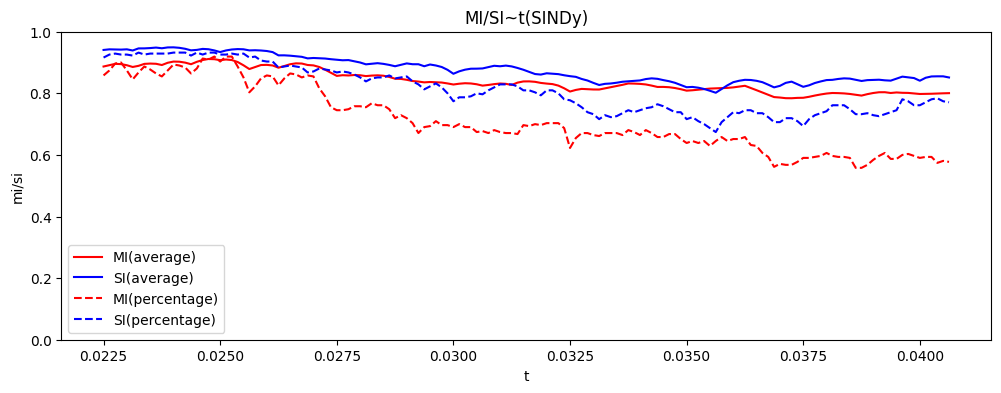

round: 37
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 119.168 1 + 2.208 Vx + 55.666 Vy + -8879.091 t + -7.408 VxVx + -22.849 VyVy + 144800.379 tt + 33.906 VxVy + -256.996 Vxt + -1499.102 Vyt + 4.584 VxVxVy + -50.112 VxVxt + 463.435 VyVyt + -1041.117 VxVyt + -598.400 Vx_2 + 570.290 Vy_2 + -78.104 Vx_1 + -854.621 Vy_1 + 183.171 VxVx_2 + 89.900 VxVy_2 + 45042.695 Vxt_2 + 13.026 VyVx_2 + -172.063 VyVy_2 + -769508.507 Vyt_2 + -4.643 tVx_2 + -6056.895 tVy_2 + -2963.118 tt_2 + 10.476 VxVxVx_2 + -606.988 VxVxVy_2 + 4859.081 VxVxt_2 + 1074.792 VyVyVx_2 + -138.129 VyVyVy_2 + 202.867 VyVyt_2 + -36181.525 ttVx_2 + 36.234 ttVy_2 + -29.748 ttt_2 + 549229.091 VxVyVx_2 + 179.888 VxVyVy_2 + 4772.356 VxVyt_2 + -6759.500 VxtVx_2 + -4.740 VxtVy_2 + -1303.392 Vxtt_2 + 1487.685 VytVx_2 + -5578.526 VytVy_2 + 16.240 VxVx_1 + -24.600 VxVy_1 + 6228.117 Vxt_1 + -21.511 VyVx_1 + -3.408 VyVy_1 + -113329.954 Vyt_1 + -27.268 tVx_1 + -1418.737 tVy_1 + 630.025 tt_1 + 7.883 VxVxVx_1 + 429.173 VxVxVy_1 + 455.294 VxVxt_1 + 161

round: 38
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -100.587 1 + -80.169 Vx + 7.709 Vy + 5001.864 t + 9.228 VxVx + -40.870 VyVy + -68371.574 tt + 10.633 VxVy + 2243.018 Vxt + 95.553 Vyt + 8.179 VxVxVy + -662.852 VxVxt + 989.496 VyVyt + -1.150 VxVyt + -814.870 Vx_2 + 592.201 Vy_2 + -178.568 Vx_1 + 201.657 Vy_1 + 135.756 VxVx_2 + 262.158 VxVy_2 + 57118.105 Vxt_2 + -55.525 VyVx_2 + -338.148 VyVy_2 + -929621.770 Vyt_2 + -182.881 tVx_2 + -3817.704 tVy_2 + -7068.886 tt_2 + 6.148 VxVxVx_2 + 1666.002 VxVxVy_2 + 9577.062 VxVxt_2 + 6233.625 VyVyVx_2 + -128.618 VyVyVy_2 + 261.989 VyVyt_2 + -31640.552 ttVx_2 + 123.277 ttVy_2 + -92.676 ttt_2 + 395280.417 VxVyVx_2 + 169.751 VxVyVy_2 + 5103.348 VxVyt_2 + -8303.753 VxtVx_2 + -9.381 VxtVy_2 + -3757.998 Vxtt_2 + 3141.801 VytVx_2 + -5973.570 VytVy_2 + -79.514 VxVx_1 + 99.675 VxVy_1 + 8190.849 Vxt_1 + -34.574 VyVx_1 + -35.935 VyVy_1 + -78685.639 Vyt_1 + -28.232 tVx_1 + 1327.664 tVy_1 + -2406.131 tt_1 + 9.119 VxVxVx_1 + 795.766 VxVxVy_1 + 1064.726 VxVxt_1 + 19

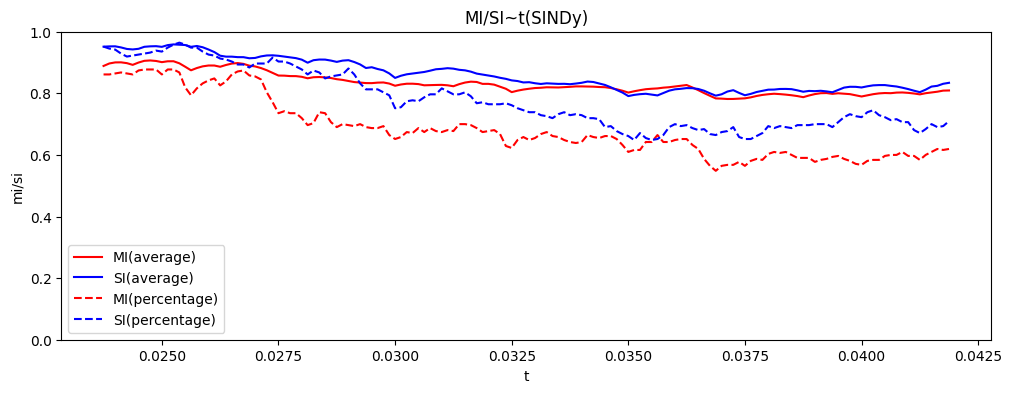

round: 39
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -39.661 1 + -78.690 Vx + 41.753 Vy + 1006.880 t + -10.453 VxVx + -41.681 VyVy + -6284.144 tt + 27.224 VxVy + 2243.949 Vxt + -1096.159 Vyt + 8.104 VxVxVy + -5.379 VxVxt + 1090.207 VyVyt + -576.621 VxVyt + -513.853 Vx_2 + -407.367 Vy_2 + 197.170 Vx_1 + 948.349 Vy_1 + 291.742 VxVx_2 + -116.318 VxVy_2 + 46823.517 Vxt_2 + 19.418 VyVx_2 + -150.959 VyVy_2 + -887505.883 Vyt_2 + -107.198 tVx_2 + -8490.856 tVy_2 + 3690.128 tt_2 + 1.747 VxVxVx_2 + -520.434 VxVxVy_2 + 3891.709 VxVxt_2 + 3523.853 VyVyVx_2 + 279.344 VyVyVy_2 + 236.302 VyVyt_2 + 28376.713 ttVx_2 + -79.683 ttVy_2 + -31.962 ttt_2 + -488779.788 VxVyVx_2 + -113.489 VxVyVy_2 + -6888.179 VxVyt_2 + -7006.698 VxtVx_2 + -4.321 VxtVy_2 + 2274.241 Vxtt_2 + 1084.778 VytVx_2 + 3056.130 VytVy_2 + 75.305 VxVx_1 + -28.726 VxVy_1 + -5041.315 Vxt_1 + 5.095 VyVx_1 + -98.566 VyVy_1 + -10595.650 Vyt_1 + -58.401 tVx_1 + -2951.886 tVy_1 + 499.259 tt_1 + 8.911 VxVxVx_1 + -391.309 VxVxVy_1 + 3203.038 VxVxt_1 + 

round: 40
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -102.314 1 + -52.685 Vx + 58.487 Vy + 4693.012 t + -27.467 VxVx + -37.170 VyVy + -59027.798 tt + 31.434 VxVy + 1575.060 Vxt + -1401.314 Vyt + 3.727 VxVxVy + 543.004 VxVxt + 867.199 VyVyt + -928.486 VxVyt + 722.500 Vx_2 + 129.328 Vy_2 + 481.936 Vx_1 + -163.356 Vy_1 + -0.417 VxVx_2 + -260.486 VxVy_2 + -31794.526 Vxt_2 + 6.648 VyVx_2 + -80.423 VyVy_2 + 337982.972 Vyt_2 + 29.121 tVx_2 + -46.132 tVy_2 + 8228.800 tt_2 + 2.057 VxVxVx_2 + -125.406 VxVxVy_2 + 1916.825 VxVxt_2 + -149.742 VyVyVx_2 + 169.769 VyVyVy_2 + 159.643 VyVyt_2 + -6904.924 ttVx_2 + -76.925 ttVy_2 + -49.328 ttt_2 + 75347.917 VxVyVx_2 + -49.721 VxVyVy_2 + -4491.362 VxVyt_2 + -4940.365 VxtVx_2 + 3.721 VxtVy_2 + 1791.953 Vxtt_2 + 1743.082 VytVx_2 + 1580.515 VytVy_2 + 57.791 VxVx_1 + -193.266 VxVy_1 + -18232.751 Vxt_1 + -2.014 VyVx_1 + 14.216 VyVy_1 + 126604.244 Vyt_1 + -18.516 tVx_1 + -2972.010 tVy_1 + 4991.992 tt_1 + 7.658 VxVxVx_1 + -242.583 VxVxVy_1 + -16.630 VxVxt_1 + 1331.501

round: 41
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 410.789 1 + -79.547 Vx + -24.051 Vy + -24978.701 t + 35.244 VxVx + -38.205 VyVy + 361593.534 tt + 56.580 VxVy + 2261.405 Vxt + 836.247 Vyt + 3.542 VxVxVy + -1329.579 VxVxt + 1084.522 VyVyt + -1649.997 VxVyt + -129.888 Vx_2 + -22.556 Vy_2 + -568.515 Vx_1 + 250.988 Vy_1 + 261.498 VxVx_2 + 37.871 VxVy_2 + 20394.867 Vxt_2 + 17.130 VyVx_2 + -249.878 VyVy_2 + -453848.404 Vyt_2 + -127.208 tVx_2 + -7346.636 tVy_2 + -619.924 tt_2 + -1.986 VxVxVx_2 + -363.779 VxVxVy_2 + 7047.408 VxVxt_2 + 4030.191 VyVyVx_2 + -21.909 VyVyVy_2 + 184.796 VyVyt_2 + -369.879 ttVx_2 + 26.971 ttVy_2 + -92.035 ttt_2 + 23371.754 VxVyVx_2 + 47.098 VxVyVy_2 + 1259.734 VxVyt_2 + -5536.297 VxtVx_2 + 5.857 VxtVy_2 + -1404.912 Vxtt_2 + 2888.901 VytVx_2 + -1566.306 VytVy_2 + 95.695 VxVx_1 + -62.413 VxVy_1 + 35527.489 Vxt_1 + 6.092 VyVx_1 + -100.812 VyVy_1 + -538704.424 Vyt_1 + -149.125 tVx_1 + -3598.197 tVy_1 + 1564.275 tt_1 + 4.278 VxVxVx_1 + -334.767 VxVxVy_1 + 3251.820 VxVxt_1 

round: 42
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 435.560 1 + -22.322 Vx + -20.383 Vy + -27519.139 t + -35.734 VxVx + -46.797 VyVy + 412492.717 tt + -24.463 VxVy + 763.450 Vxt + 919.680 Vyt + 2.357 VxVxVy + 807.908 VxVxt + 1308.535 VyVyt + 804.310 VxVyt + 77.199 Vx_2 + 717.835 Vy_2 + -572.160 Vx_1 + -991.939 Vy_1 + 150.826 VxVx_2 + -314.402 VxVy_2 + 5165.301 Vxt_2 + 67.651 VyVx_2 + -57.171 VyVy_2 + -185254.666 Vyt_2 + 25.049 tVx_2 + -4624.223 tVy_2 + 7948.036 tt_2 + -0.476 VxVxVx_2 + -1869.144 VxVxVy_2 + 2055.409 VxVxt_2 + -44.714 VyVyVx_2 + -23.909 VyVyVy_2 + 117.104 VyVyt_2 + -43972.568 ttVx_2 + -100.846 ttVy_2 + 25.816 ttt_2 + 649760.564 VxVyVx_2 + 55.086 VxVyVy_2 + 1381.763 VxVyt_2 + -3710.161 VxtVx_2 + 6.343 VxtVy_2 + 2381.134 Vxtt_2 + -458.062 VytVx_2 + -1792.122 VytVy_2 + -84.961 VxVx_1 + -133.167 VxVy_1 + 37134.210 Vxt_1 + -13.128 VyVx_1 + 1.959 VyVy_1 + -580772.556 Vyt_1 + -30.921 tVx_1 + 1811.446 tVy_1 + 3294.249 tt_1 + 8.531 VxVxVx_1 + 80.064 VxVxVy_1 + 585.004 VxVxt_1 + 1803.

round: 43
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 356.661 1 + 18.812 Vx + 53.830 Vy + -21903.973 t + -7.120 VxVx + -64.662 VyVy + 319131.580 tt + 7.634 VxVy + -438.147 Vxt + -1182.235 Vyt + 2.220 VxVxVy + -25.697 VxVxt + 1736.921 VyVyt + -196.040 VxVyt + 4.516 Vx_2 + 141.080 Vy_2 + -545.987 Vx_1 + 433.812 Vy_1 + 27.177 VxVx_2 + -93.814 VxVy_2 + 7899.514 Vxt_2 + 26.270 VyVx_2 + 50.121 VyVy_2 + -207194.595 Vyt_2 + 93.237 tVx_2 + -1394.119 tVy_2 + 2563.532 tt_2 + -823.793 VxVxVy_2 + -1476.939 VxVxt_2 + -2071.402 VyVyVx_2 + 39.215 VyVyVy_2 + -18.772 VyVyt_2 + -10997.333 ttVx_2 + 46.321 ttVy_2 + 69.626 ttt_2 + 183090.188 VxVyVx_2 + -72.754 VxVyVy_2 + -29.575 VxVyt_2 + -111.013 VxtVx_2 + 6.833 VxtVy_2 + -1475.206 Vxtt_2 + -1618.684 VytVx_2 + 1734.119 VytVy_2 + -83.899 VxVx_1 + -67.218 VxVy_1 + 32990.618 Vxt_1 + -45.514 VyVx_1 + -15.431 VyVy_1 + -486803.450 Vyt_1 + -28.803 tVx_1 + 1547.141 tVy_1 + 1548.174 tt_1 + 6.248 VxVxVx_1 + 859.589 VxVxVy_1 + 843.667 VxVxt_1 + 1331.818 VyVyVx_1 + 299.291 

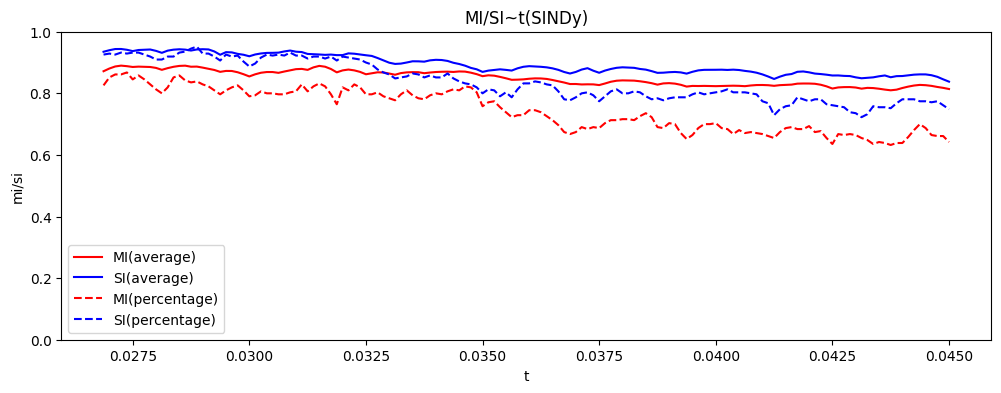

round: 44
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 163.006 1 + -72.984 Vx + 64.286 Vy + -10157.554 t + -29.606 VxVx + -60.278 VyVy + 144426.637 tt + 64.838 VxVy + 2056.392 Vxt + -1501.801 Vyt + -2.086 VxVxVy + 760.490 VxVxt + 1602.084 VyVyt + -1887.396 VxVyt + 493.718 Vx_2 + -971.038 Vy_2 + -1173.754 Vx_1 + 2034.309 Vy_1 + 75.045 VxVx_2 + -210.318 VxVy_2 + -18611.431 Vxt_2 + 69.875 VyVx_2 + 72.283 VyVy_2 + 145810.458 Vyt_2 + 199.796 tVx_2 + -2918.369 tVy_2 + 4974.305 tt_2 + 2.487 VxVxVx_2 + -2116.390 VxVxVy_2 + -1607.661 VxVxt_2 + -4834.295 VyVyVx_2 + 112.895 VyVyVy_2 + 34.773 VyVyt_2 + 52483.156 ttVx_2 + 34.343 ttVy_2 + 48.502 ttt_2 + -712351.277 VxVyVx_2 + -26.189 VxVyVy_2 + -2603.979 VxVyt_2 + -1638.201 VxtVx_2 + 10.962 VxtVy_2 + -1686.456 Vxtt_2 + -935.532 VytVx_2 + 532.790 VytVy_2 + -224.049 VxVx_1 + 108.400 VxVy_1 + 66886.863 Vxt_1 + -55.673 VyVx_1 + -24.524 VyVy_1 + -935254.961 Vyt_1 + 131.867 tVx_1 + 5554.591 tVy_1 + -2976.382 tt_1 + 6.462 VxVxVx_1 + 1293.956 VxVxVy_1 + 923.403 Vx

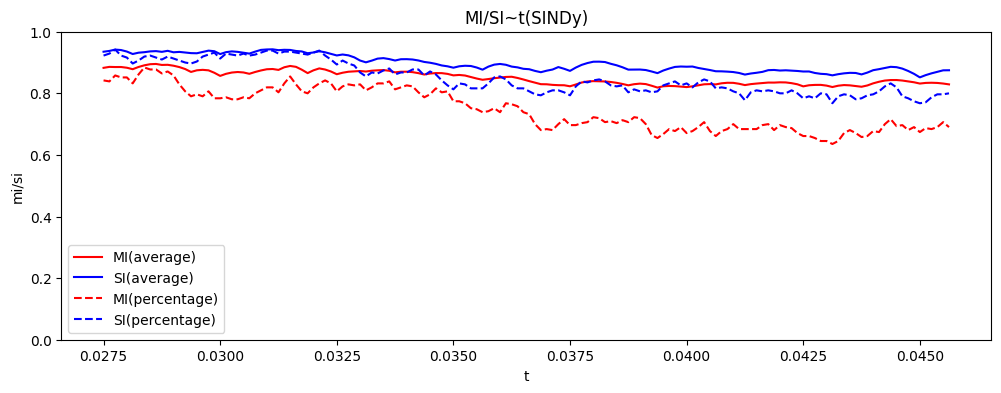

round: 45
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 77.720 1 + 50.691 Vx + 14.141 Vy + -5975.031 t + -38.998 VxVx + -81.006 VyVy + 94175.258 tt + -36.331 VxVy + -1451.265 Vxt + -230.703 Vyt + 0.950 VxVxVy + 801.099 VxVxt + 2133.806 VyVyt + 680.932 VxVyt + 386.028 Vx_2 + 232.139 Vy_2 + 98.720 Vx_1 + 557.748 Vy_1 + -26.243 VxVx_2 + 28.812 VxVy_2 + -13772.552 Vxt_2 + 21.380 VyVx_2 + -56.472 VyVy_2 + 93644.256 Vyt_2 + 92.819 tVx_2 + 429.070 tVy_2 + -1218.683 tt_2 + -7.034 VxVxVx_2 + -581.743 VxVxVy_2 + 1618.818 VxVxt_2 + -2972.715 VyVyVx_2 + 89.249 VyVyVy_2 + 123.097 VyVyt_2 + -15192.665 ttVx_2 + -13.830 ttVy_2 + 14.740 ttt_2 + 223390.465 VxVyVx_2 + -59.838 VxVyVy_2 + -1896.042 VxVyt_2 + -3870.131 VxtVx_2 + 15.422 VxtVy_2 + -8.399 Vxtt_2 + 22.603 VytVx_2 + 1848.850 VytVy_2 + -64.478 VxVx_1 + 35.757 VxVy_1 + -1096.427 Vxt_1 + -32.545 VyVx_1 + -15.809 VyVy_1 + -33819.931 Vyt_1 + 69.201 tVx_1 + 1356.541 tVy_1 + -1937.699 tt_1 + 1.716 VxVxVx_1 + 638.918 VxVxVy_1 + 907.390 VxVxt_1 + -1917.620 VyVyV

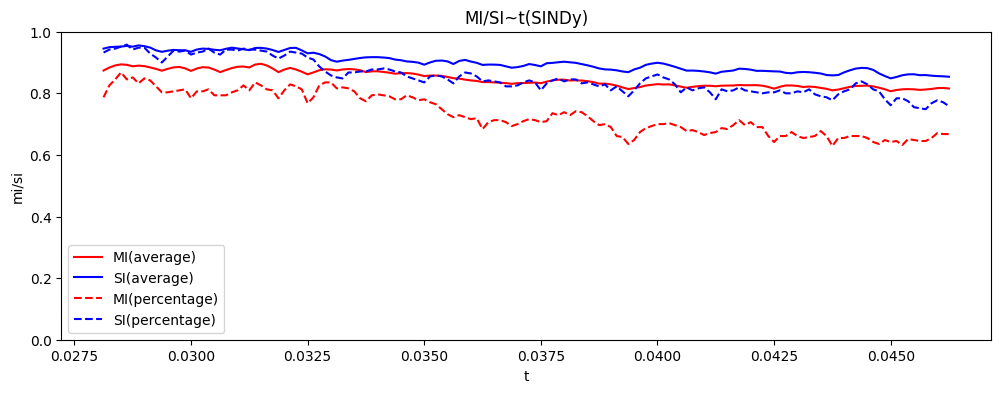

round: 46
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -217.855 1 + -57.975 Vx + 77.762 Vy + 10238.257 t + -56.544 VxVx + -82.504 VyVy + -124043.837 tt + -8.050 VxVy + 1509.709 Vxt + -1865.972 Vyt + -4.492 VxVxVy + 1307.445 VxVxt + 2101.206 VyVyt + -366.138 VxVyt + -423.740 Vx_2 + 567.876 Vy_2 + -1133.708 Vx_1 + 485.272 Vy_1 + -7.119 VxVx_2 + -547.282 VxVy_2 + 28001.291 Vxt_2 + 17.164 VyVx_2 + 69.673 VyVy_2 + -440390.735 Vyt_2 + 17.558 tVx_2 + -709.782 tVy_2 + 13900.132 tt_2 + 0.566 VxVxVx_2 + -642.784 VxVxVy_2 + -1544.145 VxVxt_2 + -179.513 VyVyVx_2 + 363.623 VyVyVy_2 + 80.598 VyVyt_2 + -31176.085 ttVx_2 + 17.853 ttVy_2 + 23.740 ttt_2 + 405087.375 VxVyVx_2 + -97.359 VxVyVy_2 + -9149.055 VxVyt_2 + -2712.427 VxtVx_2 + 9.586 VxtVy_2 + -919.743 Vxtt_2 + -123.003 VytVx_2 + 2907.911 VytVy_2 + -117.949 VxVx_1 + -179.022 VxVy_1 + 61231.424 Vxt_1 + -35.642 VyVx_1 + 78.426 VyVy_1 + -812100.944 Vyt_1 + 15.067 tVx_1 + 2625.635 tVy_1 + 3577.696 tt_1 + -3.425 VxVxVx_1 + 821.565 VxVxVy_1 + -1531.142 VxVxt_

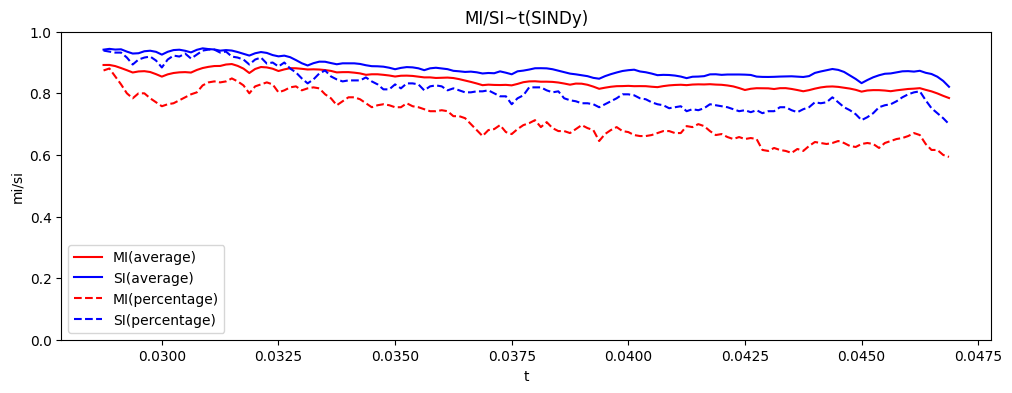

round: 47
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 30.875 1 + -27.803 Vx + 117.803 Vy + -3571.672 t + -8.303 VxVx + -86.754 VyVy + 64574.890 tt + 104.227 VxVy + 745.326 Vxt + -2808.802 Vyt + -3.505 VxVxVy + 91.311 VxVxt + 2258.255 VyVyt + -3000.632 VxVyt + 152.848 Vx_2 + 109.652 Vy_2 + -434.222 Vx_1 + 733.577 Vy_1 + 188.060 VxVx_2 + -173.967 VxVy_2 + -1608.115 Vxt_2 + 65.269 VyVx_2 + -35.898 VyVy_2 + -64727.651 Vyt_2 + 157.453 tVx_2 + -5468.989 tVy_2 + 4207.657 tt_2 + -1778.144 VxVxVy_2 + 1335.638 VxVxt_2 + -3642.410 VyVyVx_2 + 92.156 VyVyVy_2 + 31.773 VyVyt_2 + -9837.096 ttVx_2 + -4.629 ttVy_2 + 57.911 ttt_2 + 168109.266 VxVyVx_2 + 33.149 VxVyVy_2 + -2050.070 VxVyt_2 + -1668.243 VxtVx_2 + 4.879 VxtVy_2 + -543.847 Vxtt_2 + -1079.740 VytVx_2 + -922.518 VytVy_2 + -67.342 VxVx_1 + -92.831 VxVy_1 + 16531.613 Vxt_1 + -14.699 VyVx_1 + 182.799 VyVy_1 + -131422.319 Vyt_1 + 113.100 tVx_1 + 1642.552 tVy_1 + 1689.289 tt_1 + -0.422 VxVxVx_1 + 304.654 VxVxVy_1 + -4334.267 VxVxt_1 + -2998.703 VyVyVx_1 

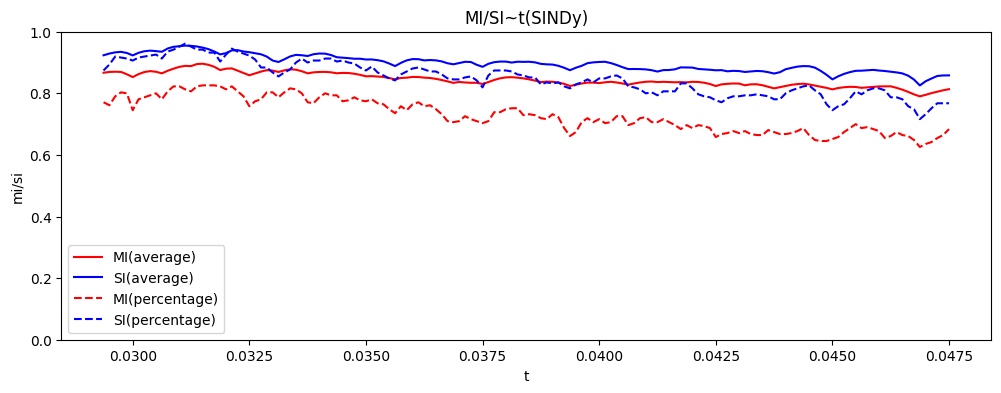

round: 48
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -11.741 1 + -38.028 Vx + 93.038 Vy + -974.995 t + -85.236 VxVx + -112.333 VyVy + 26785.607 tt + -89.485 VxVy + 1244.916 Vxt + -2215.160 Vyt + -10.638 VxVxVy + 2215.880 VxVxt + 2897.682 VyVyt + 1708.971 VxVyt + -993.545 Vx_2 + 817.029 Vy_2 + -612.438 Vx_1 + -681.865 Vy_1 + 87.602 VxVx_2 + -162.166 VxVy_2 + 54707.452 Vxt_2 + 100.122 VyVx_2 + 147.743 VyVy_2 + -749261.896 Vyt_2 + 326.077 tVx_2 + -3099.276 tVy_2 + 4402.045 tt_2 + 5.456 VxVxVx_2 + -2789.338 VxVxVy_2 + -3612.716 VxVxt_2 + -7391.872 VyVyVx_2 + 95.374 VyVyVy_2 + 3.207 VyVyt_2 + -50256.011 ttVx_2 + -134.242 ttVy_2 + 202.132 ttt_2 + 729070.686 VxVyVx_2 + -4.793 VxVyVy_2 + -2867.154 VxVyt_2 + -553.639 VxtVx_2 + 11.495 VxtVy_2 + 2443.840 Vxtt_2 + -4847.670 VytVx_2 + 519.751 VytVy_2 + -94.541 VxVx_1 + -225.257 VxVy_1 + 23432.936 Vxt_1 + -13.261 VyVx_1 + 322.976 VyVy_1 + -204039.432 Vyt_1 + 95.519 tVx_1 + 2252.254 tVy_1 + 5115.684 tt_1 + -3.877 VxVxVx_1 + 311.910 VxVxVy_1 + -7746.640 Vx

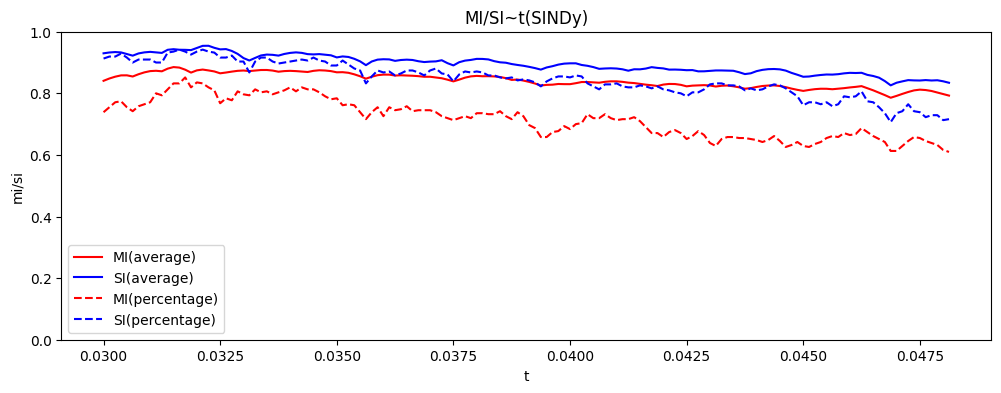

round: 49
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 261.525 1 + 2.022 Vx + 28.602 Vy + -15043.439 t + 19.235 VxVx + -70.420 VyVy + 204846.516 tt + 19.346 VxVy + -303.026 Vxt + -317.866 Vyt + 2.196 VxVxVy + -760.797 VxVxt + 1837.594 VyVyt + -402.552 VxVyt + -859.499 Vx_2 + -867.823 Vy_2 + 275.499 Vx_1 + 45.522 Vy_1 + -11.970 VxVx_2 + 0.641 VxVy_2 + 48115.325 Vxt_2 + 24.309 VyVx_2 + -31.162 VyVy_2 + -661816.720 Vyt_2 + 159.982 tVx_2 + 107.301 tVy_2 + -892.216 tt_2 + -0.924 VxVxVx_2 + -551.416 VxVxVy_2 + 1173.104 VxVxt_2 + -3805.520 VyVyVx_2 + -152.834 VyVyVy_2 + -244.674 VyVyt_2 + 38895.750 ttVx_2 + -59.037 ttVy_2 + 68.756 ttt_2 + -426841.620 VxVyVx_2 + -2.914 VxVyVy_2 + 4853.282 VxVyt_2 + 5406.667 VxtVx_2 + -29.802 VxtVy_2 + 1679.274 Vxtt_2 + -1455.168 VytVx_2 + -635.039 VytVy_2 + -71.416 VxVx_1 + -325.291 VxVy_1 + -11746.264 Vxt_1 + -24.678 VyVx_1 + 156.606 VyVy_1 + 121807.479 Vyt_1 + -77.616 tVx_1 + 2079.671 tVy_1 + 7910.374 tt_1 + 4.105 VxVxVx_1 + 674.470 VxVxVy_1 + -3688.425 VxVxt_1 + 2

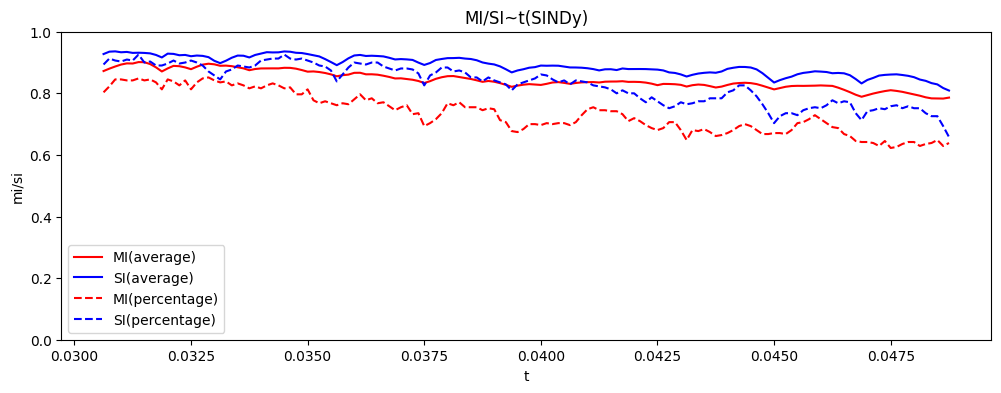

round: 50
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 143.166 1 + 111.995 Vx + 37.714 Vy + -8065.287 t + -15.969 VxVx + -37.121 VyVy + 105484.028 tt + -96.436 VxVy + -2771.193 Vxt + -782.003 Vyt + -1.986 VxVxVy + 274.929 VxVxt + 995.323 VyVyt + 2023.425 VxVyt + -924.830 Vx_2 + -364.235 Vy_2 + -709.317 Vx_1 + -469.852 Vy_1 + 42.904 VxVx_2 + 15.545 VxVy_2 + 52141.461 Vxt_2 + 28.238 VyVx_2 + -266.597 VyVy_2 + -723212.074 Vyt_2 + -46.667 tVx_2 + -1769.901 tVy_2 + 97.380 tt_2 + 5.672 VxVxVx_2 + -869.230 VxVxVy_2 + 6833.087 VxVxt_2 + 1826.124 VyVyVx_2 + -99.210 VyVyVy_2 + -100.154 VyVyt_2 + 15982.609 ttVx_2 + -5.019 ttVy_2 + 80.205 ttt_2 + -175420.106 VxVyVx_2 + 59.925 VxVyVy_2 + 2949.459 VxVyt_2 + 1697.429 VxtVx_2 + 5.919 VxtVy_2 + -355.562 Vxtt_2 + -1681.787 VytVx_2 + -1719.913 VytVy_2 + -224.113 VxVx_1 + -368.975 VxVy_1 + 35259.440 Vxt_1 + 0.802 VyVx_1 + 241.061 VyVy_1 + -426756.424 Vyt_1 + 81.800 tVx_1 + 5425.556 tVy_1 + 8852.902 tt_1 + -4.363 VxVxVx_1 + 53.922 VxVxVy_1 + -5929.801 VxVxt_1 + -

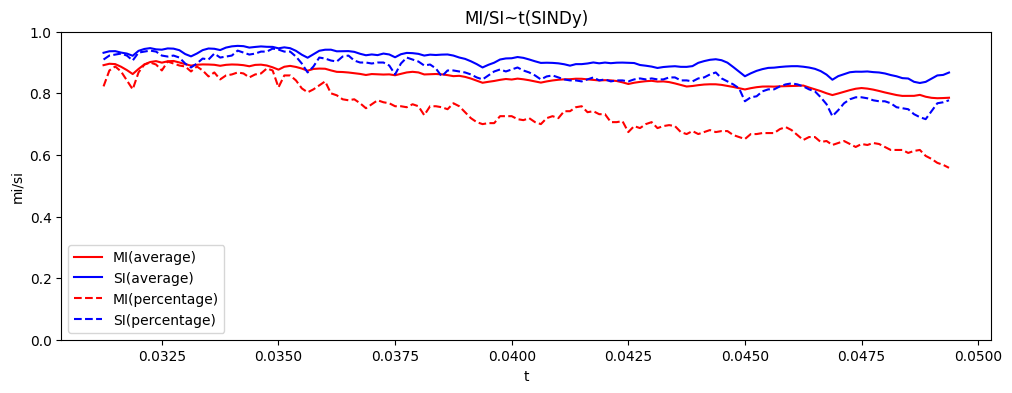

round: 51
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -233.049 1 + 49.546 Vx + 37.830 Vy + 11127.048 t + -60.346 VxVx + -53.181 VyVy + -135030.727 tt + 4.033 VxVy + -1138.041 Vxt + -858.343 Vyt + -4.503 VxVxVy + 1391.778 VxVxt + 1341.505 VyVyt + -581.504 VxVyt + -357.435 Vx_2 + 795.156 Vy_2 + 620.971 Vx_1 + -245.486 Vy_1 + 125.978 VxVx_2 + 291.994 VxVy_2 + 29859.233 Vxt_2 + 37.602 VyVx_2 + -372.518 VyVy_2 + -518695.502 Vyt_2 + 69.871 tVx_2 + -3760.854 tVy_2 + -6691.549 tt_2 + 3.827 VxVxVx_2 + -1132.787 VxVxVy_2 + 9033.384 VxVxt_2 + -1470.907 VyVyVx_2 + 173.092 VyVyVy_2 + -119.572 VyVyt_2 + -38540.144 ttVx_2 + -28.760 ttVy_2 + 91.199 ttt_2 + 456824.046 VxVyVx_2 + -6.521 VxVyVy_2 + -4109.882 VxVyt_2 + 2336.730 VxtVx_2 + 7.216 VxtVy_2 + 213.730 Vxtt_2 + -2023.921 VytVx_2 + 354.075 VytVy_2 + -274.336 VxVx_1 + -453.289 VxVy_1 + -35447.858 Vxt_1 + -39.221 VyVx_1 + 306.537 VyVy_1 + 495442.557 Vyt_1 + 176.328 tVx_1 + 6397.383 tVy_1 + 10904.060 tt_1 + -1.892 VxVxVx_1 + 940.718 VxVxVy_1 + -7523.969 Vx

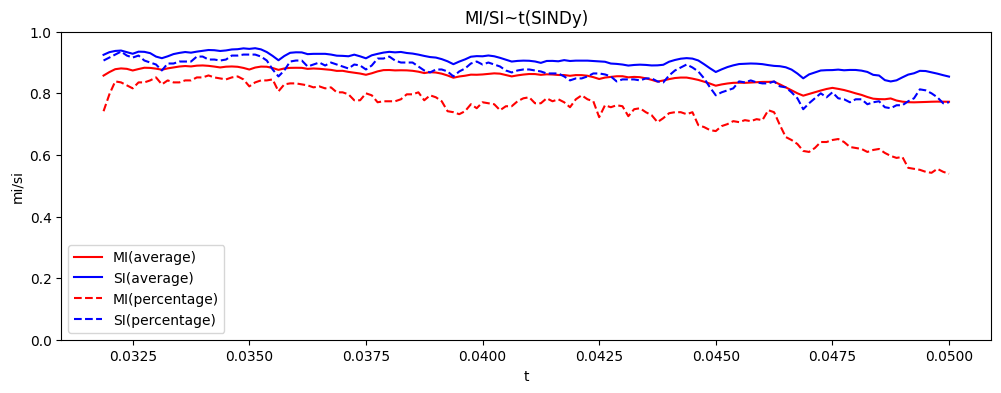

round: 52
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -680.672 1 + 44.591 Vx + 89.822 Vy + 32968.508 t + -0.223 VxVx + -103.051 VyVy + -398069.700 tt + -51.236 VxVy + -972.295 Vxt + -2021.833 Vyt + -4.323 VxVxVy + -113.253 VxVxt + 2550.145 VyVyt + 950.575 VxVyt + 988.674 Vx_2 + 441.345 Vy_2 + 1767.876 Vx_1 + 704.784 Vy_1 + 21.082 VxVx_2 + -472.310 VxVy_2 + -41452.908 Vxt_2 + 30.454 VyVx_2 + 127.926 VyVy_2 + 406065.786 Vyt_2 + 73.710 tVx_2 + -1435.840 tVy_2 + 11133.414 tt_2 + 4.061 VxVxVx_2 + -947.702 VxVxVy_2 + -3063.214 VxVxt_2 + -1513.894 VyVyVx_2 + 234.990 VyVyVy_2 + -189.532 VyVyt_2 + -23281.805 ttVx_2 + -45.627 ttVy_2 + 132.830 ttt_2 + 293173.442 VxVyVx_2 + -264.796 VxVyVy_2 + -5558.462 VxVyt_2 + 4115.709 VxtVx_2 + 4.807 VxtVy_2 + 801.254 Vxtt_2 + -2993.335 VytVx_2 + 6995.978 VytVy_2 + -205.438 VxVx_1 + -327.119 VxVy_1 + -88362.573 Vxt_1 + 13.743 VyVx_1 + 243.586 VyVy_1 + 1088491.276 Vyt_1 + 160.697 tVx_1 + 4695.598 tVy_1 + 7828.545 tt_1 + -3.342 VxVxVx_1 + -285.074 VxVxVy_1 + -5691.350

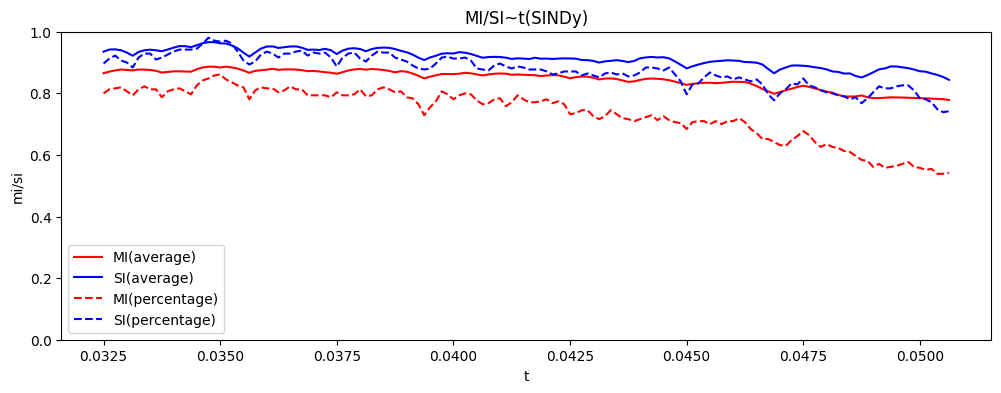

round: 53
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -464.128 1 + 52.205 Vx + -0.721 Vy + 21957.636 t + -30.305 VxVx + -58.115 VyVy + -259905.856 tt + -93.563 VxVy + -1188.634 Vxt + 15.566 Vyt + -4.377 VxVxVy + 634.629 VxVxt + 1460.043 VyVyt + 1887.290 VxVyt + 1762.576 Vx_2 + 1078.675 Vy_2 + 553.223 Vx_1 + -999.295 Vy_1 + 311.733 VxVx_2 + 296.696 VxVy_2 + -74418.232 Vxt_2 + 87.605 VyVx_2 + -173.585 VyVy_2 + 752190.984 Vyt_2 + 127.665 tVx_2 + -8478.767 tVy_2 + -6764.241 tt_2 + 6.517 VxVxVx_2 + -2342.191 VxVxVy_2 + 3961.829 VxVxt_2 + -2453.962 VyVyVx_2 + -396.193 VyVyVy_2 + -77.862 VyVyt_2 + -55445.233 ttVx_2 + -232.816 ttVy_2 + 106.234 ttt_2 + 696068.614 VxVyVx_2 + -124.623 VxVyVy_2 + 9942.014 VxVyt_2 + 1558.063 VxtVx_2 + -12.845 VxtVy_2 + 5589.113 Vxtt_2 + -2480.906 VytVx_2 + 2867.486 VytVy_2 + -315.691 VxVx_1 + -377.688 VxVy_1 + -35246.334 Vxt_1 + -6.188 VyVx_1 + 271.881 VyVy_1 + 519002.266 Vyt_1 + 102.746 tVx_1 + 7501.348 tVy_1 + 9122.992 tt_1 + -4.052 VxVxVx_1 + 211.054 VxVxVy_1 + -6540.

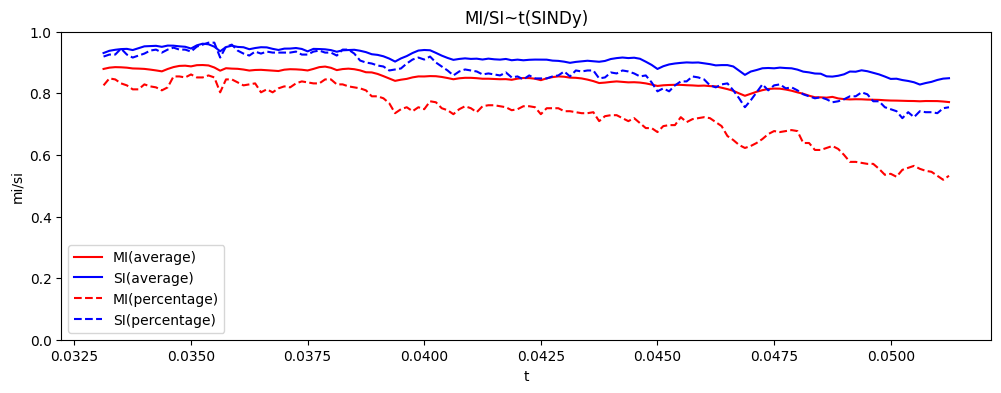

round: 54
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -121.092 1 + -30.039 Vx + 27.857 Vy + 4822.879 t + -19.425 VxVx + -54.011 VyVy + -50164.211 tt + -63.126 VxVy + 651.227 Vxt + -604.751 Vyt + -1.139 VxVxVy + 398.563 VxVxt + 1368.066 VyVyt + 1201.947 VxVyt + -838.310 Vx_2 + -870.827 Vy_2 + 103.334 Vx_1 + -1834.602 Vy_1 + 73.181 VxVx_2 + 89.127 VxVy_2 + 46122.624 Vxt_2 + 46.140 VyVx_2 + -251.762 VyVy_2 + -628465.041 Vyt_2 + -32.315 tVx_2 + -2544.792 tVy_2 + -2454.713 tt_2 + -0.797 VxVxVx_2 + -1373.868 VxVxVy_2 + 6136.313 VxVxt_2 + 257.567 VyVyVx_2 + 402.298 VyVyVy_2 + -30.201 VyVyt_2 + 42195.121 ttVx_2 + -37.702 ttVy_2 + 77.671 ttt_2 + -513158.041 VxVyVx_2 + -332.115 VxVyVy_2 + -8963.656 VxVyt_2 + 139.588 VxtVx_2 + 2.647 VxtVy_2 + 766.436 Vxtt_2 + -1688.825 VytVx_2 + 7620.017 VytVy_2 + -75.879 VxVx_1 + 40.653 VxVy_1 + -7133.387 Vxt_1 + 37.443 VyVx_1 + -7.330 VyVy_1 + 121915.759 Vyt_1 + 57.608 tVx_1 + 1962.888 tVy_1 + -862.181 tt_1 + -3.406 VxVxVx_1 + -794.555 VxVxVy_1 + 31.642 VxVxt_1 + -14

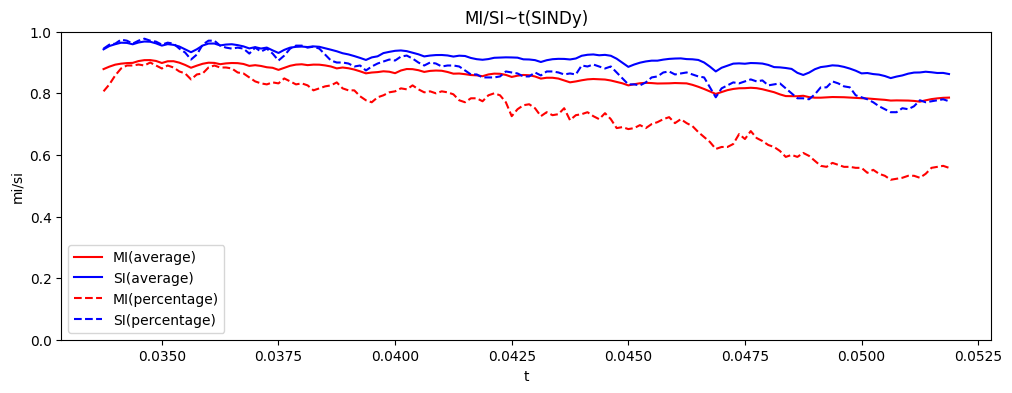

round: 55
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -347.536 1 + -18.123 Vx + 13.403 Vy + 15448.565 t + -32.171 VxVx + -42.930 VyVy + -172554.201 tt + -42.278 VxVy + 425.817 Vxt + -237.225 Vyt + -3.460 VxVxVy + 711.475 VxVxt + 1084.372 VyVyt + 767.872 VxVyt + 758.860 Vx_2 + -191.974 Vy_2 + 2802.137 Vx_1 + 1232.641 Vy_1 + -8.182 VxVx_2 + -45.005 VxVy_2 + -31366.846 Vxt_2 + 29.938 VyVx_2 + 43.882 VyVy_2 + 303351.820 Vyt_2 + 128.962 tVx_2 + -251.640 tVy_2 + 536.544 tt_2 + -1.667 VxVxVx_2 + -843.549 VxVxVy_2 + -852.614 VxVxt_2 + -3334.123 VyVyVx_2 + 329.234 VyVyVy_2 + -132.413 VyVyt_2 + 9456.336 ttVx_2 + -61.657 ttVy_2 + 93.678 ttt_2 + -121434.575 VxVyVx_2 + -318.898 VxVyVy_2 + -7517.715 VxVyt_2 + 2666.639 VxtVx_2 + 13.977 VxtVy_2 + 846.477 Vxtt_2 + -2047.913 VytVx_2 + 7796.289 VytVy_2 + -196.926 VxVx_1 + 48.127 VxVy_1 + -132225.105 Vxt_1 + -27.982 VyVx_1 + 80.767 VyVy_1 + 1548606.285 Vyt_1 + 85.965 tVx_1 + 5078.441 tVy_1 + -1410.338 tt_1 + -9.347 VxVxVx_1 + 939.448 VxVxVy_1 + -1608.745 VxVxt_

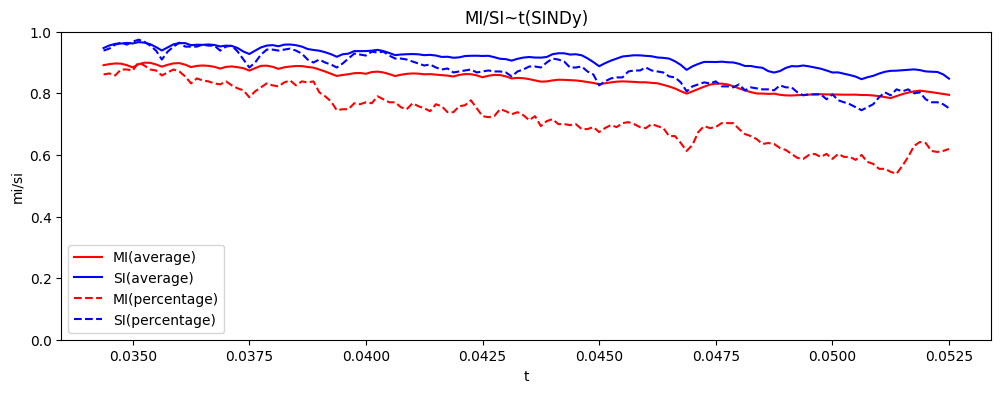

round: 56
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -609.738 1 + 7.579 Vx + 37.691 Vy + 26558.227 t + -10.230 VxVx + -48.583 VyVy + -288365.382 tt + -33.086 VxVy + -274.169 Vxt + -691.173 Vyt + -2.226 VxVxVy + 95.526 VxVxt + 1228.174 VyVyt + 622.677 VxVyt + 386.385 Vx_2 + -914.420 Vy_2 + 1066.273 Vx_1 + 2036.321 Vy_1 + 60.423 VxVx_2 + 222.851 VxVy_2 + -17212.927 Vxt_2 + 34.088 VyVx_2 + 293.791 VyVy_2 + 174155.461 Vyt_2 + 266.886 tVx_2 + -1989.010 tVy_2 + -5643.322 tt_2 + 0.161 VxVxVx_2 + -938.578 VxVxVy_2 + -6872.192 VxVxt_2 + -6487.926 VyVyVx_2 + 409.466 VyVyVy_2 + -240.202 VyVyt_2 + 38528.945 ttVx_2 + -105.825 ttVy_2 + 111.860 ttt_2 + -403894.580 VxVyVx_2 + -538.998 VxVyVy_2 + -9010.615 VxVyt_2 + 5233.948 VxtVx_2 + 5.850 VxtVy_2 + 2185.829 Vxtt_2 + -2538.123 VytVx_2 + 12912.871 VytVy_2 + -181.400 VxVx_1 + 54.468 VxVy_1 + -50351.977 Vxt_1 + -11.559 VyVx_1 + 172.218 VyVy_1 + 592334.529 Vyt_1 + 168.979 tVx_1 + 4482.477 tVy_1 + -1120.063 tt_1 + -8.565 VxVxVx_1 + 491.233 VxVxVy_1 + -4073.740 

round: 57
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -757.758 1 + 60.072 Vx + 24.801 Vy + 33856.287 t + -22.085 VxVx + 4.418 VyVy + -376477.136 tt + -81.603 VxVy + -1265.725 Vxt + -418.954 Vyt + -4.396 VxVxVy + 435.418 VxVxt + 19.919 VyVyt + 1586.181 VxVyt + 1305.261 Vx_2 + 1314.678 Vy_2 + 1356.834 Vx_1 + 100.548 Vy_1 + 28.521 VxVx_2 + -115.825 VxVy_2 + -56384.237 Vxt_2 + 35.784 VyVx_2 + 167.033 VyVy_2 + 582541.951 Vyt_2 + 159.897 tVx_2 + -1502.774 tVy_2 + 2457.913 tt_2 + -1.230 VxVxVx_2 + -1004.286 VxVxVy_2 + -3778.772 VxVxt_2 + -3835.993 VyVyVx_2 + 303.011 VyVyVy_2 + -102.456 VyVyt_2 + -58363.665 ttVx_2 + -83.839 ttVy_2 + 133.396 ttt_2 + 629839.811 VxVyVx_2 + -292.466 VxVyVy_2 + -7406.228 VxVyt_2 + 2367.350 VxtVx_2 + 15.100 VxtVy_2 + 1493.186 Vxtt_2 + -2939.992 VytVx_2 + 7787.998 VytVy_2 + -148.881 VxVx_1 + -247.524 VxVy_1 + -64544.323 Vxt_1 + 8.006 VyVx_1 + 236.121 VyVy_1 + 756718.191 Vyt_1 + 154.492 tVx_1 + 3438.424 tVy_1 + 5902.411 tt_1 + -9.327 VxVxVx_1 + -8.527 VxVxVy_1 + -5342.590 V

round: 58
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -252.284 1 + 19.024 Vx + 51.214 Vy + 10426.030 t + -2.147 VxVx + -52.232 VyVy + -108194.652 tt + -34.789 VxVy + -307.441 Vxt + -1021.344 Vyt + -4.526 VxVxVy + 62.334 VxVxt + 1316.324 VyVyt + 604.511 VxVyt + 3935.257 Vx_2 + -1968.982 Vy_2 + 1549.903 Vx_1 + -167.279 Vy_1 + -61.034 VxVx_2 + 343.477 VxVy_2 + -173808.414 Vxt_2 + -18.673 VyVx_2 + 135.535 VyVy_2 + 1879186.021 Vyt_2 + 280.979 tVx_2 + 202.493 tVy_2 + -7753.577 tt_2 + 4.253 VxVxVx_2 + 147.113 VxVxVy_2 + -2954.907 VxVxt_2 + -5923.878 VyVyVx_2 + -198.402 VyVyVy_2 + -304.839 VyVyt_2 + 83914.688 ttVx_2 + -129.732 ttVy_2 + 67.040 ttt_2 + -884409.314 VxVyVx_2 + -236.770 VxVyVy_2 + 4124.840 VxVyt_2 + 6535.787 VxtVx_2 + 12.703 VxtVy_2 + 2236.380 Vxtt_2 + -1575.613 VytVx_2 + 5867.772 VytVy_2 + -204.369 VxVx_1 + 19.334 VxVy_1 + -74242.421 Vxt_1 + -23.889 VyVx_1 + 256.684 VyVy_1 + 879752.558 Vyt_1 + 142.723 tVx_1 + 4890.584 tVy_1 + -485.124 tt_1 + -6.113 VxVxVx_1 + 682.604 VxVxVy_1 + -5840.35

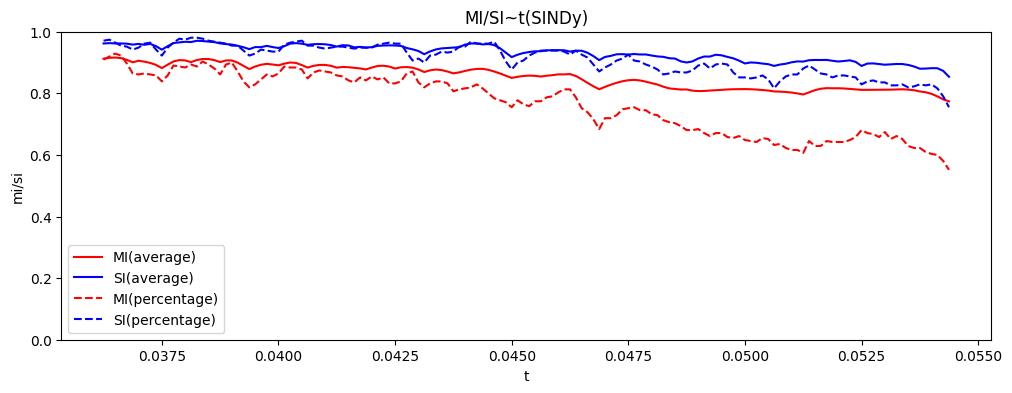

round: 59
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -223.000 1 + 93.263 Vx + 90.863 Vy + 9553.034 t + 3.182 VxVx + -5.516 VyVy + -103794.581 tt + 28.233 VxVy + -2084.877 Vxt + -1822.497 Vyt + -0.394 VxVxVy + -97.357 VxVxt + 269.747 VyVyt + -557.280 VxVyt + 444.169 Vx_2 + 754.534 Vy_2 + -1337.749 Vx_1 + -2554.108 Vy_1 + 11.250 VxVx_2 + 516.792 VxVy_2 + -21668.565 Vxt_2 + 38.818 VyVx_2 + -21.424 VyVy_2 + 240876.102 Vyt_2 + 293.642 tVx_2 + -921.508 tVy_2 + -11882.781 tt_2 + 1.078 VxVxVx_2 + -1015.792 VxVxVy_2 + 606.983 VxVxt_2 + -6534.155 VyVyVx_2 + -51.784 VyVyVy_2 + -130.581 VyVyt_2 + -32958.169 ttVx_2 + -220.243 ttVy_2 + 61.818 ttt_2 + 349554.849 VxVyVx_2 + -177.847 VxVyVy_2 + 1085.583 VxVyt_2 + 2635.195 VxtVx_2 + 7.573 VxtVy_2 + 4723.742 Vxtt_2 + -1266.406 VytVx_2 + 4660.391 VytVy_2 + 124.295 VxVx_1 + -234.681 VxVy_1 + 57830.093 Vxt_1 + 64.415 VyVx_1 + 178.231 VyVy_1 + -617472.171 Vyt_1 + 64.187 tVx_1 + -2242.766 tVy_1 + 4887.963 tt_1 + -4.189 VxVxVx_1 + -1299.248 VxVxVy_1 + -3834.473 VxV

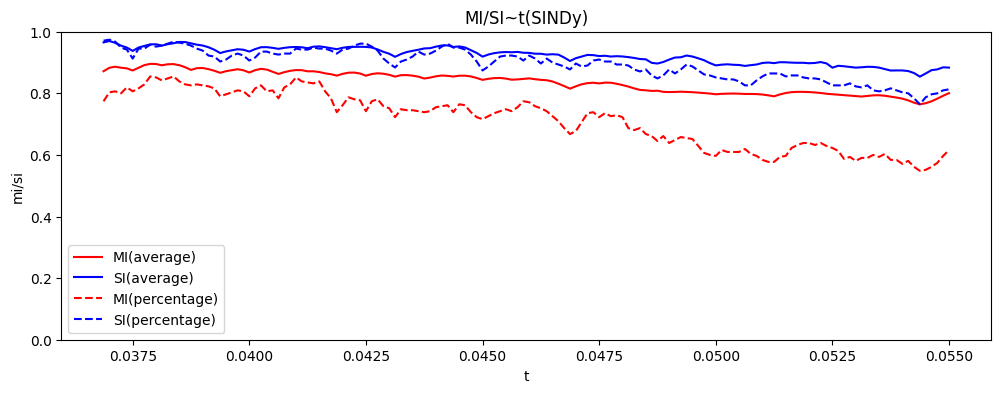

round: 60
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -179.964 1 + 64.020 Vx + 19.756 Vy + 7804.260 t + 38.774 VxVx + -3.261 VyVy + -85862.245 tt + -47.008 VxVy + -1337.279 Vxt + -393.115 Vyt + -3.510 VxVxVy + -799.529 VxVxt + 208.725 VyVyt + 917.179 VxVyt + -179.643 Vx_2 + 1855.892 Vy_2 + 430.470 Vx_1 + -1701.030 Vy_1 + -200.006 VxVx_2 + 566.892 VxVy_2 + 6920.075 Vxt_2 + -52.923 VyVx_2 + -88.668 VyVy_2 + -82194.441 Vyt_2 + 94.121 tVx_2 + 3489.958 tVy_2 + -12517.711 tt_2 + 3.530 VxVxVx_2 + 880.800 VxVxVy_2 + 1659.168 VxVxt_2 + -2190.010 VyVyVx_2 + -94.197 VyVyVy_2 + -112.001 VyVyt_2 + -77549.395 ttVx_2 + -127.358 ttVy_2 + -15.454 ttt_2 + 796330.708 VxVyVx_2 + 149.291 VxVyVy_2 + 1597.647 VxVyt_2 + 2112.619 VxtVx_2 + 14.736 VxtVy_2 + 2476.818 Vxtt_2 + 440.491 VytVx_2 + -2305.923 VytVy_2 + 35.788 VxVx_1 + -14.210 VxVy_1 + -20322.121 Vxt_1 + 38.469 VyVx_1 + 180.724 VyVy_1 + 242069.556 Vyt_1 + -85.213 tVx_1 + -221.035 tVy_1 + 148.572 tt_1 + -11.823 VxVxVx_1 + -578.170 VxVxVy_1 + -4104.129 VxVxt_1

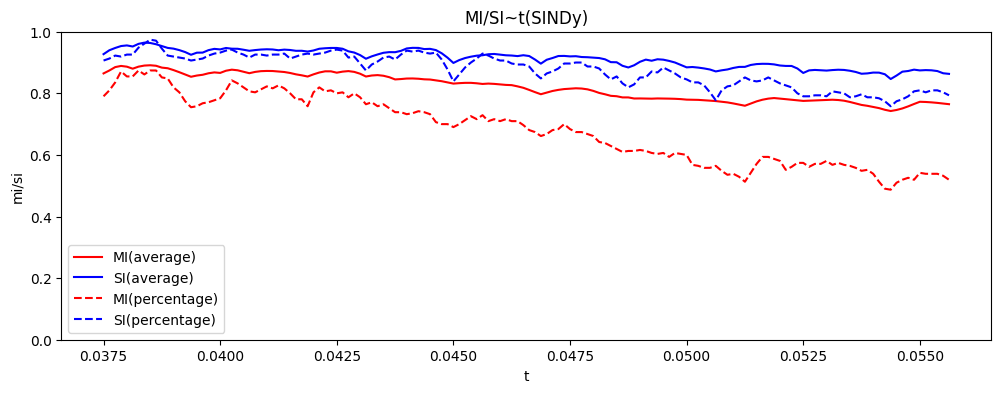

round: 61
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -223.073 1 + 55.063 Vx + -75.666 Vy + 9600.753 t + 7.369 VxVx + 17.135 VyVy + -104540.785 tt + -35.395 VxVy + -1064.833 Vxt + 1592.690 Vyt + -3.412 VxVxVy + -71.394 VxVxt + -200.379 VyVyt + 626.952 VxVyt + 1047.841 Vx_2 + -423.619 Vy_2 + 1461.784 Vx_1 + -2672.605 Vy_1 + -96.802 VxVx_2 + 583.468 VxVy_2 + -46799.598 Vxt_2 + -35.217 VyVx_2 + 274.172 VyVy_2 + 499145.312 Vyt_2 + 379.749 tVx_2 + 1091.982 tVy_2 + -13178.431 tt_2 + 5.904 VxVxVx_2 + 409.735 VxVxVy_2 + -5610.725 VxVxt_2 + -7929.888 VyVyVx_2 + -45.397 VyVyVy_2 + -451.223 VyVyt_2 + 21611.713 ttVx_2 + -293.063 ttVy_2 + 120.270 ttt_2 + -269261.253 VxVyVx_2 + -603.053 VxVyVy_2 + 1035.040 VxVyt_2 + 9636.288 VxtVx_2 + 26.627 VxtVy_2 + 5646.736 Vxtt_2 + -2595.985 VytVx_2 + 13918.033 VytVy_2 + -100.908 VxVx_1 + -46.355 VxVy_1 + -64575.760 Vxt_1 + -28.896 VyVx_1 + 151.753 VyVy_1 + 710365.340 Vyt_1 + 0.006 tVx_1 + 2963.156 tVy_1 + 801.502 tt_1 + -11.084 VxVxVx_1 + 862.009 VxVxVy_1 + -3329.311

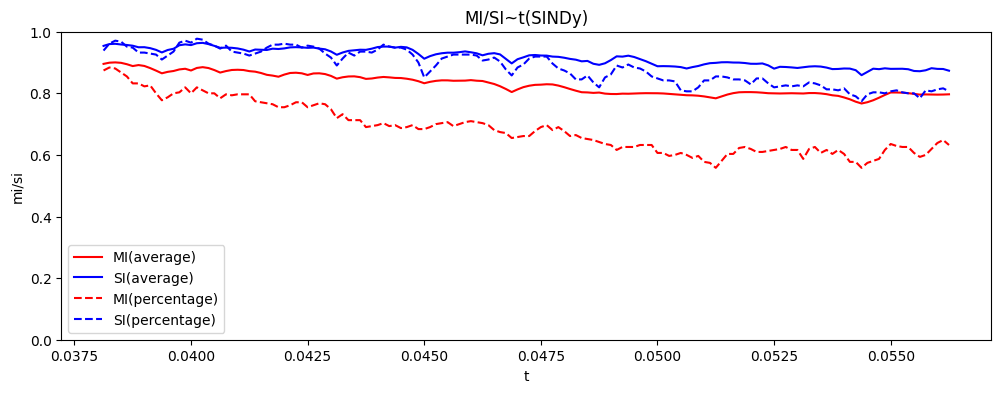

round: 62
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -796.716 1 + -22.974 Vx + -13.203 Vy + 33877.579 t + -46.943 VxVx + 92.371 VyVy + -358538.324 tt + -61.119 VxVy + 551.924 Vxt + 419.656 Vyt + -2.933 VxVxVy + 1018.431 VxVxt + -1879.106 VyVyt + 1325.478 VxVyt + 1640.047 Vx_2 + 70.449 Vy_2 + -28.322 Vx_1 + -306.550 Vy_1 + 80.091 VxVx_2 + 416.776 VxVy_2 + -72128.966 Vxt_2 + 5.215 VyVx_2 + 87.520 VyVy_2 + 766058.405 Vyt_2 + 143.317 tVx_2 + -2755.106 tVy_2 + -9621.264 tt_2 + 1.955 VxVxVx_2 + -382.988 VxVxVy_2 + -1742.891 VxVxt_2 + -3057.580 VyVyVx_2 + -26.324 VyVyVy_2 + -274.397 VyVyt_2 + 112.404 ttVx_2 + -395.417 ttVy_2 + 94.259 ttt_2 + -40301.611 VxVyVx_2 + -137.930 VxVyVy_2 + 827.465 VxVyt_2 + 5916.213 VxtVx_2 + 25.486 VxtVy_2 + 8162.488 Vxtt_2 + -1984.913 VytVx_2 + 3837.558 VytVy_2 + 42.584 VxVx_1 + -249.322 VxVy_1 + 172.112 Vxt_1 + 51.476 VyVx_1 + 297.562 VyVy_1 + 10537.069 Vyt_1 + -13.507 tVx_1 + -382.115 tVy_1 + 5798.312 tt_1 + -13.448 VxVxVx_1 + -827.555 VxVxVy_1 + -6833.322 VxVxt_1 + 

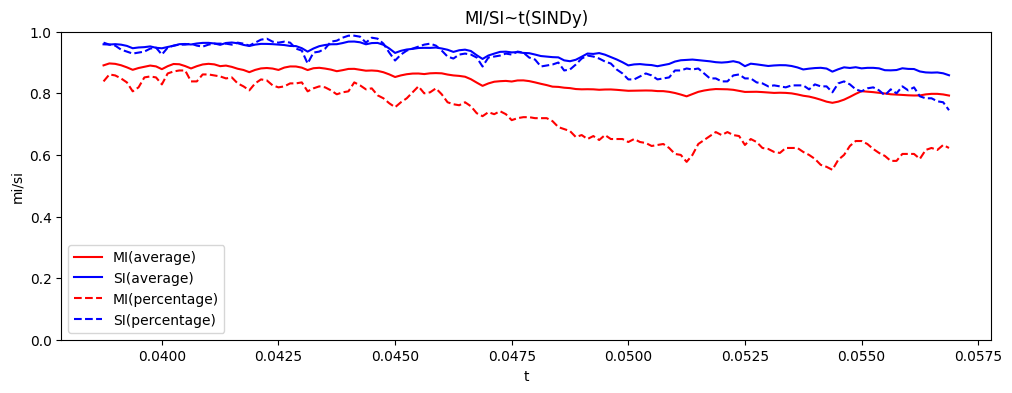

round: 63
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1028.099 1 + -15.421 Vx + -194.977 Vy + 42517.764 t + -30.068 VxVx + 99.063 VyVy + -437354.533 tt + -139.505 VxVy + 192.984 Vxt + 4184.974 Vyt + 5.091 VxVxVy + 499.813 VxVxt + -2065.353 VyVyt + 3005.052 VxVyt + 3225.908 Vx_2 + -1960.518 Vy_2 + 1857.770 Vx_1 + -1554.404 Vy_1 + -85.268 VxVx_2 + 935.660 VxVy_2 + -136288.132 Vxt_2 + -30.722 VyVx_2 + 89.871 VyVy_2 + 1409648.616 Vyt_2 + 231.293 tVx_2 + 652.974 tVy_2 + -21076.554 tt_2 + 1.973 VxVxVx_2 + 278.046 VxVxVy_2 + -1682.990 VxVxt_2 + -5458.634 VyVyVx_2 + -214.429 VyVyVy_2 + -458.491 VyVyt_2 + 86002.152 ttVx_2 + -474.611 ttVy_2 + 107.628 ttt_2 + -934865.113 VxVyVx_2 + -446.962 VxVyVy_2 + 5070.808 VxVyt_2 + 9367.435 VxtVx_2 + 36.385 VxtVy_2 + 9669.163 Vxtt_2 + -2192.815 VytVx_2 + 10548.613 VytVy_2 + -236.381 VxVx_1 + 250.327 VxVy_1 + -78290.480 Vxt_1 + -9.735 VyVx_1 + 125.026 VyVy_1 + 819611.556 Vyt_1 + 21.336 tVx_1 + 4570.180 tVy_1 + -5075.273 tt_1 + -1.126 VxVxVx_1 + 113.010 VxVxVy_1 + 

round: 64
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -235.922 1 + -98.276 Vx + -46.162 Vy + 8778.645 t + -56.951 VxVx + 75.933 VyVy + -82086.171 tt + -29.887 VxVy + 1991.044 Vxt + 1180.265 Vyt + -2.827 VxVxVy + 1173.700 VxVxt + -1494.771 VyVyt + 588.145 VxVyt + 377.763 Vx_2 + -439.283 Vy_2 + -1993.828 Vx_1 + 844.016 Vy_1 + 30.600 VxVx_2 + 726.087 VxVy_2 + -24817.221 Vxt_2 + 8.129 VyVx_2 + 129.913 VyVy_2 + 328066.690 Vyt_2 + 368.736 tVx_2 + -1849.442 tVy_2 + -15990.632 tt_2 + 3.137 VxVxVx_2 + -525.486 VxVxVy_2 + -2529.696 VxVxt_2 + -7705.739 VyVyVx_2 + -44.387 VyVyVy_2 + -356.485 VyVyt_2 + 19480.634 ttVx_2 + -361.774 ttVy_2 + 86.032 ttt_2 + -215778.141 VxVyVx_2 + -342.560 VxVyVy_2 + 1259.252 VxVyt_2 + 7516.695 VxtVx_2 + 25.595 VxtVy_2 + 7221.959 Vxtt_2 + -1894.892 VytVx_2 + 8185.179 VytVy_2 + 110.228 VxVx_1 + -17.265 VxVy_1 + 79931.594 Vxt_1 + 34.283 VyVx_1 + 37.976 VyVy_1 + -789231.130 Vyt_1 + -71.173 tVx_1 + -1844.381 tVy_1 + 273.051 tt_1 + -11.924 VxVxVx_1 + -515.724 VxVxVy_1 + -1097.520 

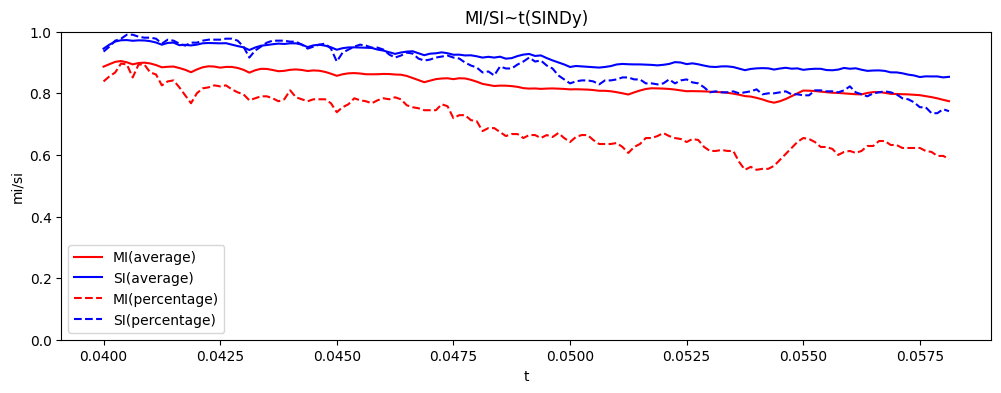

round: 65
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -690.485 1 + -104.440 Vx + -41.052 Vy + 28331.721 t + -70.011 VxVx + 107.584 VyVy + -289606.251 tt + 53.985 VxVy + 2387.818 Vxt + 1020.453 Vyt + -9.698 VxVxVy + 1636.921 VxVxt + -2167.626 VyVyt + -1292.415 VxVyt + -1453.673 Vx_2 + -837.782 Vy_2 + -3230.110 Vx_1 + -462.124 Vy_1 + -155.551 VxVx_2 + 622.658 VxVy_2 + 56642.157 Vxt_2 + -18.577 VyVx_2 + 178.104 VyVy_2 + -558996.636 Vyt_2 + 479.454 tVx_2 + 3009.298 tVy_2 + -14028.981 tt_2 + -7.567 VxVxVx_2 + 327.003 VxVxVy_2 + -3116.071 VxVxt_2 + -10240.166 VyVyVx_2 + -213.057 VyVyVy_2 + -245.137 VyVyt_2 + 37164.564 ttVx_2 + -390.456 ttVy_2 + 51.592 ttt_2 + -413368.272 VxVyVx_2 + -385.057 VxVyVy_2 + 4314.962 VxVyt_2 + 5139.771 VxtVx_2 + 30.172 VxtVy_2 + 7533.032 Vxtt_2 + -1119.475 VytVx_2 + 8859.208 VytVy_2 + -140.869 VxVx_1 + 169.839 VxVy_1 + 130250.179 Vxt_1 + 6.996 VyVx_1 + 260.203 VyVy_1 + -1298780.678 Vyt_1 + 379.942 tVx_1 + 2979.419 tVy_1 + -3039.904 tt_1 + -4.838 VxVxVx_1 + -210.188 VxVxV

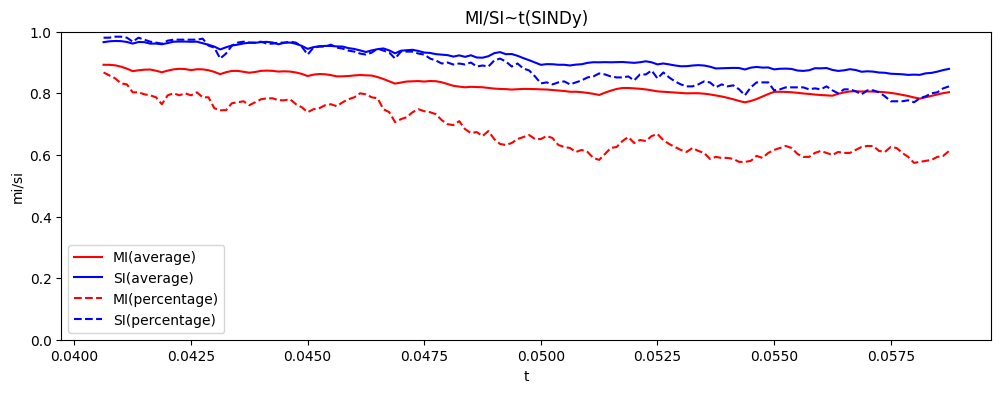

round: 66
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -39.602 1 + -0.869 Vx + -13.690 Vy + 1114.889 t + -64.923 VxVx + 104.413 VyVy + -8142.106 tt + -56.132 VxVy + 306.610 Vxt + 507.958 Vyt + -8.810 VxVxVy + 1529.937 VxVxt + -2061.680 VyVyt + 1038.686 VxVyt + -772.303 Vx_2 + -1159.485 Vy_2 + -763.974 Vx_1 + 1519.686 Vy_1 + -88.079 VxVx_2 + 837.113 VxVy_2 + 27956.203 Vxt_2 + -70.888 VyVx_2 + 3.421 VyVy_2 + -258453.409 Vyt_2 + 83.120 tVx_2 + 1777.113 tVy_2 + -18616.131 tt_2 + -14.830 VxVxVx_2 + 1530.228 VxVxVy_2 + 51.119 VxVxt_2 + -2751.582 VyVyVx_2 + -207.413 VyVyVy_2 + -71.162 VyVyt_2 + 45988.649 ttVx_2 + -275.804 ttVy_2 + 36.395 ttt_2 + -458478.930 VxVyVx_2 + -244.235 VxVyVy_2 + 3784.940 VxVyt_2 + 1709.195 VxtVx_2 + 41.828 VxtVy_2 + 5206.187 Vxtt_2 + -875.951 VytVx_2 + 6892.741 VytVy_2 + -44.095 VxVx_1 + 75.921 VxVy_1 + 30466.527 Vxt_1 + -8.746 VyVx_1 + 86.885 VyVy_1 + -293201.716 Vyt_1 + 45.816 tVx_1 + 1346.862 tVy_1 + -1902.522 tt_1 + -12.576 VxVxVx_1 + 311.112 VxVxVy_1 + -1996.969 VxVxt_

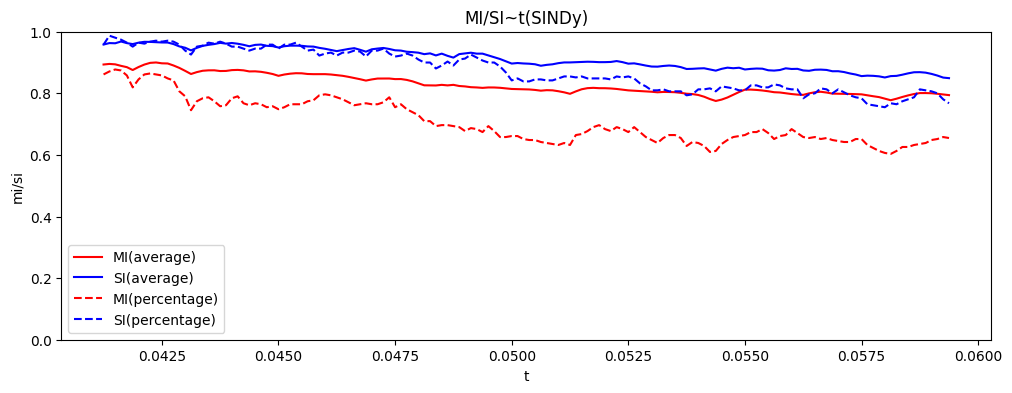

round: 67
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 335.557 1 + -72.585 Vx + -77.811 Vy + -13835.902 t + -65.488 VxVx + 157.098 VyVy + 139479.915 tt + -74.768 VxVy + 1499.948 Vxt + 1768.643 Vyt + -5.070 VxVxVy + 1432.252 VxVxt + -3134.043 VyVyt + 1375.195 VxVyt + 70.715 Vx_2 + 2902.162 Vy_2 + -2360.413 Vx_1 + -1144.989 Vy_1 + 138.206 VxVx_2 + 104.389 VxVy_2 + -7970.452 Vxt_2 + -21.379 VyVx_2 + -286.400 VyVy_2 + 119164.427 Vyt_2 + -372.554 tVx_2 + -3206.679 tVy_2 + -3829.180 tt_2 + -8.939 VxVxVx_2 + 332.145 VxVxVy_2 + 5772.209 VxVxt_2 + 6497.043 VyVyVx_2 + -660.153 VyVyVy_2 + 83.423 VyVyt_2 + -114962.384 ttVx_2 + -109.113 ttVy_2 + -150.646 ttt_2 + 1125179.434 VxVyVx_2 + 575.392 VxVyVy_2 + 13555.116 VxVyt_2 + -1499.157 VxtVx_2 + 19.117 VxtVy_2 + 2175.616 Vxtt_2 + 2965.370 VytVx_2 + -10431.624 VytVy_2 + 352.743 VxVx_1 + -210.684 VxVy_1 + 93960.707 Vxt_1 + 113.617 VyVx_1 + 98.403 VyVy_1 + -922125.830 Vyt_1 + -94.423 tVx_1 + -6941.468 tVy_1 + 4137.511 tt_1 + -4.340 VxVxVx_1 + -2310.286 VxVxVy_1

round: 68
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 547.315 1 + -68.361 Vx + 35.772 Vy + -21659.024 t + -100.756 VxVx + 122.836 VyVy + 210635.540 tt + -67.822 VxVy + 1462.132 Vxt + -516.596 Vyt + -8.200 VxVxVy + 2171.410 VxVxt + -2411.809 VyVyt + 1153.569 VxVyt + 2443.973 Vx_2 + 4865.766 Vy_2 + -2002.353 Vx_1 + -783.440 Vy_1 + 246.648 VxVx_2 + -79.554 VxVy_2 + -97259.076 Vxt_2 + 24.222 VyVx_2 + -40.573 VyVy_2 + 951584.371 Vyt_2 + -223.152 tVx_2 + -5027.057 tVy_2 + -272.310 tt_2 + -14.849 VxVxVx_2 + -521.258 VxVxVy_2 + 1424.444 VxVxt_2 + 3415.677 VyVyVx_2 + -213.916 VyVyVy_2 + -358.279 VyVyt_2 + -186960.293 ttVx_2 + -399.957 ttVy_2 + 87.241 ttt_2 + 1776086.097 VxVyVx_2 + -243.180 VxVyVy_2 + 4070.060 VxVyt_2 + 7215.211 VxtVx_2 + 45.205 VxtVy_2 + 7235.726 Vxtt_2 + -1693.783 VytVx_2 + 6133.359 VytVy_2 + 190.920 VxVx_1 + -117.570 VxVy_1 + 79588.035 Vxt_1 + 55.563 VyVx_1 + 47.198 VyVy_1 + -779878.767 Vyt_1 + -8.733 tVx_1 + -4132.588 tVy_1 + 2210.919 tt_1 + -1322.151 VxVxVy_1 + -1103.772 VxVxt_1 

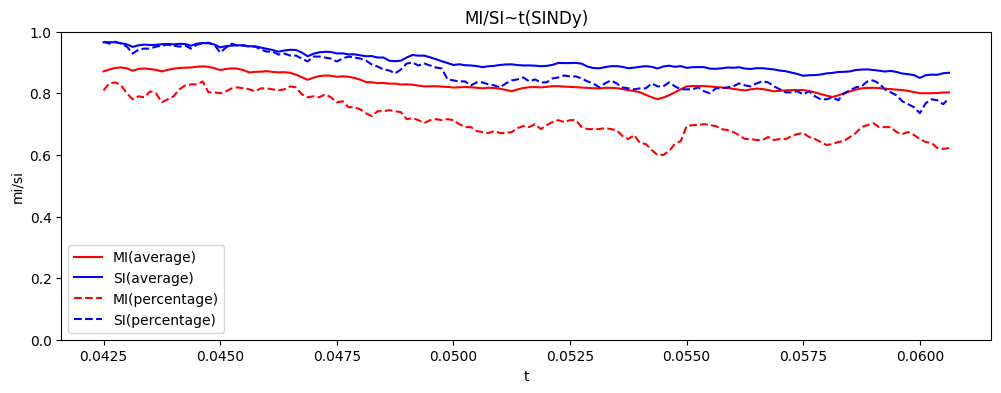

round: 69
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -110.702 Vx + -121.226 Vy + -436.901 t + -110.579 VxVx + 219.931 VyVy + 6718.330 tt + -169.399 VxVy + 2233.817 Vxt + 2620.852 Vyt + -4.576 VxVxVy + 2272.462 VxVxt + -4267.203 VyVyt + 3186.909 VxVyt + 1753.024 Vx_2 + -103.061 Vy_2 + 386.605 Vx_1 + 2042.876 Vy_1 + 35.375 VxVx_2 + -552.773 VxVy_2 + -75886.122 Vxt_2 + -18.285 VyVx_2 + 163.734 VyVy_2 + 794420.056 Vyt_2 + -404.237 tVx_2 + -1536.185 tVy_2 + 8921.698 tt_2 + -11.413 VxVxVx_2 + 162.431 VxVxVy_2 + -2987.338 VxVxt_2 + 6906.527 VyVyVx_2 + -172.107 VyVyVy_2 + 75.651 VyVyt_2 + 7306.965 ttVx_2 + -414.741 ttVy_2 + 83.481 ttt_2 + -102509.679 VxVyVx_2 + 35.010 VxVyVy_2 + 4738.264 VxVyt_2 + -1907.003 VxtVx_2 + 21.222 VxtVy_2 + 8322.052 Vxtt_2 + -1510.748 VytVx_2 + -74.924 VytVy_2 + 544.225 VxVx_1 + -325.329 VxVy_1 + -7860.981 Vxt_1 + 139.183 VyVx_1 + -21.931 VyVy_1 + 16557.903 Vyt_1 + -298.263 tVx_1 + -9624.838 tVy_1 + 5513.704 tt_1 + -20.614 VxVxVx_1 + -2384.733 VxVxVy_1 + 826.362 VxVxt_1 +

round: 70
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1538.020 1 + -144.231 Vx + -71.024 Vy + -59089.045 t + -49.078 VxVx + 70.095 VyVy + 560988.561 tt + -39.451 VxVy + 2668.912 Vxt + 1659.489 Vyt + 0.794 VxVxVy + 1107.477 VxVxt + -1442.532 VyVyt + 1023.605 VxVyt + -9.604 Vx_2 + 596.077 Vy_2 + -750.215 Vx_1 + -1243.643 Vy_1 + -18.597 VxVx_2 + -328.293 VxVy_2 + -3827.436 Vxt_2 + -32.292 VyVx_2 + 37.057 VyVy_2 + 71625.287 Vyt_2 + -363.231 tVx_2 + -253.098 tVy_2 + 4278.063 tt_2 + -10.030 VxVxVx_2 + 422.481 VxVxVy_2 + -704.029 VxVxt_2 + 5812.396 VyVyVx_2 + -366.264 VyVyVy_2 + 160.721 VyVyt_2 + -25137.996 ttVx_2 + -49.579 ttVy_2 + -167.016 ttt_2 + 259672.057 VxVyVx_2 + 512.252 VxVyVy_2 + 9619.789 VxVyt_2 + -3505.306 VxtVx_2 + -15.312 VxtVy_2 + 2588.660 Vxtt_2 + 3311.942 VytVx_2 + -10178.531 VytVy_2 + 673.072 VxVx_1 + 113.360 VxVy_1 + 33542.872 Vxt_1 + 96.532 VyVx_1 + -407.664 VyVy_1 + -354304.644 Vyt_1 + -497.893 tVx_1 + -12463.347 tVy_1 + -2194.217 tt_1 + -3.381 VxVxVx_1 + -1998.385 VxVxVy_1 + 7

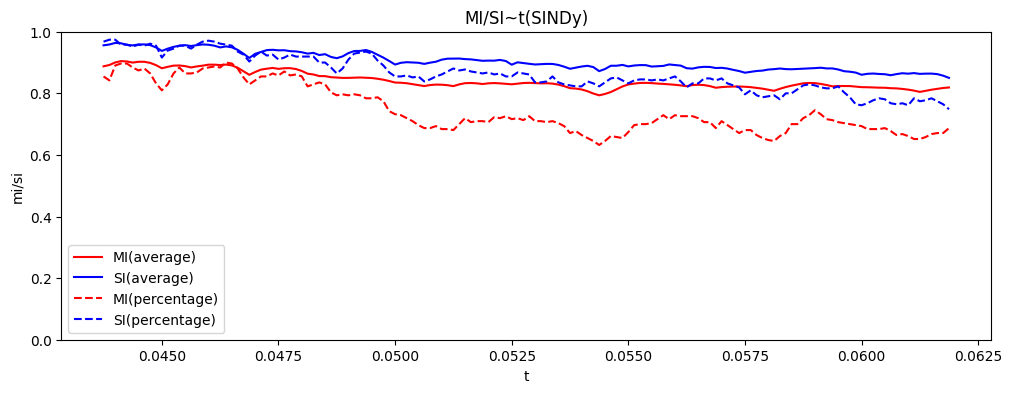

round: 71
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 524.982 1 + -59.804 Vx + -137.212 Vy + -21128.305 t + -42.799 VxVx + 54.854 VyVy + 208037.020 tt + -37.215 VxVy + 935.604 Vxt + 2853.523 Vyt + 2.804 VxVxVy + 729.226 VxVxt + -1120.142 VyVyt + 852.594 VxVyt + 310.561 Vx_2 + -10.537 Vy_2 + 56.514 Vx_1 + 2038.337 Vy_1 + 49.556 VxVx_2 + -22.520 VxVy_2 + -20429.461 Vxt_2 + 58.559 VyVx_2 + 188.426 VyVy_2 + 266472.882 Vyt_2 + -4.009 tVx_2 + -1232.017 tVy_2 + -1065.667 tt_2 + -8.437 VxVxVx_2 + -1157.624 VxVxVy_2 + -3516.210 VxVxt_2 + -783.602 VyVyVx_2 + -269.571 VyVyt_2 + -5871.282 ttVx_2 + -266.522 ttVy_2 + 313.247 ttt_2 + 113734.562 VxVyVx_2 + -52.618 VxVyVy_2 + 759.203 VxVyt_2 + 5150.471 VxtVx_2 + 30.935 VxtVy_2 + 5048.135 Vxtt_2 + -6193.777 VytVx_2 + 1680.271 VytVy_2 + 169.471 VxVx_1 + 194.762 VxVy_1 + 1540.358 Vxt_1 + 63.731 VyVx_1 + -466.021 VyVy_1 + -42891.221 Vyt_1 + -336.084 tVx_1 + -3154.952 tVy_1 + -3893.982 tt_1 + -12.648 VxVxVx_1 + -1112.837 VxVxVy_1 + 8719.458 VxVxt_1 + 6165.302 VyV

round: 72
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 843.520 1 + -1.276 Vx + -141.897 Vy + -32975.953 t + -69.785 VxVx + 78.903 VyVy + 317384.517 tt + -162.822 VxVy + -234.255 Vxt + 3003.390 Vyt + 5.894 VxVxVy + 1205.854 VxVxt + -1605.925 VyVyt + 3305.103 VxVyt + 1353.189 Vx_2 + 864.961 Vy_2 + 46.322 Vx_1 + 1002.223 Vy_1 + 256.170 VxVx_2 + -193.927 VxVy_2 + -60862.646 Vxt_2 + 129.044 VyVx_2 + 593.529 VyVy_2 + 654305.552 Vyt_2 + -120.466 tVx_2 + -4955.511 tVy_2 + 2085.948 tt_2 + -17.964 VxVxVx_2 + -2344.504 VxVxVy_2 + -10851.941 VxVxt_2 + 1148.794 VyVyVx_2 + -963.514 VyVyVy_2 + -9.965 VyVyt_2 + -38055.239 ttVx_2 + -366.133 ttVy_2 + 117.972 ttt_2 + 406577.448 VxVyVx_2 + 378.196 VxVyVy_2 + 19273.815 VxVyt_2 + -81.927 VxtVx_2 + 21.467 VxtVy_2 + 7305.816 Vxtt_2 + -2254.860 VytVx_2 + -6865.872 VytVy_2 + 525.077 VxVx_1 + -56.557 VxVy_1 + 4447.610 Vxt_1 + 183.005 VyVx_1 + -399.029 VyVy_1 + -91454.194 Vyt_1 + -383.794 tVx_1 + -9466.604 tVy_1 + 924.122 tt_1 + -14.748 VxVxVx_1 + -3312.822 VxVxVy_1 + 7

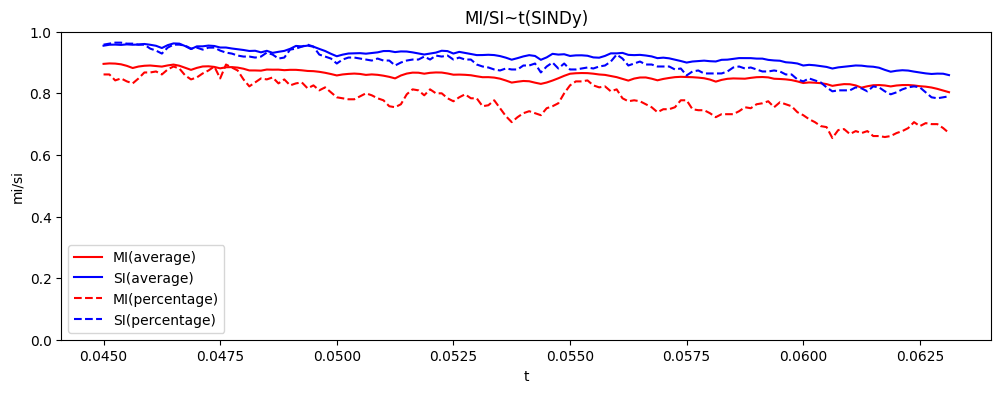

round: 73
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 968.491 1 + -160.939 Vx + -58.853 Vy + -36691.673 t + -161.056 VxVx + 155.051 VyVy + 343579.593 tt + -93.327 VxVy + 2669.807 Vxt + 1401.936 Vyt + 6.595 VxVxVy + 2878.328 VxVxt + -3052.295 VyVyt + 2118.408 VxVyt + -2110.481 Vx_2 + 3902.091 Vy_2 + 3229.964 Vx_1 + 838.670 Vy_1 + 93.251 VxVx_2 + -138.602 VxVy_2 + 70202.051 Vxt_2 + 137.371 VyVx_2 + 67.351 VyVy_2 + -574142.858 Vyt_2 + -321.265 tVx_2 + -1446.375 tVy_2 + 1134.556 tt_2 + -23.586 VxVxVx_2 + -2290.192 VxVxVy_2 + -1156.186 VxVxt_2 + 4802.506 VyVyVx_2 + -891.618 VyVyVy_2 + 408.397 VyVyt_2 + -145570.063 ttVx_2 + -334.031 ttVy_2 + -108.221 ttt_2 + 1347108.490 VxVyVx_2 + 803.648 VxVyVy_2 + 17713.402 VxVyt_2 + -8199.488 VxtVx_2 + 11.729 VxtVy_2 + 7038.159 Vxtt_2 + 2166.407 VytVx_2 + -14696.201 VytVy_2 + 17.896 VxVx_1 + -37.984 VxVy_1 + -119123.726 Vxt_1 + 139.921 VyVx_1 + -105.715 VyVy_1 + 1092013.666 Vyt_1 + 13.306 tVx_1 + -800.038 tVy_1 + 691.652 tt_1 + -4.892 VxVxVx_1 + -2791.326 VxVxV

round: 74
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 799.173 1 + 110.659 Vx + -68.923 Vy + -30208.822 t + -30.900 VxVx + 60.638 VyVy + 282256.653 tt + -5.341 VxVy + -2233.527 Vxt + 1660.617 Vyt + 0.162 VxVxVy + 519.911 VxVxt + -1339.591 VyVyt + 370.792 VxVyt + 3293.765 Vx_2 + 1753.365 Vy_2 + 754.772 Vx_1 + 571.416 Vy_1 + -50.930 VxVx_2 + -587.280 VxVy_2 + -131855.040 Vxt_2 + 51.716 VyVx_2 + 429.518 VyVy_2 + 1295931.607 Vyt_2 + -169.682 tVx_2 + 617.906 tVy_2 + 10010.815 tt_2 + -20.519 VxVxVx_2 + -708.503 VxVxVy_2 + -8048.284 VxVxt_2 + 2749.568 VyVyVx_2 + -64.116 VyVyVy_2 + 303.951 VyVyt_2 + -64894.103 ttVx_2 + -9.021 ttVy_2 + -160.218 ttt_2 + 598788.221 VxVyVx_2 + 108.563 VxVyVy_2 + 2258.673 VxVyt_2 + -6086.393 VxtVx_2 + 25.120 VxtVy_2 + 16.216 Vxtt_2 + 3059.632 VytVx_2 + -2179.537 VytVy_2 + 368.735 VxVx_1 + 752.142 VxVy_1 + -22501.864 Vxt_1 + 75.900 VyVx_1 + -610.503 VyVy_1 + 166000.562 Vyt_1 + -50.290 tVx_1 + -6552.205 tVy_1 + -12848.479 tt_1 + -8.253 VxVxVx_1 + -1433.659 VxVxVy_1 + 10356.

round: 75
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1405.336 1 + 86.202 Vx + -97.697 Vy + -51439.968 t + -5.214 VxVx + 91.919 VyVy + 466485.007 tt + -72.126 VxVy + -2026.802 Vxt + 2232.258 Vyt + 11.768 VxVxVy + -84.009 VxVxt + -1924.111 VyVyt + 1948.745 VxVyt + -877.543 Vx_2 + 1550.368 Vy_2 + 2271.568 Vx_1 + 1805.661 Vy_1 + 23.732 VxVx_2 + -785.388 VxVy_2 + 21516.631 Vxt_2 + 25.267 VyVx_2 + 720.091 VyVy_2 + -99776.270 Vyt_2 + -528.345 tVx_2 + -192.700 tVy_2 + 12364.091 tt_2 + -33.244 VxVxVx_2 + -106.950 VxVxVy_2 + -13106.983 VxVxt_2 + 8211.879 VyVyVx_2 + 127.956 VyVyVy_2 + 322.921 VyVyt_2 + -55964.585 ttVx_2 + 55.440 ttVy_2 + -154.139 ttt_2 + 503977.024 VxVyVx_2 + 35.548 VxVyVy_2 + -1361.837 VxVyt_2 + -6046.601 VxtVx_2 + 53.406 VxtVy_2 + -1085.133 Vxtt_2 + 2683.838 VytVx_2 + 32.556 VytVy_2 + 390.563 VxVx_1 + 995.410 VxVy_1 + -77237.836 Vxt_1 + 56.982 VyVx_1 + -621.929 VyVy_1 + 653738.654 Vyt_1 + -218.505 tVx_1 + -7220.276 tVy_1 + -17406.327 tt_1 + -2.466 VxVxVx_1 + -1228.012 VxVxVy_1 + 106

round: 76
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1282.957 1 + 179.437 Vx + -112.388 Vy + -47008.325 t + 34.969 VxVx + 17.800 VyVy + 425773.640 tt + 0.315 VxVy + -3936.185 Vxt + 2564.985 Vyt + 17.553 VxVxVy + -914.644 VxVxt + -596.350 VyVyt + 791.349 VxVyt + -2251.569 Vx_2 + 1189.953 Vy_2 + -945.255 Vx_1 + 2081.988 Vy_1 + 237.789 VxVx_2 + -145.589 VxVy_2 + 73360.114 Vxt_2 + 17.871 VyVx_2 + 269.669 VyVy_2 + -583528.155 Vyt_2 + -471.741 tVx_2 + -3693.047 tVy_2 + 407.747 tt_2 + -32.269 VxVxVx_2 + 88.455 VxVxVy_2 + -4959.000 VxVxt_2 + 6669.702 VyVyVx_2 + -161.429 VyVyVy_2 + 624.693 VyVyt_2 + -45560.458 ttVx_2 + 210.095 ttVy_2 + -240.936 ttt_2 + 427823.025 VxVyVx_2 + 266.743 VxVyVy_2 + 2901.809 VxVyt_2 + -11329.114 VxtVx_2 + 71.571 VxtVy_2 + -4112.008 Vxtt_2 + 4362.858 VytVx_2 + -3166.665 VytVy_2 + 27.024 VxVx_1 + 1360.292 VxVy_1 + 31490.396 Vxt_1 + -9.188 VyVx_1 + -601.609 VyVy_1 + -260943.943 Vyt_1 + 139.288 tVx_1 + -967.127 tVy_1 + -23868.574 tt_1 + 1.152 VxVxVx_1 + 12.480 VxVxVy_1 + 10259

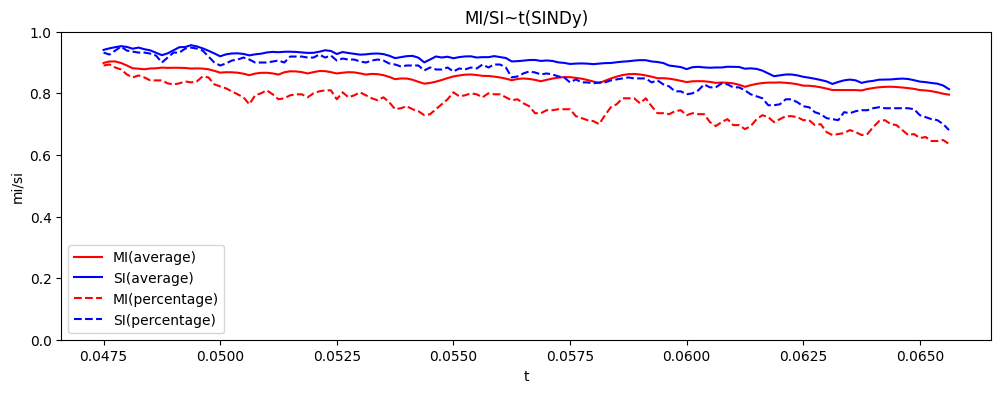

round: 77
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -29.579 1 + -185.404 Vx + 178.112 Vy + -469.949 t + -203.377 VxVx + -32.706 VyVy + 16472.559 tt + 33.465 VxVy + 2501.776 Vxt + -2695.561 Vyt + 23.406 VxVxVy + 3137.199 VxVxt + 295.378 VyVyt + 81.009 VxVyt + -434.196 Vx_2 + -515.785 Vy_2 + -980.701 Vx_1 + -2301.577 Vy_1 + -89.324 VxVx_2 + -958.368 VxVy_2 + 7350.997 Vxt_2 + 100.163 VyVx_2 + 829.887 VyVy_2 + 9812.814 Vyt_2 + 64.632 tVx_2 + 1753.630 tVy_2 + 15119.847 tt_2 + -21.951 VxVxVx_2 + -1474.365 VxVxVy_2 + -15027.391 VxVxt_2 + -2353.324 VyVyVx_2 + 23.666 VyVyVy_2 + 438.899 VyVyt_2 + 13309.416 ttVx_2 + -385.980 ttVy_2 + -120.167 ttt_2 + -75761.808 VxVyVx_2 + -79.101 VxVyVy_2 + 126.675 VxVyt_2 + -8566.511 VxtVx_2 + 61.409 VxtVy_2 + 6600.287 Vxtt_2 + 2513.572 VytVx_2 + 2527.862 VytVy_2 + 283.567 VxVx_1 + 828.440 VxVy_1 + 38609.852 Vxt_1 + -20.596 VyVx_1 + -339.702 VyVy_1 + -373725.797 Vyt_1 + -11.059 tVx_1 + -5034.281 tVy_1 + -14906.147 tt_1 + -2.574 VxVxVx_1 + 409.514 VxVxVy_1 + 5931.158

round: 78
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 105.700 1 + 226.915 Vx + -186.382 Vy + -5558.693 t + 68.125 VxVx + 6.353 VyVy + 63642.365 tt + -24.474 VxVy + -4379.699 Vxt + 3568.975 Vyt + 13.592 VxVxVy + -1293.442 VxVxt + -367.811 VyVyt + 940.271 VxVyt + -1047.233 Vx_2 + -2847.522 Vy_2 + 1871.437 Vx_1 + 96.388 Vy_1 + -129.029 VxVx_2 + 117.713 VxVy_2 + 27367.940 Vxt_2 + -43.900 VyVx_2 + 603.845 VyVy_2 + -155994.786 Vyt_2 + -33.983 tVx_2 + 1605.032 tVy_2 + -3293.908 tt_2 + -14.906 VxVxVx_2 + 692.662 VxVxVy_2 + -11096.475 VxVxt_2 + -306.282 VyVyVx_2 + 210.468 VyVyVy_2 + 124.595 VyVyt_2 + 90318.642 ttVx_2 + 310.995 ttVy_2 + -2.752 ttt_2 + -707110.393 VxVyVx_2 + -219.446 VxVyVy_2 + -3490.878 VxVyt_2 + -3200.216 VxtVx_2 + 74.230 VxtVy_2 + -5651.780 Vxtt_2 + 539.064 VytVx_2 + 5352.753 VytVy_2 + -362.881 VxVx_1 + 946.001 VxVy_1 + -65093.966 Vxt_1 + -214.981 VyVx_1 + -372.285 VyVy_1 + 566295.161 Vyt_1 + 108.076 tVx_1 + 5962.838 tVy_1 + -17510.581 tt_1 + 1.537 VxVxVx_1 + 3593.812 VxVxVy_1 + 662

round: 79
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 369.005 1 + 229.535 Vx + -14276.440 t + -37.933 VxVx + -4.195 VyVy + 135724.874 tt + -36.951 VxVy + -4294.070 Vxt + 310.457 Vyt + 14.747 VxVxVy + 561.013 VxVxt + -150.217 VyVyt + 1066.162 VxVyt + -2851.438 Vx_2 + -312.219 Vy_2 + 3129.438 Vx_1 + -1749.426 Vy_1 + -131.808 VxVx_2 + -572.783 VxVy_2 + 89725.625 Vxt_2 + -102.560 VyVx_2 + 697.365 VyVy_2 + -688569.159 Vyt_2 + -311.328 tVx_2 + 1403.945 tVy_2 + 8636.945 tt_2 + -0.065 VxVxVx_2 + 1496.883 VxVxVy_2 + -13117.194 VxVxt_2 + 4668.625 VyVyVx_2 + -652.679 VyVyVy_2 + 579.491 VyVyt_2 + 3055.138 ttVx_2 + 259.456 ttVy_2 + -198.078 ttt_2 + 37573.799 VxVyVx_2 + 604.267 VxVyVy_2 + 11059.714 VxVyt_2 + -10527.755 VxtVx_2 + 63.955 VxtVy_2 + -4609.242 Vxtt_2 + 3736.767 VytVx_2 + -8413.857 VytVy_2 + -115.031 VxVx_1 + 500.755 VxVy_1 + -106568.515 Vxt_1 + -89.028 VyVx_1 + -70.967 VyVy_1 + 897914.183 Vyt_1 + 137.882 tVx_1 + 1108.868 tVy_1 + -9574.824 tt_1 + 1.786 VxVxVx_1 + 1438.604 VxVxVy_1 + 1584.182 Vx

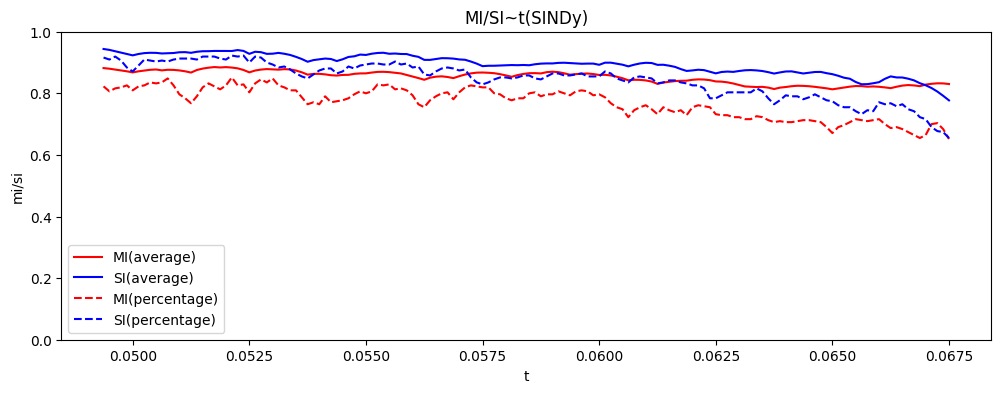

round: 80
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1553.760 1 + 5.082 Vx + 139.002 Vy + -55934.621 t + -108.266 VxVx + -42.472 VyVy + 500195.931 tt + 128.790 VxVy + -156.300 Vxt + -2234.319 Vyt + 13.364 VxVxVy + 1895.903 VxVxt + 621.478 VyVyt + -1840.501 VxVyt + 3887.378 Vx_2 + -2125.834 Vy_2 + -955.754 Vx_1 + -4963.790 Vy_1 + -277.831 VxVx_2 + -1271.522 VxVy_2 + -142059.361 Vxt_2 + -113.837 VyVx_2 + 917.704 VyVy_2 + 1294578.014 Vyt_2 + -501.711 tVx_2 + 4703.114 tVy_2 + 20967.060 tt_2 + -35.444 VxVxVx_2 + 2088.755 VxVxVy_2 + -16639.162 VxVxt_2 + 7011.554 VyVyVx_2 + 302.740 VyVyVy_2 + 1036.938 VyVyt_2 + 70724.303 ttVx_2 + 41.490 ttVy_2 + -494.689 ttt_2 + -581042.105 VxVyVx_2 + 649.221 VxVyVy_2 + -4230.670 VxVyt_2 + -19420.557 VxtVx_2 + 86.270 VxtVy_2 + -427.229 Vxtt_2 + 9268.981 VytVx_2 + -9935.419 VytVy_2 + -51.939 VxVx_1 + -653.265 VxVy_1 + 32928.551 Vxt_1 + -207.134 VyVx_1 + 575.115 VyVy_1 + -283356.787 Vyt_1 + -413.953 tVx_1 + 1315.422 tVy_1 + 10699.531 tt_1 + -24.885 VxVxVx_1 + 3944.5

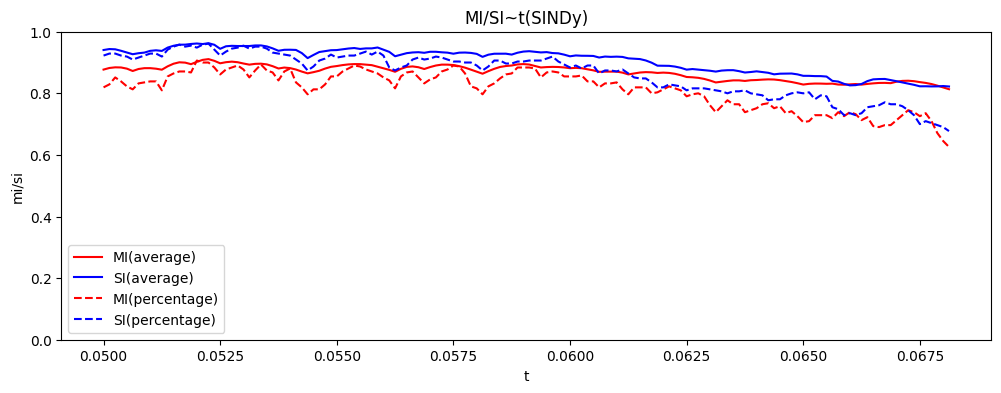

round: 81
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 2229.055 1 + 52.402 Vx + 211.085 Vy + -77580.016 t + -65.117 VxVx + -170.343 VyVy + 671431.371 tt + 41.513 VxVy + -1286.831 Vxt + -3352.637 Vyt + 10.928 VxVxVy + 1079.734 VxVxt + 2777.828 VyVyt + -362.151 VxVyt + -976.792 Vx_2 + -1443.487 Vy_2 + 314.963 Vx_1 + -6384.345 Vy_1 + -470.717 VxVx_2 + -1331.060 VxVy_2 + 20793.887 Vxt_2 + -10.001 VyVx_2 + 1336.496 VyVy_2 + -61593.893 Vyt_2 + 328.996 tVx_2 + 7628.696 tVy_2 + 21608.432 tt_2 + -6.232 VxVxVx_2 + 133.272 VxVxVy_2 + -23796.791 VxVxt_2 + -6280.021 VyVyVx_2 + 487.000 VyVyVy_2 + 760.870 VyVyt_2 + 45302.551 ttVx_2 + -132.543 ttVy_2 + -399.675 ttt_2 + -349584.976 VxVyVx_2 + -438.918 VxVyVy_2 + -8045.063 VxVyt_2 + -14311.000 VxtVx_2 + 63.524 VxtVy_2 + 1906.461 Vxtt_2 + 7536.872 VytVx_2 + 8638.619 VytVy_2 + -373.102 VxVx_1 + -175.752 VxVy_1 + -8298.487 Vxt_1 + -139.177 VyVx_1 + 70.778 VyVy_1 + 48876.645 Vyt_1 + 182.671 tVx_1 + 6465.348 tVy_1 + 2593.889 tt_1 + -4.579 VxVxVx_1 + 2602.407 VxVxVy

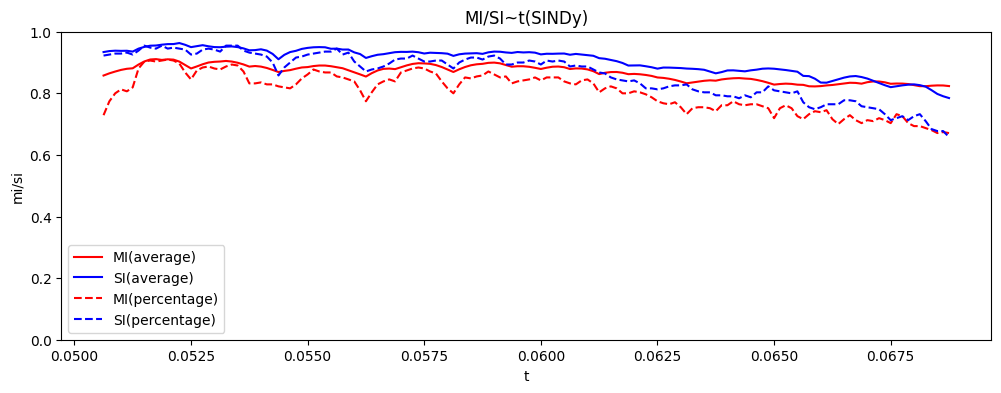

round: 82
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 2671.166 1 + -20.633 Vx + 217.667 Vy + -92770.877 t + -181.074 VxVx + -141.973 VyVy + 801047.580 tt + -4.035 VxVy + 433.422 Vxt + -3585.125 Vyt + -4.772 VxVxVy + 3383.084 VxVxt + 2448.045 VyVyt + 0.042 VxVyt + -1264.835 Vx_2 + -6029.900 Vy_2 + -2895.556 Vx_1 + -10880.660 Vy_1 + 108.330 VxVx_2 + -826.830 VxVy_2 + 30223.879 Vxt_2 + 120.505 VyVx_2 + 561.176 VyVy_2 + -137753.966 Vyt_2 + -112.852 tVx_2 + -1490.309 tVy_2 + 13052.190 tt_2 + -24.855 VxVxVx_2 + -1745.226 VxVxVy_2 + -10147.030 VxVxt_2 + 833.817 VyVyVx_2 + -797.051 VyVyVy_2 + 920.351 VyVyt_2 + 195846.048 ttVx_2 + -604.980 ttVy_2 + -266.567 ttt_2 + -1580099.680 VxVyVx_2 + 645.764 VxVyVy_2 + 14640.558 VxVyt_2 + -17697.679 VxtVx_2 + 30.741 VxtVy_2 + 10684.975 Vxtt_2 + 5829.668 VytVx_2 + -10986.603 VytVy_2 + 169.562 VxVx_1 + -1419.195 VxVy_1 + 101509.524 Vxt_1 + -23.738 VyVx_1 + 623.199 VyVy_1 + -886636.090 Vyt_1 + -316.417 tVx_1 + -2739.819 tVy_1 + 23759.180 tt_1 + -17.834 VxVxVx_1 + 8

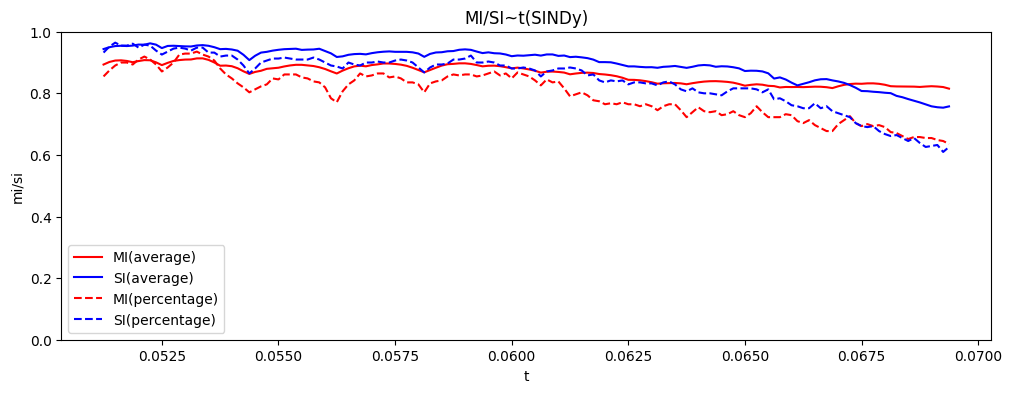

round: 83
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1547.653 1 + 55.390 Vx + 202.722 Vy + -54683.726 t + -111.535 VxVx + -146.859 VyVy + 480476.935 tt + -12.699 VxVy + -976.443 Vxt + -3300.456 Vyt + -4.227 VxVxVy + 2100.624 VxVxt + 2467.982 VyVyt + 247.126 VxVyt + 809.556 Vx_2 + -405.376 Vy_2 + -1890.606 Vx_1 + -3040.825 Vy_1 + -200.547 VxVx_2 + -683.366 VxVy_2 + -38429.040 Vxt_2 + 87.946 VyVx_2 + 648.413 VyVy_2 + 427965.951 Vyt_2 + -180.652 tVx_2 + 3406.703 tVy_2 + 10988.471 tt_2 + -24.613 VxVxVx_2 + -1296.597 VxVxVy_2 + -12071.891 VxVxt_2 + 2228.608 VyVyVx_2 + 260.368 VyVyVy_2 + 1316.133 VyVyt_2 + 12367.614 ttVx_2 + -197.227 ttVy_2 + -561.428 ttt_2 + -92161.895 VxVyVx_2 + 241.795 VxVyVy_2 + -3273.719 VxVyt_2 + -23926.900 VxtVx_2 + 35.607 VxtVy_2 + 3889.005 Vxtt_2 + 10592.324 VytVx_2 + -3864.266 VytVy_2 + 548.614 VxVx_1 + -586.257 VxVy_1 + 65654.173 Vxt_1 + -3.835 VyVx_1 + 432.354 VyVy_1 + -571214.348 Vyt_1 + -1015.692 tVx_1 + -8530.225 tVy_1 + 10324.346 tt_1 + -49.555 VxVxVx_1 + 932.236 

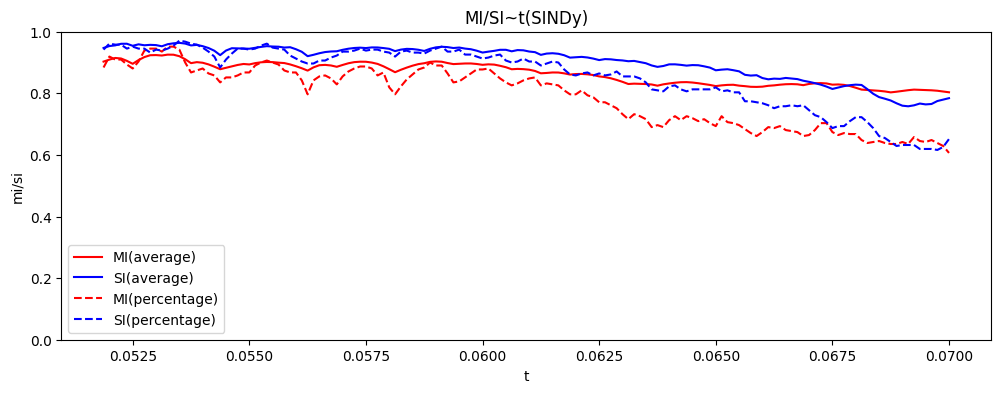

round: 84
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 1615.258 1 + -19.379 Vx + 170.323 Vy + -56989.299 t + -205.396 VxVx + -121.237 VyVy + 499970.031 tt + -31.389 VxVy + 400.220 Vxt + -2792.788 Vyt + -9.799 VxVxVy + 3788.530 VxVxt + 2088.483 VyVyt + 455.433 VxVyt + -1365.268 Vx_2 + -2461.841 Vy_2 + -1091.015 Vx_1 + -5910.133 Vy_1 + -311.754 VxVx_2 + -1401.063 VxVy_2 + 29447.454 Vxt_2 + 192.013 VyVx_2 + 1265.445 VyVy_2 + -97663.124 Vyt_2 + 34.535 tVx_2 + 5307.829 tVy_2 + 23186.705 tt_2 + -34.209 VxVxVx_2 + -2960.544 VxVxVy_2 + -22482.761 VxVxt_2 + -1553.168 VyVyVx_2 + -22.811 VyVyVy_2 + 1570.120 VyVyt_2 + 83280.300 ttVx_2 + -372.591 ttVy_2 + -749.890 ttt_2 + -698629.321 VxVyVx_2 + 180.116 VxVyVy_2 + 1469.232 VxVyt_2 + -28416.896 VxtVx_2 + 42.380 VxtVy_2 + 6883.691 Vxtt_2 + 13767.374 VytVx_2 + -2741.999 VytVy_2 + 348.218 VxVx_1 + -619.982 VxVy_1 + 38734.788 Vxt_1 + -6.485 VyVx_1 + 93.207 VyVy_1 + -348896.216 Vyt_1 + -847.671 tVx_1 + -6158.063 tVy_1 + 12266.589 tt_1 + -38.937 VxVxVx_1 + 542.77

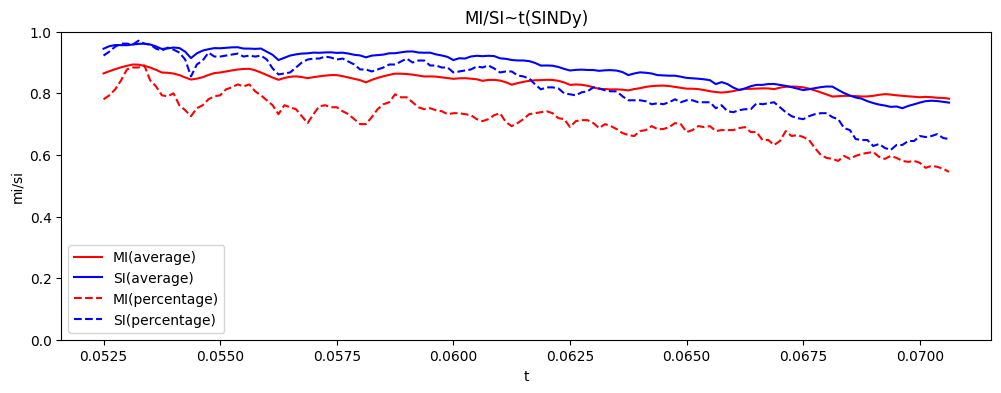

round: 85
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 755.448 1 + -8.148 Vx + 191.760 Vy + -28541.983 t + -168.856 VxVx + -251.363 VyVy + 266024.765 tt + 74.089 VxVy + 547.108 Vxt + -3251.020 Vyt + -15.400 VxVxVy + 3395.748 VxVxt + 4252.881 VyVyt + -1467.311 VxVyt + -220.051 Vx_2 + -5348.742 Vy_2 + 1469.135 Vx_1 + -2397.775 Vy_1 + -125.001 VxVx_2 + -1884.386 VxVy_2 + -6467.138 Vxt_2 + 148.454 VyVx_2 + 2128.630 VyVy_2 + 179808.815 Vyt_2 + 269.789 tVx_2 + 2270.448 tVy_2 + 31698.243 tt_2 + -39.118 VxVxVx_2 + -2149.704 VxVxVy_2 + -36384.815 VxVxt_2 + -5174.670 VyVyVx_2 + 539.329 VyVyVy_2 + 1370.082 VyVyt_2 + 172435.171 ttVx_2 + -514.357 ttVy_2 + -498.191 ttt_2 + -1382980.620 VxVyVx_2 + -661.106 VxVyVy_2 + -7041.458 VxVyt_2 + -25827.342 VxtVx_2 + 10.056 VxtVy_2 + 10076.140 Vxtt_2 + 10076.449 VytVx_2 + 10034.658 VytVy_2 + 593.231 VxVx_1 + -1332.436 VxVy_1 + -43065.434 Vxt_1 + -57.928 VyVx_1 + 693.883 VyVy_1 + 303053.773 Vyt_1 + -737.824 tVx_1 + -10177.996 tVy_1 + 23397.108 tt_1 + -37.156 VxVxVx_1 

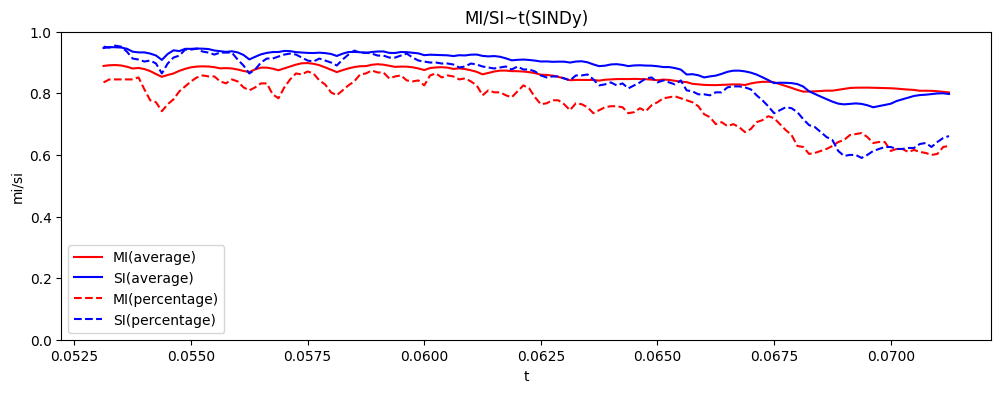

round: 86
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 555.147 1 + 103.858 Vx + 81.851 Vy + -21122.364 t + -122.199 VxVx + -80.635 VyVy + 199297.050 tt + 50.615 VxVy + -1021.564 Vxt + -1426.092 Vyt + -30.677 VxVxVy + 2841.864 VxVxt + 1459.642 VyVyt + -1290.859 VxVyt + -962.472 Vx_2 + -1018.190 Vy_2 + -677.943 Vx_1 + -3100.900 Vy_1 + -376.821 VxVx_2 + -1854.638 VxVy_2 + 17936.684 Vxt_2 + 135.054 VyVx_2 + 1532.350 VyVy_2 + -19021.929 Vyt_2 + 429.752 tVx_2 + 6422.853 tVy_2 + 30495.592 tt_2 + -43.117 VxVxVx_2 + -1822.210 VxVxVy_2 + -26539.943 VxVxt_2 + -7712.874 VyVyVx_2 + 1177.877 VyVyVy_2 + 1328.071 VyVyt_2 + 38057.056 ttVx_2 + -439.132 ttVy_2 + -647.040 ttt_2 + -343527.560 VxVyVx_2 + -1185.537 VxVyVy_2 + -16315.327 VxVyt_2 + -24848.362 VxtVx_2 + -24.839 VxtVy_2 + 9443.884 Vxtt_2 + 12291.470 VytVx_2 + 18331.369 VytVy_2 + 403.976 VxVx_1 + -1625.985 VxVy_1 + 29720.096 Vxt_1 + -120.929 VyVx_1 + 346.928 VyVy_1 + -304105.571 Vyt_1 + -449.551 tVx_1 + -7034.034 tVy_1 + 28073.614 tt_1 + -17.227 VxVxVx_

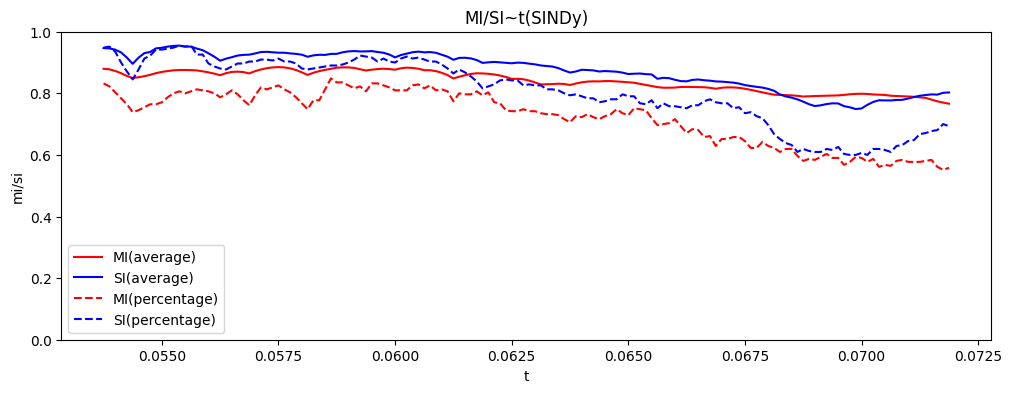

round: 87
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -441.124 1 + 20.885 Vx + 103.657 Vy + 10276.003 t + -105.163 VxVx + -244.884 VyVy + -47245.181 tt + 94.491 VxVy + 159.129 Vxt + -1627.250 Vyt + -21.762 VxVxVy + 2466.768 VxVxt + 3969.623 VyVyt + -1781.125 VxVyt + -2956.350 Vx_2 + -3853.386 Vy_2 + -2353.203 Vx_1 + 5.691 Vy_1 + -360.631 VxVx_2 + -1347.478 VxVy_2 + 83116.372 Vxt_2 + -71.462 VyVx_2 + 1133.707 VyVy_2 + -547234.368 Vyt_2 + 286.955 tVx_2 + 5974.336 tVy_2 + 22281.778 tt_2 + -38.935 VxVxVx_2 + 1281.142 VxVxVy_2 + -19885.394 VxVxt_2 + -5681.965 VyVyVx_2 + 1309.892 VyVyVy_2 + 747.287 VyVyt_2 + 121297.913 ttVx_2 + 29.829 ttVy_2 + -215.650 ttt_2 + -952894.437 VxVyVx_2 + -695.813 VxVyVy_2 + -19050.483 VxVyt_2 + -15127.665 VxtVx_2 + -24.520 VxtVy_2 + 2200.852 Vxtt_2 + 5280.845 VytVx_2 + 10435.764 VytVy_2 + 1026.449 VxVx_1 + -2036.605 VxVy_1 + 79123.735 Vxt_1 + -144.463 VyVx_1 + 1217.794 VyVy_1 + -669572.547 Vyt_1 + -1280.163 tVx_1 + -17337.738 tVy_1 + 34901.544 tt_1 + -57.904 VxVxVx_1 +

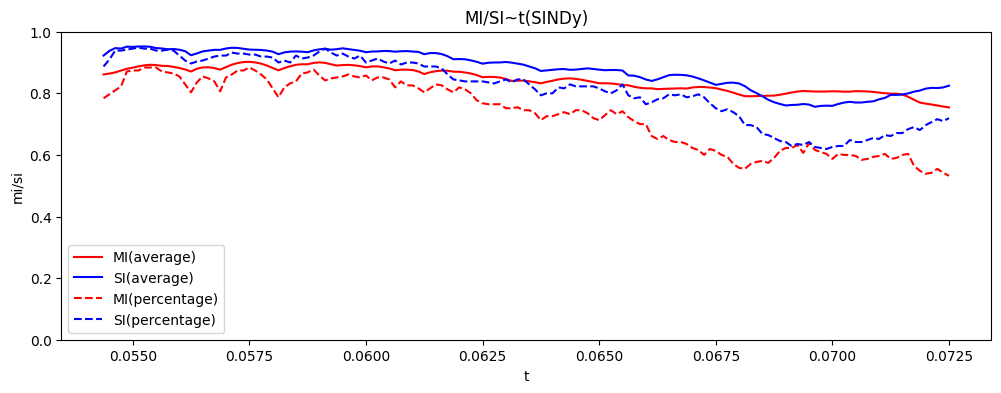

round: 88
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -592.378 1 + 278.468 Vx + 44.877 Vy + 15685.704 t + -72.247 VxVx + -189.817 VyVy + -94652.841 tt + -3.197 VxVy + -3636.724 Vxt + -693.742 Vyt + -43.220 VxVxVy + 2213.583 VxVxt + 3156.619 VyVyt + -497.072 VxVyt + -1009.059 Vx_2 + -3348.776 Vy_2 + 4947.378 Vx_1 + 227.791 Vy_1 + -113.482 VxVx_2 + -1012.996 VxVy_2 + 19626.159 Vxt_2 + 70.128 VyVx_2 + 1037.912 VyVy_2 + -35918.369 Vyt_2 + 180.672 tVx_2 + 2395.053 tVy_2 + 16838.744 tt_2 + -83.372 VxVxVx_2 + -344.567 VxVxVy_2 + -17683.371 VxVxt_2 + -3904.546 VyVyVx_2 + 1591.965 VyVyVy_2 + 907.462 VyVyt_2 + 108317.782 ttVx_2 + -518.834 ttVy_2 + -250.521 ttt_2 + -869853.379 VxVyVx_2 + -698.314 VxVyVy_2 + -23696.980 VxVyt_2 + -17867.162 VxtVx_2 + -9.885 VxtVy_2 + 10217.411 Vxtt_2 + 5818.517 VytVx_2 + 10137.332 VytVy_2 + 866.206 VxVx_1 + -1754.665 VxVy_1 + -152160.873 Vxt_1 + -95.040 VyVx_1 + 783.999 VyVy_1 + 1156961.173 Vyt_1 + -1218.825 tVx_1 + -14376.447 tVy_1 + 30133.537 tt_1 + -53.881 VxVxVx_1 + 

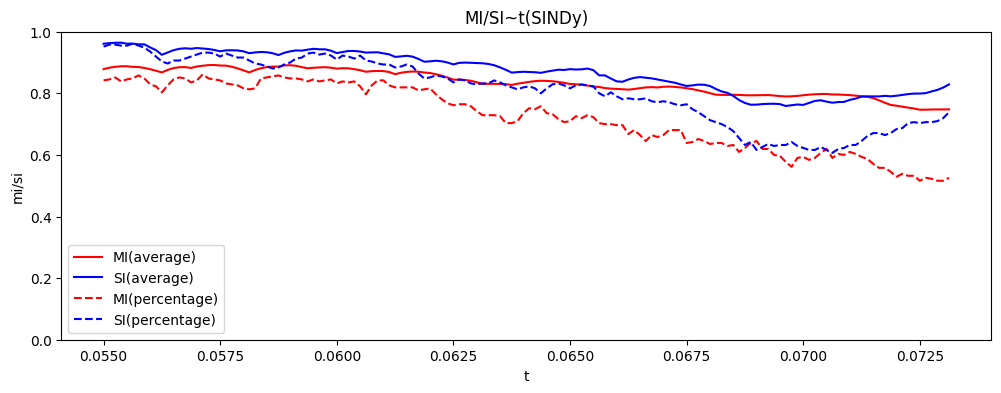

round: 89
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -1496.458 1 + 155.030 Vx + 97.590 Vy + 44011.974 t + -74.671 VxVx + -191.623 VyVy + -315500.402 tt + 98.662 VxVy + -1729.952 Vxt + -1342.436 Vyt + -46.125 VxVxVy + 2232.050 VxVxt + 3062.555 VyVyt + -2149.980 VxVyt + 2296.793 Vx_2 + 458.241 Vy_2 + 2888.109 Vx_1 + 5998.635 Vy_1 + -215.988 VxVx_2 + -1187.275 VxVy_2 + -82065.483 Vxt_2 + 163.811 VyVx_2 + 1142.551 VyVy_2 + 741407.597 Vyt_2 + 460.058 tVx_2 + 3912.683 tVy_2 + 19392.435 tt_2 + -89.184 VxVxVx_2 + -1785.325 VxVxVy_2 + -18994.315 VxVxt_2 + -8298.909 VyVyVx_2 + 2717.793 VyVyVy_2 + 684.988 VyVyt_2 + -12453.332 ttVx_2 + -596.340 ttVy_2 + -126.199 ttt_2 + 82624.271 VxVyVx_2 + -1936.016 VxVyVy_2 + -41286.838 VxVyt_2 + -13791.986 VxtVx_2 + -45.109 VxtVy_2 + 11919.584 Vxtt_2 + 3734.903 VytVx_2 + 29826.322 VytVy_2 + 1477.002 VxVx_1 + -2528.945 VxVy_1 + -90811.984 Vxt_1 + -12.372 VyVx_1 + 2103.819 VyVy_1 + 704890.272 Vyt_1 + -1452.446 tVx_1 + -23753.246 tVy_1 + 41993.716 tt_1 + -75.118 VxVxVx

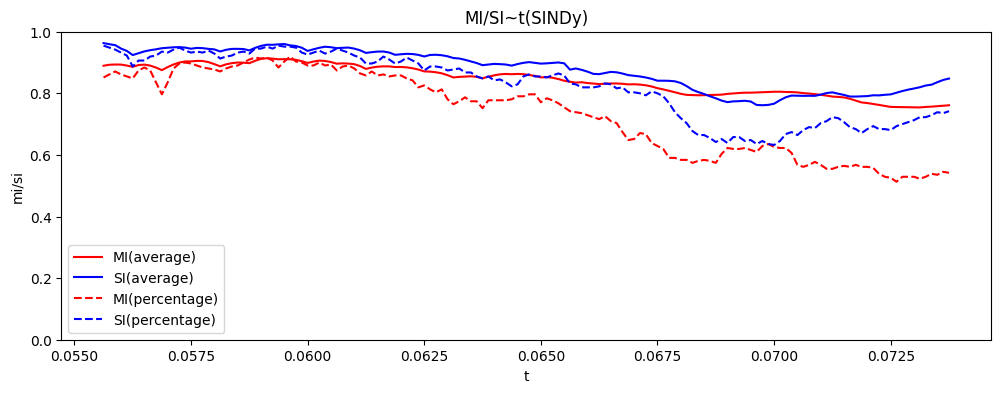

In [6]:
left_bond=0
test_range=90
good_time=np.zeros(test_range)

v_train=np.zeros((n,n,p_tot,3))
t_train=np.zeros(p_tot)
v_test=np.zeros((n,n,p_tot,3))



for k in range(test_range):
    print('round:',k)
    startp=left_bond+k
    endp=left_bond+k+dp
    v_train=u_train[:,:,startp*addp:(endp-1)*addp+1]   
    t_train=v_train[0,0,:,2]
    
    dt_train=v_train[0,0,1,2]-v_train[0,0,0,2]
    
    
    v_test=u_test[:,:,startp*addp:(endp-1)*addp+1]
    
    print(v_train.shape)
    print(t_train.shape)
    
    
    '''
    np.save('v_train.npy',v_train)
    np.savetxt('v_train_dot.txt',v_train_dot)
    np.savetxt('t_train.txt',t_train)
    '''
    model=getmodel(v_train,spatial_grid, dt_train)
    
    x_dot_test_predicted = model.predict(v_test)
    x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
    tlen=p_tot
    dot_tmp=np.array(x_dot_test_predicted)
    pltpredict=np.zeros((n,n,tlen,2))
    #print(dot_tmp[10,10])

    
    pltpredict[:,:,0]=v_train[:,:,0,:2]
    for i in range(tlen-1):
        pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
    
    for i in range(p_tot):
        j=i
        mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        if mi_t_per[i]>0.8 and si_t_per[i]>0.8:
            good_time[k]=good_time[k]+1

        '''
        if i%(addp)==0:
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.title('MI percetage '+str(mi_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.subplot(1, 3, 2)
            plt.title('SI percetage '+str(si_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
            plt.legend()
            plt.subplot(1, 3, 3)
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.show()
        '''
    
    plt.figure(figsize=(12, 4))
    plt.title('MI/SI~t(SINDy)')
    plt.ylim(0,1)
    plt.xlabel('t')
    plt.ylabel('mi/si')
    plt.plot(t_train,mi_t,'r',label='MI(average)')
    plt.plot(t_train,si_t,'b',label='SI(average)')
    plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
    plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
    plt.legend()
    plt.ylim(0.0, 1)
    plt.plot
    plt.show()
    good_time[k]=good_time[k]/addp



fit_time: [ 3.   4.2  4.2  3.2  2.8  2.6  4.4  3.6  4.4  3.8  1.2  1.6  1.6  1.6
  5.4  3.8  3.4  2.8  2.   3.4  3.6  4.8  6.8  8.4  9.2 10.4  8.8  6.8
  9.   8.4  6.   7.4  6.2  7.4  9.   8.2  7.6  6.8  5.6  6.4  6.4  4.6
  4.8  8.6  9.2  7.2  5.   3.8  4.2  6.8  7.8  8.2  7.6  9.2 10.8  7.4
  3.   9.  13.8  6.6  5.8  2.6 10.   2.2  4.4  1.6  2.8  3.   5.   7.8
  8.   8.8 10.4  6.4  5.6  9.   6.  11.4  8.6 10.  19.2 17.2 15.8 15.8
  2.8 12.6  7.8 12.  11.2 11.6]


<function matplotlib.pyplot.show(close=None, block=None)>

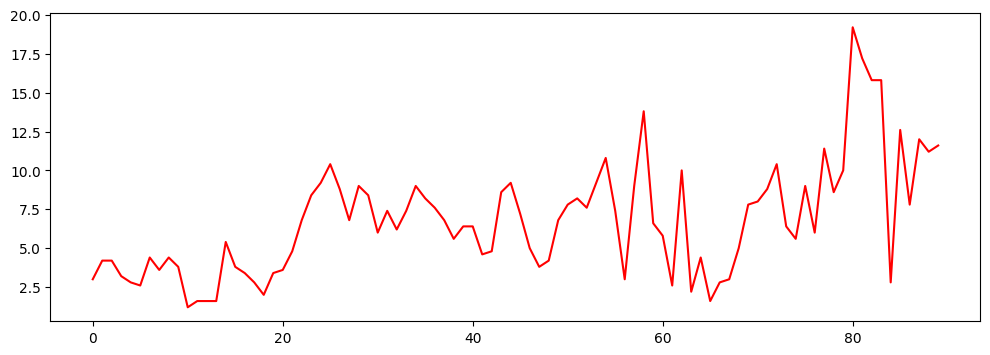

In [7]:
print('fit_time:',good_time)
plt.figure(figsize=(12, 4))
plt.plot(range(test_range),good_time,'r')
plt.show